In [1]:
# Install required packages
!pip install opencv-python
!pip install easyocr
!pip install torch torchvision
!pip install transformers
!pip install Pillow
!pip install matplotlib
!pip install scikit-learn
!pip install numpy

# # For GPU acceleration (optional)
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 28.9 MB/s eta 0:00:00


In [4]:
import cv2
import numpy as np
import json
import easyocr
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
from sklearn.cluster import DBSCAN
import re
from typing import List, Dict, Tuple, Optional
import uuid

class ArchitecturalDiagramExtractor:
    def __init__(self):
        """Initialize the diagram extractor with required models and processors."""
        self.setup_models()
        self.entity_types = {
            'database': ['db', 'database', 'mysql', 'postgres', 'mongodb', 'redis', 'cache'],
            'server': ['server', 'api', 'service', 'backend', 'frontend', 'web'],
            'user': ['user', 'client', 'browser', 'mobile', 'app'],
            'storage': ['s3', 'storage', 'bucket', 'file', 'blob'],
            'network': ['gateway', 'load balancer', 'cdn', 'proxy', 'router'],
            'queue': ['queue', 'kafka', 'rabbitmq', 'sqs', 'pubsub'],
            'compute': ['lambda', 'function', 'worker', 'processor', 'engine']
        }

    def setup_models(self):
        """Initialize OCR and object detection models."""
        # OCR setup
        self.ocr_reader = easyocr.Reader(['en'])

        # Object detection setup (using DETR for shape detection)
        self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
        self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

    def extract_from_image(self, image_path: str, description: str = "") -> Dict:
        """
        Main function to extract diagram data from image.

        Args:
            image_path: Path to the diagram image
            description: Optional text description of the diagram

        Returns:
            Dictionary in training JSON format
        """
        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image from {image_path}")

        print(f"Processing image: {image_path}")

        # Extract components
        shapes = self.detect_shapes(image)
        texts = self.extract_text(image)
        entities = self.create_entities(shapes, texts, image.shape)
        relationships = self.detect_relationships(entities, image)

        # Create training format
        training_data = self.create_training_format(entities, relationships, description)

        return training_data

    def detect_shapes(self, image: np.ndarray) -> List[Dict]:
        """Detect rectangular shapes that could be diagram entities."""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply different preprocessing techniques
        shapes = []

        # Method 1: Contour detection
        contours_shapes = self._detect_contours(gray)
        shapes.extend(contours_shapes)

        # Method 2: Edge detection + Hough lines
        edge_shapes = self._detect_edge_rectangles(gray)
        shapes.extend(edge_shapes)

        # Remove duplicates and filter
        shapes = self._filter_and_deduplicate_shapes(shapes)

        return shapes

    def _detect_contours(self, gray: np.ndarray) -> List[Dict]:
        """Detect shapes using contour detection."""
        shapes = []

        # Multiple threshold values for different diagram styles
        for thresh_val in [127, 180, 200]:
            _, thresh = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for contour in contours:
                area = cv2.contourArea(contour)
                if area > 500:  # Filter small noise
                    # Approximate contour to polygon
                    epsilon = 0.02 * cv2.arcLength(contour, True)
                    approx = cv2.approxPolyDP(contour, epsilon, True)

                    if len(approx) >= 4:  # Rectangular-ish shape
                        x, y, w, h = cv2.boundingRect(contour)
                        shapes.append({
                            'bbox': [x, y, x + w, y + h],
                            'area': area,
                            'method': 'contour'
                        })

        return shapes

    def _detect_edge_rectangles(self, gray: np.ndarray) -> List[Dict]:
        """Detect rectangles using edge detection and Hough lines."""
        shapes = []

        # Edge detection
        edges = cv2.Canny(gray, 50, 150, apertureSize=3)

        # Morphological operations to connect broken lines
        kernel = np.ones((3,3), np.uint8)
        edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

        # Find contours in edge image
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 800:  # Larger threshold for edge detection
                x, y, w, h = cv2.boundingRect(contour)
                if w > 50 and h > 30:  # Reasonable size for diagram entity
                    shapes.append({
                        'bbox': [x, y, x + w, y + h],
                        'area': area,
                        'method': 'edge'
                    })

        return shapes

    def _filter_and_deduplicate_shapes(self, shapes: List[Dict]) -> List[Dict]:
        """Remove duplicate and overlapping shapes."""
        if not shapes:
            return []

        # Sort by area (largest first)
        shapes.sort(key=lambda x: x['area'], reverse=True)

        filtered_shapes = []
        for shape in shapes:
            bbox1 = shape['bbox']

            # Check overlap with already selected shapes
            is_duplicate = False
            for existing_shape in filtered_shapes:
                bbox2 = existing_shape['bbox']

                # Calculate IoU (Intersection over Union)
                iou = self._calculate_iou(bbox1, bbox2)
                if iou > 0.7:  # High overlap threshold
                    is_duplicate = True
                    break

            if not is_duplicate:
                filtered_shapes.append(shape)

        return filtered_shapes

    def _calculate_iou(self, bbox1: List[int], bbox2: List[int]) -> float:
        """Calculate Intersection over Union of two bounding boxes."""
        x1_1, y1_1, x2_1, y2_1 = bbox1
        x1_2, y1_2, x2_2, y2_2 = bbox2

        # Calculate intersection
        x1_i = max(x1_1, x1_2)
        y1_i = max(y1_1, y1_2)
        x2_i = min(x2_1, x2_2)
        y2_i = min(y2_1, y2_2)

        if x2_i <= x1_i or y2_i <= y1_i:
            return 0.0

        intersection = (x2_i - x1_i) * (y2_i - y1_i)
        area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
        area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
        union = area1 + area2 - intersection

        return intersection / union if union > 0 else 0.0

    def extract_text(self, image: np.ndarray) -> List[Dict]:
        """Extract text from image using OCR."""
        # Convert BGR to RGB for EasyOCR
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Extract text with bounding boxes
        results = self.ocr_reader.readtext(rgb_image)

        texts = []
        for (bbox, text, confidence) in results:
            if confidence > 0.5:  # Filter low-confidence detections
                # Convert bbox format
                x_coords = [point[0] for point in bbox]
                y_coords = [point[1] for point in bbox]

                x1, x2 = int(min(x_coords)), int(max(x_coords))
                y1, y2 = int(min(y_coords)), int(max(y_coords))

                texts.append({
                    'text': text.strip(),
                    'bbox': [x1, y1, x2, y2],
                    'confidence': confidence
                })

        return texts

    def create_entities(self, shapes: List[Dict], texts: List[Dict], image_shape: Tuple) -> List[Dict]:
        """Match detected shapes with text to create entities."""
        height, width = image_shape[:2]
        entities = []

        for i, shape in enumerate(shapes):
            shape_bbox = shape['bbox']

            # Find text within or near this shape
            associated_texts = []
            for text in texts:
                text_bbox = text['bbox']

                # Check if text is inside shape or overlapping
                if self._is_text_in_shape(text_bbox, shape_bbox):
                    associated_texts.append(text)

            # Determine entity type and label
            if associated_texts:
                # Combine all text within the shape
                combined_text = ' '.join([t['text'] for t in associated_texts])
                entity_type = self._classify_entity_type(combined_text)
                label = self._clean_label(combined_text)
            else:
                # No text found, use generic naming
                entity_type = 'component'
                label = f'Component {i+1}'

            # Normalize coordinates
            x1, y1, x2, y2 = shape_bbox
            normalized_bbox = [
                round(x1 / width, 3),
                round(y1 / height, 3),
                round(x2 / width, 3),
                round(y2 / height, 3)
            ]

            entity = {
                'id': f'entity_{str(uuid.uuid4())[:8]}',
                'type': entity_type,
                'label': label,
                'bbox': normalized_bbox,
                'style': self._get_style_for_type(entity_type)
            }

            entities.append(entity)

        return entities

    def _is_text_in_shape(self, text_bbox: List[int], shape_bbox: List[int]) -> bool:
        """Check if text bounding box is within or overlaps with shape."""
        tx1, ty1, tx2, ty2 = text_bbox
        sx1, sy1, sx2, sy2 = shape_bbox

        # Expand shape bbox slightly for better matching
        margin = 10
        sx1 -= margin
        sy1 -= margin
        sx2 += margin
        sy2 += margin

        # Check if text center is within expanded shape
        text_center_x = (tx1 + tx2) / 2
        text_center_y = (ty1 + ty2) / 2

        return (sx1 <= text_center_x <= sx2 and sy1 <= text_center_y <= sy2)

    def _classify_entity_type(self, text: str) -> str:
        """Classify entity type based on text content."""
        text_lower = text.lower()

        for entity_type, keywords in self.entity_types.items():
            for keyword in keywords:
                if keyword in text_lower:
                    return entity_type

        # Default classification based on common patterns
        if any(word in text_lower for word in ['service', 'api', 'server']):
            return 'service'
        elif any(word in text_lower for word in ['db', 'database', 'data']):
            return 'database'
        elif any(word in text_lower for word in ['user', 'client', 'browser']):
            return 'user'
        else:
            return 'component'

    def _clean_label(self, text: str) -> str:
        """Clean and format entity label."""
        # Remove special characters and extra spaces
        cleaned = re.sub(r'[^\w\s-]', '', text)
        cleaned = ' '.join(cleaned.split())

        # Capitalize first letter of each word
        return cleaned.title() if cleaned else 'Component'

    def _get_style_for_type(self, entity_type: str) -> Dict:
        """Get style configuration for entity type."""
        style_map = {
            'database': {'shape': 'cylinder', 'color': '#4CAF50'},
            'server': {'shape': 'rectangle', 'color': '#2196F3'},
            'service': {'shape': 'rectangle', 'color': '#FF9800'},
            'user': {'shape': 'ellipse', 'color': '#9C27B0'},
            'storage': {'shape': 'cylinder', 'color': '#607D8B'},
            'network': {'shape': 'diamond', 'color': '#F44336'},
            'queue': {'shape': 'rectangle', 'color': '#FFEB3B'},
            'component': {'shape': 'rectangle', 'color': '#795548'}
        }

        return style_map.get(entity_type, style_map['component'])

    def detect_relationships(self, entities: List[Dict], image: np.ndarray) -> List[Dict]:
        """Detect relationships between entities by analyzing connecting lines."""
        relationships = []

        if len(entities) < 2:
            return relationships

        # Detect lines/arrows in the image
        lines = self._detect_connecting_lines(image)

        # Match lines to entity connections
        for line in lines:
            start_point, end_point = line

            # Find entities connected by this line
            start_entity = self._find_entity_at_point(start_point, entities, image.shape)
            end_entity = self._find_entity_at_point(end_point, entities, image.shape)

            if start_entity and end_entity and start_entity != end_entity:
                relationship = {
                    'id': f'rel_{str(uuid.uuid4())[:8]}',
                    'source': start_entity['id'],
                    'target': end_entity['id'],
                    'type': 'connects_to',
                    'style': {'arrow': True, 'color': '#666666'}
                }
                relationships.append(relationship)

        # If no lines detected, create relationships based on proximity
        if not relationships:
            relationships = self._create_proximity_relationships(entities)

        return relationships

    def _detect_connecting_lines(self, image: np.ndarray) -> List[Tuple]:
        """Detect lines and arrows connecting diagram elements."""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 150, apertureSize=3)

        # Detect lines using HoughLinesP
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50,
                               minLineLength=30, maxLineGap=10)

        detected_lines = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                detected_lines.append(((x1, y1), (x2, y2)))

        return detected_lines

    def _find_entity_at_point(self, point: Tuple[int, int], entities: List[Dict],
                             image_shape: Tuple) -> Optional[Dict]:
        """Find entity that contains or is closest to the given point."""
        x, y = point
        height, width = image_shape[:2]

        # Convert to normalized coordinates
        norm_x = x / width
        norm_y = y / height

        for entity in entities:
            bbox = entity['bbox']
            x1, y1, x2, y2 = bbox

            # Expand bbox slightly for better matching
            margin = 0.02
            if (x1 - margin <= norm_x <= x2 + margin and
                y1 - margin <= norm_y <= y2 + margin):
                return entity

        return None

    def _create_proximity_relationships(self, entities: List[Dict]) -> List[Dict]:
        """Create relationships based on entity proximity when lines aren't detected."""
        relationships = []

        for i, entity1 in enumerate(entities):
            for j, entity2 in enumerate(entities[i+1:], i+1):
                # Calculate distance between entity centers
                x1_center = (entity1['bbox'][0] + entity1['bbox'][2]) / 2
                y1_center = (entity1['bbox'][1] + entity1['bbox'][3]) / 2

                x2_center = (entity2['bbox'][0] + entity2['bbox'][2]) / 2
                y2_center = (entity2['bbox'][1] + entity2['bbox'][3]) / 2

                distance = np.sqrt((x2_center - x1_center)**2 + (y2_center - y1_center)**2)

                # Create relationship if entities are reasonably close
                if distance < 0.3:  # Threshold in normalized coordinates
                    relationship_type = self._determine_relationship_type(entity1, entity2)

                    relationship = {
                        'id': f'rel_{str(uuid.uuid4())[:8]}',
                        'source': entity1['id'],
                        'target': entity2['id'],
                        'type': relationship_type,
                        'style': {'arrow': True, 'color': '#666666'}
                    }
                    relationships.append(relationship)

        return relationships

    def _determine_relationship_type(self, entity1: Dict, entity2: Dict) -> str:
        """Determine relationship type based on entity types."""
        type1, type2 = entity1['type'], entity2['type']

        # Define relationship rules
        if type1 == 'user' or type2 == 'user':
            return 'interacts_with'
        elif 'database' in [type1, type2]:
            return 'queries' if type1 != 'database' else 'stores_data'
        elif 'service' in [type1, type2]:
            return 'calls'
        else:
            return 'connects_to'

    def create_training_format(self, entities: List[Dict], relationships: List[Dict],
                             description: str) -> Dict:
        """Create the final training data format."""
        # Generate description if not provided
        if not description:
            description = self._generate_description(entities, relationships)

        assistant_content = {
            "entities": entities,
            "relationships": relationships,
            "metadata": {
                "entity_count": len(entities),
                "relationship_count": len(relationships),
                "complexity": "simple" if len(entities) <= 3 else "medium" if len(entities) <= 6 else "complex"
            }
        }

        training_example = {
            "messages": [
                {
                    "role": "system",
                    "content": "Generate architectural diagram plan from description."
                },
                {
                    "role": "user",
                    "content": description
                },
                {
                    "role": "assistant",
                    "content": json.dumps(assistant_content, indent=2)
                }
            ]
        }

        return training_example

    def _generate_description(self, entities: List[Dict], relationships: List[Dict]) -> str:
        """Generate natural language description of the diagram."""
        entity_types = [entity['type'] for entity in entities]
        entity_labels = [entity['label'] for entity in entities]

        # Create basic description
        if len(entities) <= 2:
            description = f"Simple architecture with {', '.join(entity_labels)}"
        else:
            main_components = entity_labels[:3]
            description = f"Architecture diagram showing {', '.join(main_components)}"
            if len(entities) > 3:
                description += f" and {len(entities) - 3} other components"

        # Add relationship context
        if relationships:
            description += f" with {len(relationships)} connections"

        return description

    def visualize_extraction(self, image_path: str, entities: List[Dict],
                           relationships: List[Dict]) -> None:
        """Visualize the extracted entities and relationships on the original image."""
        image = cv2.imread(image_path)
        height, width = image.shape[:2]

        # Convert to PIL for drawing
        pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        draw = ImageDraw.Draw(pil_image)

        # Draw entity bounding boxes
        for entity in entities:
            bbox = entity['bbox']
            x1 = int(bbox[0] * width)
            y1 = int(bbox[1] * height)
            x2 = int(bbox[2] * width)
            y2 = int(bbox[3] * height)

            # Draw rectangle
            draw.rectangle([x1, y1, x2, y2], outline='red', width=2)

            # Draw label
            draw.text((x1, y1-15), entity['label'], fill='red')

        # Display result
        plt.figure(figsize=(12, 8))
        plt.imshow(pil_image)
        plt.axis('off')
        plt.title('Extracted Entities and Relationships')
        plt.show()

# Usage functions
def process_single_image(image_path: str, description: str = "",
                        output_path: str = None) -> Dict:
    """Process a single diagram image and return JSON training data."""
    extractor = ArchitecturalDiagramExtractor()

    try:
        # Extract data from image
        training_data = extractor.extract_from_image(image_path, description)

        # Save to file if output path provided
        if output_path:
            with open(output_path, 'w') as f:
                json.dump(training_data, f, indent=2)
            print(f"Training data saved to: {output_path}")

        # Print summary
        entities = json.loads(training_data['messages'][2]['content'])['entities']
        relationships = json.loads(training_data['messages'][2]['content'])['relationships']

        print(f"\nExtraction Summary:")
        print(f"- Found {len(entities)} entities")
        print(f"- Found {len(relationships)} relationships")
        print(f"- Generated description: {training_data['messages'][1]['content']}")

        return training_data

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

def process_image_batch(image_folder: str, output_folder: str = "training_data/") -> None:
    """Process multiple diagram images in batch."""
    import os
    import glob

    # Create output folder
    os.makedirs(output_folder, exist_ok=True)

    # Find all image files
    image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tiff']
    image_files = []

    for extension in image_extensions:
        image_files.extend(glob.glob(os.path.join(image_folder, extension)))
        image_files.extend(glob.glob(os.path.join(image_folder, extension.upper())))

    print(f"Found {len(image_files)} images to process")

    # Process each image
    training_examples = []

    for i, image_path in enumerate(image_files):
        print(f"\nProcessing {i+1}/{len(image_files)}: {os.path.basename(image_path)}")

        # Generate output filename
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        output_file = os.path.join(output_folder, f"{base_name}_training.json")

        # Process image
        training_data = process_single_image(image_path, output_path=output_file)

        if training_data:
            training_examples.append(training_data)

    # Create combined JSONL file for fine-tuning
    jsonl_path = os.path.join(output_folder, "combined_training_data.jsonl")
    with open(jsonl_path, 'w') as f:
        for example in training_examples:
            f.write(json.dumps(example) + '\n')

    print(f"\nBatch processing complete!")
    print(f"- Processed {len(training_examples)} images successfully")
    print(f"- Individual JSON files saved in: {output_folder}")
    print(f"- Combined JSONL file: {jsonl_path}")

# Example usage
if __name__ == "__main__":
    # Process single image
    image_path = "/content/Screenshot 2025-08-20 110640.png"
    description = "Web application architecture with load balancer"  # Optional

    training_data = process_single_image(
        image_path=image_path,
        description=description,
        output_path="diagram_training_data.json"
    )


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Processing image: /content/Screenshot 2025-08-20 110640.png
Training data saved to: diagram_training_data.json

Extraction Summary:
- Found 6 entities
- Found 11 relationships
- Generated description: Web application architecture with load balancer


In [5]:
from diagram_extractor import process_single_image

# Process your diagram
result = process_single_image(
    image_path="/content/Screenshot 2025-08-20 110640.png",
    description="Microservices architecture with API gateway",
    output_path="training_data.json"
)

print("Generated training data:", result)

ModuleNotFoundError: No module named 'diagram_extractor'

In [7]:
import cv2
import numpy as np
import json
import easyocr
from PIL import Image, ImageDraw, ImageEnhance
import matplotlib.pyplot as plt
import re
from typing import List, Dict, Tuple, Optional
import uuid
from sklearn.cluster import DBSCAN
import colorsys

class FlowchartDiagramExtractor:
    def __init__(self):
        """Enhanced extractor for flowchart-style architectural diagrams."""
        self.setup_models()
        self.entity_keywords = {
            'user': ['user', 'client', 'end user', 'customer'],
            'gateway': ['gateway', 'api gateway', 'proxy'],
            'function': ['lambda', 'function', 'serverless', 'compute'],
            'processor': ['processor', 'inference', 'model', 'ai', 'ml'],
            'service': ['sagemaker', 'service', 'engine', 'platform'],
            'storage': ['s3', 'bucket', 'storage', 'database', 'db'],
            'output': ['output', 'download', 'link', 'delivery', 'result'],
            'orchestration': ['orchestration', 'workflow', 'step'],
            'model': ['model', 'inference', 'prediction']
        }

        # Flow arrow keywords for relationship detection
        self.flow_keywords = {
            'upload': 'uploads',
            'trigger': 'triggers',
            'process': 'processes',
            'send': 'sends_to',
            'store': 'stores_in',
            'generate': 'generates',
            'deliver': 'delivers',
            'access': 'accesses',
            'control': 'controls',
            'invoke': 'invokes',
            'call': 'calls'
        }

    def setup_models(self):
        """Initialize OCR with enhanced settings for dark backgrounds."""
        self.ocr_reader = easyocr.Reader(['en'], gpu=False)

    def extract_from_image(self, image_path: str, description: str = "") -> Dict:
        """
        Enhanced extraction for flowchart diagrams.
        """
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image from {image_path}")

        print(f"Processing flowchart diagram: {image_path}")

        # Preprocess for dark background
        processed_image = self.preprocess_dark_diagram(image)

        # Extract components with enhanced methods
        shapes = self.detect_flowchart_shapes(processed_image, image)
        texts = self.extract_text_enhanced(processed_image, image)
        arrows = self.detect_arrows_and_flows(image)

        # Create entities and relationships
        entities = self.create_flowchart_entities(shapes, texts, image.shape)
        relationships = self.create_flowchart_relationships(entities, arrows, texts, image.shape)

        # Generate training format
        training_data = self.create_training_format(entities, relationships, description)

        return training_data

    def preprocess_dark_diagram(self, image: np.ndarray) -> np.ndarray:
        """Preprocess dark background diagrams for better detection."""
        # Convert to different color spaces for analysis
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Enhance contrast for dark backgrounds
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        enhanced_gray = clahe.apply(gray)

        # Create binary mask for colored components
        # Dark background means components are lighter
        _, binary = cv2.threshold(enhanced_gray, 30, 255, cv2.THRESH_BINARY)

        # Morphological operations to clean up
        kernel = np.ones((3,3), np.uint8)
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

        return binary

    def detect_flowchart_shapes(self, processed_image: np.ndarray, original_image: np.ndarray) -> List[Dict]:
        """Detect rounded rectangles and other flowchart shapes."""
        shapes = []

        # Method 1: Contour detection on processed binary image
        contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            area = cv2.contourArea(contour)

            # Filter by size (flowchart components are reasonably sized)
            if 1000 < area < 50000:
                # Get bounding rectangle
                x, y, w, h = cv2.boundingRect(contour)

                # Check aspect ratio (flowchart boxes are not too thin)
                aspect_ratio = w / h if h > 0 else 0
                if 0.3 < aspect_ratio < 5.0:

                    # Analyze the contour to determine shape type
                    shape_type = self._classify_shape_type(contour, area)

                    # Get dominant color in this region
                    color = self._get_dominant_color(original_image, x, y, w, h)

                    shapes.append({
                        'bbox': [x, y, x + w, y + h],
                        'area': area,
                        'shape_type': shape_type,
                        'color': color,
                        'contour': contour
                    })

        # Method 2: Color-based detection for specific component types
        color_shapes = self._detect_by_color_regions(original_image)
        shapes.extend(color_shapes)

        # Remove duplicates and filter
        shapes = self._filter_flowchart_shapes(shapes)

        return shapes

    def _classify_shape_type(self, contour, area: float) -> str:
        """Classify the geometric shape of detected contours."""
        # Approximate contour
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Get aspect ratio of bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h if h > 0 else 1

        # Classify based on number of vertices and aspect ratio
        vertices = len(approx)

        if vertices == 4:
            # Check if it's square-like or rectangle-like
            if 0.8 < aspect_ratio < 1.2:
                return 'square'
            else:
                return 'rectangle'
        elif vertices > 6 or area / (w * h) > 0.85:  # High fill ratio suggests rounded shape
            if 0.8 < aspect_ratio < 1.2:
                return 'circle'
            else:
                return 'rounded_rectangle'
        elif vertices == 3:
            return 'triangle'
        elif vertices == 6:
            return 'hexagon'
        else:
            return 'polygon'

    def _get_dominant_color(self, image: np.ndarray, x: int, y: int, w: int, h: int) -> str:
        """Get the dominant color in a region."""
        roi = image[y:y+h, x:x+w]

        # Convert to HSV for better color analysis
        hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

        # Calculate mean hue
        mean_hue = np.mean(hsv_roi[:,:,0])
        mean_sat = np.mean(hsv_roi[:,:,1])
        mean_val = np.mean(hsv_roi[:,:,2])

        # Convert to color name
        if mean_sat < 50:  # Low saturation = grayscale
            if mean_val < 100:
                return 'black'
            elif mean_val > 200:
                return 'white'
            else:
                return 'gray'
        else:
            # Color classification based on hue
            if mean_hue < 15 or mean_hue > 165:
                return 'red'
            elif mean_hue < 45:
                return 'orange'
            elif mean_hue < 75:
                return 'yellow'
            elif mean_hue < 105:
                return 'green'
            elif mean_hue < 135:
                return 'blue'
            else:
                return 'purple'

    def _detect_by_color_regions(self, image: np.ndarray) -> List[Dict]:
        """Detect components by looking for colored regions on dark background."""
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        shapes = []

        # Define color ranges for common AWS service colors
        color_ranges = {
            'orange': [(10, 100, 100), (25, 255, 255)],  # Lambda orange
            'green': [(40, 50, 50), (80, 255, 255)],     # S3 green
            'blue': [(100, 50, 50), (130, 255, 255)],    # General blue
            'pink': [(140, 50, 50), (170, 255, 255)]     # API Gateway pink
        }

        for color_name, (lower, upper) in color_ranges.items():
            # Create mask for this color range
            lower = np.array(lower, dtype=np.uint8)
            upper = np.array(upper, dtype=np.uint8)
            mask = cv2.inRange(hsv, lower, upper)

            # Find contours in mask
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for contour in contours:
                area = cv2.contourArea(contour)
                if area > 500:  # Reasonable component size
                    x, y, w, h = cv2.boundingRect(contour)

                    shapes.append({
                        'bbox': [x, y, x + w, y + h],
                        'area': area,
                        'shape_type': 'colored_component',
                        'color': color_name,
                        'method': 'color_detection'
                    })

        return shapes

    def _filter_flowchart_shapes(self, shapes: List[Dict]) -> List[Dict]:
        """Filter and deduplicate detected shapes."""
        if not shapes:
            return []

        # Sort by area (largest first)
        shapes.sort(key=lambda x: x['area'], reverse=True)

        filtered_shapes = []
        for shape in shapes:
            bbox1 = shape['bbox']

            # Check for significant overlap with existing shapes
            is_duplicate = False
            for existing in filtered_shapes:
                bbox2 = existing['bbox']
                iou = self._calculate_iou(bbox1, bbox2)
                if iou > 0.5:  # 50% overlap threshold
                    is_duplicate = True
                    break

            if not is_duplicate:
                filtered_shapes.append(shape)

        return filtered_shapes

    def extract_text_enhanced(self, processed_image: np.ndarray, original_image: np.ndarray) -> List[Dict]:
        """Enhanced text extraction for dark background diagrams."""
        all_texts = []

        # Method 1: Extract from original image
        rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        results1 = self.ocr_reader.readtext(rgb_image, paragraph=False)

        # Method 2: Extract from enhanced/inverted image for better contrast
        inverted = cv2.bitwise_not(original_image)
        rgb_inverted = cv2.cvtColor(inverted, cv2.COLOR_BGR2RGB)
        results2 = self.ocr_reader.readtext(rgb_inverted, paragraph=False)

        # Combine results from both methods
        all_results = results1 + results2

        for (bbox, text, confidence) in all_results:
            if confidence > 0.4:  # Lower threshold for flowchart text
                # Convert bbox format
                x_coords = [point[0] for point in bbox]
                y_coords = [point[1] for point in bbox]

                x1, x2 = int(min(x_coords)), int(max(x_coords))
                y1, y2 = int(min(y_coords)), int(max(y_coords))

                # Clean the text
                cleaned_text = self._clean_extracted_text(text)

                if cleaned_text and len(cleaned_text) > 1:  # Valid text
                    all_texts.append({
                        'text': cleaned_text,
                        'bbox': [x1, y1, x2, y2],
                        'confidence': confidence,
                        'type': self._classify_text_type(cleaned_text)
                    })

        # Remove duplicate texts
        all_texts = self._deduplicate_texts(all_texts)

        return all_texts

    def _clean_extracted_text(self, text: str) -> str:
        """Clean and standardize extracted text."""
        # Remove extra whitespace and special characters
        cleaned = re.sub(r'[^\w\s\-\+]', '', text)
        cleaned = ' '.join(cleaned.split())

        # Convert to title case for consistency
        return cleaned.title() if cleaned else ""

    def _classify_text_type(self, text: str) -> str:
        """Classify text as component label or flow description."""
        text_lower = text.lower()

        # Flow descriptions usually contain action verbs
        flow_indicators = ['upload', 'send', 'process', 'generate', 'deliver', 'store', 'trigger', 'invoke']

        if any(indicator in text_lower for indicator in flow_indicators):
            return 'flow_label'
        elif len(text.split()) <= 3:  # Short text is likely component name
            return 'component_label'
        else:
            return 'description'

    def _deduplicate_texts(self, texts: List[Dict]) -> List[Dict]:
        """Remove duplicate text detections."""
        if not texts:
            return []

        # Group texts that are very close together
        unique_texts = []

        for text in texts:
            bbox1 = text['bbox']
            x1_center = (bbox1[0] + bbox1[2]) / 2
            y1_center = (bbox1[1] + bbox1[3]) / 2

            # Check if this text is too close to existing ones
            is_duplicate = False
            for existing in unique_texts:
                bbox2 = existing['bbox']
                x2_center = (bbox2[0] + bbox2[2]) / 2
                y2_center = (bbox2[1] + bbox2[3]) / 2

                # Calculate distance between centers
                distance = np.sqrt((x2_center - x1_center)**2 + (y2_center - y1_center)**2)

                # If very close and similar text, it's likely duplicate
                if distance < 30 and (
                    text['text'].lower() == existing['text'].lower() or
                    text['text'].lower() in existing['text'].lower() or
                    existing['text'].lower() in text['text'].lower()
                ):
                    is_duplicate = True
                    break

            if not is_duplicate:
                unique_texts.append(text)

        return unique_texts

    def detect_arrows_and_flows(self, image: np.ndarray) -> List[Dict]:
        """Detect arrows and flow connections in the diagram."""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Enhance contrast for line detection
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)

        # Edge detection with multiple thresholds
        edges1 = cv2.Canny(enhanced, 30, 100)
        edges2 = cv2.Canny(enhanced, 50, 150)
        edges = cv2.bitwise_or(edges1, edges2)

        # Detect lines using HoughLinesP
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=30,
                               minLineLength=20, maxLineGap=15)

        arrows = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]

                # Calculate line properties
                length = np.sqrt((x2-x1)**2 + (y2-y1)**2)
                angle = np.arctan2(y2-y1, x2-x1) * 180 / np.pi

                # Filter lines by length and angle
                if length > 40:  # Minimum arrow length
                    # Detect arrow direction by checking line endpoints
                    arrow_type = self._detect_arrow_type(image, (x1, y1), (x2, y2))

                    arrows.append({
                        'start': (x1, y1),
                        'end': (x2, y2),
                        'length': length,
                        'angle': angle,
                        'type': arrow_type
                    })

        return arrows

    def _detect_arrow_type(self, image: np.ndarray, start: Tuple[int, int],
                          end: Tuple[int, int]) -> str:
        """Detect if line is solid or dashed arrow."""
        x1, y1 = start
        x2, y2 = end

        # Sample points along the line
        num_samples = 10
        samples = []

        for i in range(num_samples):
            t = i / (num_samples - 1)
            x = int(x1 + t * (x2 - x1))
            y = int(y1 + t * (y2 - y1))

            if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
                # Get pixel intensity (assuming light lines on dark background)
                pixel_value = image[y, x]
                if len(pixel_value.shape) > 0:
                    intensity = np.mean(pixel_value)
                else:
                    intensity = pixel_value
                samples.append(intensity)

        if not samples:
            return 'solid'

        # Analyze intensity variation to detect dashes
        intensity_var = np.var(samples)

        # High variance suggests dashed line
        return 'dashed' if intensity_var > 1000 else 'solid'

    def create_flowchart_entities(self, shapes: List[Dict], texts: List[Dict],
                                 image_shape: Tuple) -> List[Dict]:
        """Create entities optimized for flowchart components."""
        height, width = image_shape[:2]
        entities = []

        for i, shape in enumerate(shapes):
            shape_bbox = shape['bbox']

            # Find component labels within this shape
            component_texts = []
            for text in texts:
                if text['type'] == 'component_label':
                    text_bbox = text['bbox']
                    if self._is_text_in_shape_flowchart(text_bbox, shape_bbox):
                        component_texts.append(text)

            # Determine entity properties
            if component_texts:
                # Use the most confident text as primary label
                primary_text = max(component_texts, key=lambda x: x['confidence'])
                label = primary_text['text']
                entity_type = self._classify_flowchart_entity(label, shape['color'])
            else:
                # Generate label based on shape properties
                entity_type = self._classify_by_shape_and_color(shape)
                label = f"{entity_type.replace('_', ' ').title()}"

            # Normalize coordinates
            x1, y1, x2, y2 = shape_bbox
            normalized_bbox = [
                round(x1 / width, 3),
                round(y1 / height, 3),
                round(x2 / width, 3),
                round(y2 / height, 3)
            ]

            entity = {
                'id': f'entity_{str(uuid.uuid4())[:8]}',
                'type': entity_type,
                'label': label,
                'bbox': normalized_bbox,
                'style': {
                    'shape': shape.get('shape_type', 'rectangle'),
                    'color': shape.get('color', 'blue'),
                    'fillColor': self._get_fill_color(shape.get('color', 'blue'))
                }
            }

            entities.append(entity)

        return entities

    def _is_text_in_shape_flowchart(self, text_bbox: List[int], shape_bbox: List[int]) -> bool:
        """Check if text is within flowchart component with better tolerance."""
        tx1, ty1, tx2, ty2 = text_bbox
        sx1, sy1, sx2, sy2 = shape_bbox

        # Text center
        text_center_x = (tx1 + tx2) / 2
        text_center_y = (ty1 + ty2) / 2

        # Check if text center is within shape bounds (with small margin)
        margin = 5
        return (sx1 - margin <= text_center_x <= sx2 + margin and
                sy1 - margin <= text_center_y <= sy2 + margin)

    def _classify_flowchart_entity(self, label: str, color: str) -> str:
        """Classify entity type based on label and visual properties."""
        label_lower = label.lower()

        # Check against keyword dictionary
        for entity_type, keywords in self.entity_keywords.items():
            for keyword in keywords:
                if keyword in label_lower:
                    return entity_type

        # Classify by color if no keyword match
        color_mappings = {
            'orange': 'function',
            'green': 'storage',
            'pink': 'gateway',
            'blue': 'service',
            'purple': 'processor'
        }

        return color_mappings.get(color, 'component')

    def _classify_by_shape_and_color(self, shape: Dict) -> str:
        """Classify entity when no text is available."""
        color = shape.get('color', 'blue')
        shape_type = shape.get('shape_type', 'rectangle')

        # AWS service color conventions
        if color == 'orange':
            return 'function'  # Lambda
        elif color == 'green':
            return 'storage'   # S3
        elif color == 'pink':
            return 'gateway'   # API Gateway
        elif shape_type == 'circle':
            return 'user'
        else:
            return 'service'

    def _get_fill_color(self, color: str) -> str:
        """Get appropriate fill color for entity."""
        color_map = {
            'orange': '#FF9800',
            'green': '#4CAF50',
            'pink': '#E91E63',
            'blue': '#2196F3',
            'purple': '#9C27B0',
            'red': '#F44336',
            'yellow': '#FFEB3B'
        }
        return color_map.get(color, '#607D8B')

    def create_flowchart_relationships(self, entities: List[Dict], arrows: List[Dict],
                                     texts: List[Dict], image_shape: Tuple) -> List[Dict]:
        """Create relationships based on detected arrows and flow labels."""
        height, width = image_shape[:2]
        relationships = []

        # Get flow labels (text that describes connections)
        flow_labels = [t for t in texts if t['type'] == 'flow_label']

        for arrow in arrows:
            start_point, end_point = arrow['start'], arrow['end']

            # Find entities connected by this arrow
            source_entity = self._find_entity_at_point_normalized(start_point, entities, (width, height))
            target_entity = self._find_entity_at_point_normalized(end_point, entities, (width, height))

            if source_entity and target_entity and source_entity != target_entity:
                # Find relevant flow label for this connection
                relationship_type, label = self._find_flow_label_for_arrow(
                    arrow, flow_labels, (width, height)
                )

                relationship = {
                    'id': f'rel_{str(uuid.uuid4())[:8]}',
                    'source': source_entity['id'],
                    'target': target_entity['id'],
                    'type': relationship_type,
                    'label': label,
                    'style': {
                        'arrow': True,
                        'lineType': arrow['type'],  # solid or dashed
                        'color': '#666666' if arrow['type'] == 'solid' else '#999999'
                    }
                }
                relationships.append(relationship)

        # If no arrows detected well, create relationships based on entity positions
        if len(relationships) < len(entities) - 1:
            additional_rels = self._create_positional_relationships(entities)
            relationships.extend(additional_rels)

        return relationships

    def _find_entity_at_point_normalized(self, point: Tuple[int, int], entities: List[Dict],
                                       image_size: Tuple[int, int]) -> Optional[Dict]:
        """Find entity at given pixel point."""
        x, y = point
        width, height = image_size

        # Convert to normalized coordinates
        norm_x = x / width
        norm_y = y / height

        for entity in entities:
            bbox = entity['bbox']
            x1, y1, x2, y2 = bbox

            # Expand bbox for better connection detection
            margin = 0.05
            if (x1 - margin <= norm_x <= x2 + margin and
                y1 - margin <= norm_y <= y2 + margin):
                return entity

        return None

    def _find_flow_label_for_arrow(self, arrow: Dict, flow_labels: List[Dict],
                                  image_size: Tuple[int, int]) -> Tuple[str, str]:
        """Find the text label that describes this arrow."""
        width, height = image_size
        arrow_center_x = (arrow['start'][0] + arrow['end'][0]) / (2 * width)
        arrow_center_y = (arrow['start'][1] + arrow['end'][1]) / (2 * height)

        closest_label = None
        min_distance = float('inf')

        for label in flow_labels:
            # Get label center
            bbox = label['bbox']
            label_center_x = ((bbox[0] + bbox[2]) / 2) / width
            label_center_y = ((bbox[1] + bbox[3]) / 2) / height

            # Calculate distance from arrow to label
            distance = np.sqrt((label_center_x - arrow_center_x)**2 +
                             (label_center_y - arrow_center_y)**2)

            if distance < min_distance:
                min_distance = distance
                closest_label = label

        # If found a close label, use it
        if closest_label and min_distance < 0.1:  # Within 10% of image size
            text = closest_label['text'].lower()

            # Map text to relationship type
            for keyword, rel_type in self.flow_keywords.items():
                if keyword in text:
                    return rel_type, closest_label['text']

            return 'flows_to', closest_label['text']

        # Default relationship
        return 'connects_to', ''

    def _create_positional_relationships(self, entities: List[Dict]) -> List[Dict]:
        """Create relationships based on entity positions when arrows aren't well detected."""
        relationships = []

        # Sort entities by x-coordinate (left to right flow)
        sorted_entities = sorted(entities, key=lambda e: e['bbox'][0])

        # Create sequential relationships
        for i in range(len(sorted_entities) - 1):
            source = sorted_entities[i]
            target = sorted_entities[i + 1]

            # Determine relationship type based on entity types
            rel_type = self._determine_relationship_type_flowchart(source, target)

            relationship = {
                'id': f'rel_{str(uuid.uuid4())[:8]}',
                'source': source['id'],
                'target': target['id'],
                'type': rel_type,
                'label': '',
                'style': {
                    'arrow': True,
                    'lineType': 'solid',
                    'color': '#666666'
                }
            }
            relationships.append(relationship)

        return relationships

    def _determine_relationship_type_flowchart(self, source: Dict, target: Dict) -> str:
        """Determine relationship type based on entity types in flowchart context."""
        source_type = source['type']
        target_type = target['type']

        # Flowchart-specific relationship rules
        if source_type == 'user' and target_type == 'gateway':
            return 'sends_request_to'
        elif source_type == 'gateway' and target_type == 'function':
            return 'triggers'
        elif source_type == 'function' and target_type == 'processor':
            return 'invokes'
        elif 'processor' in source_type and target_type == 'service':
            return 'processes_with'
        elif source_type == 'service' and target_type == 'storage':
            return 'stores_in'
        elif target_type == 'output':
            return 'generates'
        else:
            return 'flows_to'

    def create_training_format(self, entities: List[Dict], relationships: List[Dict],
                             description: str) -> Dict:
        """Create training format with enhanced description generation."""
        if not description:
            description = self._generate_flowchart_description(entities, relationships)

        assistant_content = {
            "entities": entities,
            "relationships": relationships,
            "metadata": {
                "diagram_type": "flowchart",
                "entity_count": len(entities),
                "relationship_count": len(relationships),
                "complexity": self._assess_complexity(entities, relationships),
                "flow_direction": "left_to_right"
            }
        }

        training_example = {
            "messages": [
                {
                    "role": "system",
                    "content": "Generate architectural flowchart diagram plan from description."
                },
                {
                    "role": "user",
                    "content": description
                },
                {
                    "role": "assistant",
                    "content": json.dumps(assistant_content, indent=2)
                }
            ]
        }

        return training_example

    def _generate_flowchart_description(self, entities: List[Dict], relationships: List[Dict]) -> str:
        """Generate natural language description of flowchart."""
        if not entities:
            return "Empty diagram"

        # Identify key components
        entity_types = {}
        for entity in entities:
            entity_type = entity['type']
            if entity_type not in entity_types:
                entity_types[entity_type] = []
            entity_types[entity_type].append(entity['label'])

        # Build description
        description_parts = []

        # Start with the flow
        if 'user' in entity_types:
            description_parts.append("User-initiated workflow")

        # Add key processing steps
        if 'gateway' in entity_types:
            description_parts.append("with API gateway")

        if 'function' in entity_types:
            description_parts.append("serverless processing")

        if 'processor' in entity_types or 'service' in entity_types:
            description_parts.append("AI/ML inference")

        if 'storage' in entity_types:
            description_parts.append("and data storage")

        if 'output' in entity_types:
            description_parts.append("delivering results")

        # Combine into coherent description
        if len(description_parts) > 1:
            description = f"Architecture showing {description_parts[0]} " + ", ".join(description_parts[1:])
        else:
            description = f"Flowchart with {len(entities)} components"

        # Add relationship context
        if relationships:
            description += f" ({len(relationships)} data flows)"

        return description

    def _assess_complexity(self, entities: List[Dict], relationships: List[Dict]) -> str:
        """Assess diagram complexity."""
        total_components = len(entities) + len(relationships)

        if total_components <= 4:
            return "simple"
        elif total_components <= 8:
            return "medium"
        else:
            return "complex"

    def _calculate_iou(self, bbox1: List[int], bbox2: List[int]) -> float:
        """Calculate Intersection over Union."""
        x1_1, y1_1, x2_1, y2_1 = bbox1
        x1_2, y1_2, x2_2, y2_2 = bbox2

        x1_i = max(x1_1, x1_2)
        y1_i = max(y1_1, y1_2)
        x2_i = min(x2_1, x2_2)
        y2_i = min(y2_1, y2_2)

        if x2_i <= x1_i or y2_i <= y1_i:
            return 0.0

        intersection = (x2_i - x1_i) * (y2_i - y1_i)
        area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
        area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
        union = area1 + area2 - intersection

        return intersection / union if union > 0 else 0.0

# Enhanced usage functions
def process_flowchart_image(image_path: str, description: str = "",
                           output_path: str = None, visualize: bool = False) -> Dict:
    """Process a flowchart diagram image."""
    extractor = FlowchartDiagramExtractor()

    try:
        # Extract data
        training_data = extractor.extract_from_image(image_path, description)

        # Save results
        if output_path:
            with open(output_path, 'w') as f:
                json.dump(training_data, f, indent=2)
            print(f"✅ Training data saved to: {output_path}")

        # Print summary
        assistant_content = json.loads(training_data['messages'][2]['content'])
        entities = assistant_content['entities']
        relationships = assistant_content['relationships']

        print(f"\n📊 Extraction Results:")
        print(f"   • Entities: {len(entities)}")
        print(f"   • Relationships: {len(relationships)}")
        print(f"   • Description: {training_data['messages'][1]['content']}")

        print(f"\n🔍 Detected Components:")
        for entity in entities:
            print(f"   • {entity['label']} ({entity['type']})")

        print(f"\n🔗 Detected Flows:")
        for rel in relationships:
            source_label = next(e['label'] for e in entities if e['id'] == rel['source'])
            target_label = next(e['label'] for e in entities if e['id'] == rel['target'])
            flow_label = f" - {rel['label']}" if rel.get('label') else ""
            print(f"   • {source_label} → {target_label}{flow_label}")

        return training_data

    except Exception as e:
        print(f"❌ Error processing {image_path}: {str(e)}")
        return None

# Quick test with your image
if __name__ == "__main__":
    # Test with your specific image
    image_url = "https://page.gensparksite.com/v1/base64_upload/3c8ff4c8254465710e6ef3fb28c0c692"

    # For URL images, you'd need to download first:
    import requests
    response = requests.get(image_url)
    with open("test_diagram.png", "wb") as f:
        f.write(response.content)

    # Then process:
    result = process_flowchart_image(
        "test_diagram.png",
        "AWS serverless image processing pipeline with Lambda and SageMaker",
        "flowchart_training.json"
    )


Processing flowchart diagram: test_diagram.png
✅ Training data saved to: flowchart_training.json

📊 Extraction Results:
   • Entities: 3
   • Relationships: 3
   • Description: AWS serverless image processing pipeline with Lambda and SageMaker

🔍 Detected Components:
   • Storage (storage)
   • Function (function)
   • Gateway (gateway)

🔗 Detected Flows:
   • Gateway → Function
   • Gateway → Function
   • Function → Storage


In [8]:
import json
import random
import uuid
from typing import List, Dict, Tuple
import os

class ArchitecturalTrainingDataGenerator:
    def __init__(self):
        self.setup_templates()
        self.setup_variations()

    def setup_templates(self):
        """Define architectural templates and patterns."""

        # Component types with their properties
        self.component_types = {
            'user': {
                'labels': ['End User', 'Client', 'Customer', 'Mobile User', 'Web User', 'Admin User'],
                'shapes': ['circle', 'ellipse'],
                'colors': ['#9C27B0', '#673AB7', '#3F51B5']
            },
            'gateway': {
                'labels': ['API Gateway', 'Load Balancer', 'Proxy', 'Gateway', 'Router'],
                'shapes': ['hexagon', 'diamond', 'rounded_rectangle'],
                'colors': ['#E91E63', '#F44336', '#FF5722']
            },
            'function': {
                'labels': ['Lambda Function', 'Serverless Function', 'Cloud Function', 'Worker', 'Handler'],
                'shapes': ['rounded_rectangle', 'rectangle'],
                'colors': ['#FF9800', '#FFC107', '#FFEB3B']
            },
            'service': {
                'labels': ['Microservice', 'API Service', 'Backend Service', 'Processing Service', 'Auth Service'],
                'shapes': ['rectangle', 'rounded_rectangle'],
                'colors': ['#2196F3', '#03A9F4', '#00BCD4']
            },
            'database': {
                'labels': ['Database', 'MySQL', 'PostgreSQL', 'MongoDB', 'Redis Cache'],
                'shapes': ['cylinder', 'rectangle'],
                'colors': ['#4CAF50', '#8BC34A', '#CDDC39']
            },
            'storage': {
                'labels': ['S3 Bucket', 'File Storage', 'Object Storage', 'Data Lake', 'Blob Storage'],
                'shapes': ['cylinder', 'rectangle'],
                'colors': ['#4CAF50', '#009688', '#607D8B']
            },
            'queue': {
                'labels': ['Message Queue', 'Kafka', 'RabbitMQ', 'SQS', 'Event Bus'],
                'shapes': ['rectangle', 'rounded_rectangle'],
                'colors': ['#FFEB3B', '#FFC107', '#FF9800']
            },
            'ml_service': {
                'labels': ['SageMaker', 'ML Model', 'AI Engine', 'Inference Service', 'Model Processor'],
                'shapes': ['rounded_rectangle', 'hexagon'],
                'colors': ['#9C27B0', '#673AB7', '#E91E63']
            },
            'monitoring': {
                'labels': ['CloudWatch', 'Monitoring', 'Logging Service', 'Metrics', 'Dashboard'],
                'shapes': ['rectangle', 'rounded_rectangle'],
                'colors': ['#795548', '#607D8B', '#9E9E9E']
            },
            'cdn': {
                'labels': ['CDN', 'CloudFront', 'Content Delivery', 'Edge Server', 'Cache'],
                'shapes': ['diamond', 'hexagon'],
                'colors': ['#FF5722', '#E91E63', '#9C27B0']
            }
        }

        # Relationship types
        self.relationship_types = {
            'user_interactions': ['interacts_with', 'sends_request_to', 'accesses', 'uploads_to'],
            'service_calls': ['calls', 'invokes', 'triggers', 'sends_to'],
            'data_flows': ['queries', 'stores_in', 'reads_from', 'writes_to'],
            'processing': ['processes_with', 'transforms', 'analyzes', 'validates'],
            'messaging': ['publishes_to', 'subscribes_to', 'sends_message_to', 'notifies'],
            'monitoring': ['monitors', 'logs_to', 'reports_to', 'alerts']
        }

        # Architecture patterns
        self.architecture_patterns = {
            'simple_web': {
                'components': ['user', 'gateway', 'service', 'database'],
                'description_templates': [
                    "Simple web application with {components}",
                    "Basic three-tier architecture",
                    "Web app with API and database",
                    "Standard web application setup"
                ]
            },
            'microservices': {
                'components': ['user', 'gateway', 'service', 'service', 'database', 'queue'],
                'description_templates': [
                    "Microservices architecture with {components}",
                    "Distributed system with multiple services",
                    "Event-driven microservices platform",
                    "Scalable microservices setup"
                ]
            },
            'serverless': {
                'components': ['user', 'gateway', 'function', 'database', 'storage'],
                'description_templates': [
                    "Serverless architecture using {components}",
                    "AWS Lambda-based processing pipeline",
                    "Event-driven serverless system",
                    "Cloud-native serverless application"
                ]
            },
            'ml_pipeline': {
                'components': ['user', 'gateway', 'function', 'ml_service', 'storage', 'database'],
                'description_templates': [
                    "Machine learning inference pipeline",
                    "AI-powered application with {components}",
                    "ML model serving architecture",
                    "Data processing and ML pipeline"
                ]
            },
            'data_platform': {
                'components': ['user', 'gateway', 'service', 'queue', 'database', 'storage', 'monitoring'],
                'description_templates': [
                    "Data analytics platform",
                    "Real-time data processing system",
                    "Big data architecture with {components}",
                    "Data pipeline and analytics platform"
                ]
            },
            'e_commerce': {
                'components': ['user', 'cdn', 'gateway', 'service', 'service', 'database', 'queue', 'monitoring'],
                'description_templates': [
                    "E-commerce platform architecture",
                    "Online shopping system with {components}",
                    "Scalable retail application",
                    "Multi-service e-commerce setup"
                ]
            }
        }

    def setup_variations(self):
        """Setup variation parameters for diversity."""

        self.complexity_levels = {
            'simple': {'min_components': 3, 'max_components': 4, 'relationship_density': 0.7},
            'medium': {'min_components': 4, 'max_components': 6, 'relationship_density': 0.8},
            'complex': {'min_components': 6, 'max_components': 9, 'relationship_density': 0.9}
        }

        self.layout_styles = ['horizontal', 'vertical', 'clustered', 'layered']

        # AWS/Cloud service variants
        self.cloud_variants = {
            'aws': ['Lambda', 'API Gateway', 'S3', 'DynamoDB', 'SQS', 'CloudWatch', 'SageMaker'],
            'azure': ['Functions', 'API Management', 'Blob Storage', 'Cosmos DB', 'Service Bus'],
            'gcp': ['Cloud Functions', 'API Gateway', 'Cloud Storage', 'Firestore', 'Pub/Sub']
        }

    def generate_training_examples(self, count: int = 100) -> List[Dict]:
        """Generate the specified number of training examples."""

        print(f"🎯 Generating {count} diverse training examples...")

        examples = []

        for i in range(count):
            # Select architecture pattern
            pattern_name = random.choice(list(self.architecture_patterns.keys()))
            pattern = self.architecture_patterns[pattern_name]

            # Select complexity
            complexity = random.choice(['simple', 'medium', 'complex'])

            # Generate example
            example = self.generate_single_example(pattern, complexity, i + 1)
            examples.append(example)

            if (i + 1) % 20 == 0:
                print(f"   ✅ Generated {i + 1}/{count} examples")

        print(f"🎉 Successfully generated {len(examples)} training examples!")
        return examples

    def generate_single_example(self, pattern: Dict, complexity: str, example_id: int) -> Dict:
        """Generate a single training example."""

        # Determine number of components
        complexity_config = self.complexity_levels[complexity]
        base_components = pattern['components']

        # Add variation to component count
        target_count = random.randint(
            complexity_config['min_components'],
            complexity_config['max_components']
        )

        # Adjust components to match target count
        if len(base_components) < target_count:
            # Add more components
            additional_types = ['service', 'database', 'queue', 'monitoring', 'storage']
            while len(base_components) < target_count:
                base_components.append(random.choice(additional_types))
        elif len(base_components) > target_count:
            # Remove some components
            base_components = base_components[:target_count]

        # Generate entities
        entities = self.generate_entities(base_components, complexity)

        # Generate relationships
        relationships = self.generate_relationships(entities, complexity_config['relationship_density'])

        # Generate description
        description = self.generate_description(pattern, entities, complexity)

        # Create training format
        training_example = self.create_training_format(entities, relationships, description)

        return training_example

    def generate_entities(self, component_types: List[str], complexity: str) -> List[Dict]:
        """Generate entities for the diagram."""

        entities = []
        layout_style = random.choice(self.layout_styles)

        for i, comp_type in enumerate(component_types):
            # Get component properties
            type_config = self.component_types[comp_type]

            # Generate position based on layout style
            position = self.generate_position(i, len(component_types), layout_style)

            # Create entity
            entity = {
                'id': f'entity_{str(uuid.uuid4())[:8]}',
                'type': comp_type,
                'label': self.add_variation_to_label(random.choice(type_config['labels'])),
                'bbox': position,
                'style': {
                    'shape': random.choice(type_config['shapes']),
                    'color': random.choice(type_config['colors']),
                    'fillColor': random.choice(type_config['colors'])
                }
            }

            entities.append(entity)

        return entities

    def generate_position(self, index: int, total: int, layout_style: str) -> List[float]:
        """Generate position coordinates based on layout style."""

        # Base dimensions
        base_width = 0.15
        base_height = 0.08

        # Add some randomness
        width = base_width + random.uniform(-0.02, 0.02)
        height = base_height + random.uniform(-0.01, 0.01)

        if layout_style == 'horizontal':
            # Left to right layout
            x_spacing = 0.8 / (total - 1) if total > 1 else 0
            x = 0.1 + (index * x_spacing)
            y = 0.4 + random.uniform(-0.1, 0.1)

        elif layout_style == 'vertical':
            # Top to bottom layout
            y_spacing = 0.6 / (total - 1) if total > 1 else 0
            x = 0.4 + random.uniform(-0.1, 0.1)
            y = 0.7 - (index * y_spacing)

        elif layout_style == 'clustered':
            # Clustered layout
            cluster_x = 0.2 if index < total // 2 else 0.6
            cluster_y = 0.3 + (index % (total // 2 + 1)) * 0.15
            x = cluster_x + random.uniform(-0.05, 0.05)
            y = cluster_y + random.uniform(-0.05, 0.05)

        else:  # layered
            # Layered layout (like network layers)
            layers = min(3, total)
            layer = index % layers
            position_in_layer = index // layers

            x = 0.15 + (layer * 0.3) + random.uniform(-0.02, 0.02)
            y = 0.6 - (position_in_layer * 0.2) + random.uniform(-0.05, 0.05)

        # Ensure positions are within bounds
        x = max(0.05, min(0.85 - width, x))
        y = max(0.05, min(0.9 - height, y))

        return [round(x, 3), round(y, 3), round(x + width, 3), round(y + height, 3)]

    def add_variation_to_label(self, base_label: str) -> str:
        """Add variations to component labels for diversity."""

        variations = {
            'Service': ['Service', 'Microservice', 'API', 'Backend'],
            'Database': ['Database', 'DB', 'Data Store', 'Repository'],
            'Function': ['Function', 'Lambda', 'Handler', 'Processor'],
            'Gateway': ['Gateway', 'Proxy', 'Router', 'Load Balancer'],
            'Storage': ['Storage', 'Bucket', 'Repository', 'Archive'],
            'Queue': ['Queue', 'Message Bus', 'Event Stream', 'Buffer'],
            'User': ['User', 'Client', 'Customer', 'End User']
        }

        # Add cloud provider prefixes sometimes
        if random.random() < 0.3:
            cloud_provider = random.choice(['AWS', 'Azure', 'GCP'])
            if 'Function' in base_label:
                cloud_services = {
                    'AWS': 'AWS Lambda',
                    'Azure': 'Azure Functions',
                    'GCP': 'Cloud Functions'
                }
                return cloud_services.get(cloud_provider, base_label)

        # Add numbers/versions sometimes
        if random.random() < 0.2:
            base_label += f" {random.choice(['v1', 'v2', '2.0', 'Pro'])}"

        return base_label

    def generate_relationships(self, entities: List[Dict], density: float) -> List[Dict]:
        """Generate relationships between entities."""

        relationships = []

        # Create base flow (sequential connections)
        for i in range(len(entities) - 1):
            source = entities[i]
            target = entities[i + 1]

            rel_type = self.determine_relationship_type(source, target)

            relationship = {
                'id': f'rel_{str(uuid.uuid4())[:8]}',
                'source': source['id'],
                'target': target['id'],
                'type': rel_type,
                'label': self.generate_relationship_label(rel_type),
                'style': {
                    'arrow': True,
                    'lineType': random.choice(['solid', 'dashed']),
                    'color': '#666666'
                }
            }

            relationships.append(relationship)

        # Add additional relationships based on density
        total_possible = len(entities) * (len(entities) - 1)
        target_relationships = int(total_possible * density * 0.3)  # Scale down

        while len(relationships) < target_relationships and len(relationships) < len(entities) * 2:
            source = random.choice(entities)
            target = random.choice([e for e in entities if e['id'] != source['id']])

            # Check if relationship already exists
            existing = any(r['source'] == source['id'] and r['target'] == target['id']
                          for r in relationships)

            if not existing:
                rel_type = self.determine_relationship_type(source, target)

                relationship = {
                    'id': f'rel_{str(uuid.uuid4())[:8]}',
                    'source': source['id'],
                    'target': target['id'],
                    'type': rel_type,
                    'label': self.generate_relationship_label(rel_type),
                    'style': {
                        'arrow': True,
                        'lineType': random.choice(['solid', 'dashed']),
                        'color': '#666666'
                    }
                }

                relationships.append(relationship)

        return relationships

    def determine_relationship_type(self, source: Dict, target: Dict) -> str:
        """Determine appropriate relationship type between entities."""

        source_type = source['type']
        target_type = target['type']

        # Define relationship rules
        rules = {
            ('user', 'gateway'): ['sends_request_to', 'accesses', 'interacts_with'],
            ('user', 'service'): ['uses', 'accesses', 'interacts_with'],
            ('gateway', 'function'): ['triggers', 'invokes', 'routes_to'],
            ('gateway', 'service'): ['routes_to', 'forwards_to', 'calls'],
            ('function', 'database'): ['queries', 'reads_from', 'writes_to'],
            ('function', 'storage'): ['stores_in', 'reads_from', 'uploads_to'],
            ('function', 'ml_service'): ['invokes', 'processes_with', 'calls'],
            ('service', 'database'): ['queries', 'stores_in', 'retrieves_from'],
            ('service', 'service'): ['calls', 'communicates_with', 'sends_to'],
            ('service', 'queue'): ['publishes_to', 'sends_message_to', 'enqueues_to'],
            ('queue', 'service'): ['delivers_to', 'notifies', 'triggers'],
            ('ml_service', 'storage'): ['stores_results_in', 'saves_to', 'outputs_to'],
            ('monitoring', 'service'): ['monitors', 'tracks', 'observes']
        }

        # Find matching rule
        key = (source_type, target_type)
        if key in rules:
            return random.choice(rules[key])

        # Default relationships
        if target_type in ['database', 'storage']:
            return random.choice(['stores_in', 'reads_from', 'queries'])
        elif source_type == 'user':
            return random.choice(['accesses', 'uses', 'interacts_with'])
        else:
            return random.choice(['connects_to', 'communicates_with', 'sends_to'])

    def generate_relationship_label(self, rel_type: str) -> str:
        """Generate descriptive labels for relationships."""

        label_mappings = {
            'sends_request_to': ['HTTP request', 'API call', 'user input'],
            'triggers': ['event trigger', 'invoke', 'execute'],
            'queries': ['SQL query', 'data request', 'fetch data'],
            'stores_in': ['save data', 'persist', 'store results'],
            'processes_with': ['ML inference', 'analyze', 'transform'],
            'publishes_to': ['send event', 'publish message', 'queue message'],
            'monitors': ['health check', 'log metrics', 'track performance']
        }

        if rel_type in label_mappings:
            return random.choice(label_mappings[rel_type])

        # Return empty label sometimes for variety
        return '' if random.random() < 0.3 else rel_type.replace('_', ' ')

    def generate_description(self, pattern: Dict, entities: List[Dict], complexity: str) -> str:
        """Generate natural language description of the architecture."""

        # Get base description template
        template = random.choice(pattern['description_templates'])

        # Extract component types
        component_types = [e['type'] for e in entities]
        unique_types = list(set(component_types))

        # Generate component list
        type_names = {
            'user': 'users', 'gateway': 'API gateway', 'function': 'serverless functions',
            'service': 'microservices', 'database': 'database', 'storage': 'storage',
            'queue': 'message queue', 'ml_service': 'ML services', 'monitoring': 'monitoring',
            'cdn': 'CDN'
        }

        components_desc = ', '.join([type_names.get(t, t) for t in unique_types[:4]])

        # Format template
        if '{components}' in template:
            description = template.format(components=components_desc)
        else:
            description = template

        # Add complexity and scale indicators
        scale_indicators = {
            'simple': ['basic', 'simple', 'minimal', 'lightweight'],
            'medium': ['scalable', 'robust', 'enterprise-grade', 'production-ready'],
            'complex': ['highly scalable', 'enterprise', 'distributed', 'fault-tolerant']
        }

        if random.random() < 0.4:  # 40% chance to add scale indicator
            scale_word = random.choice(scale_indicators[complexity])
            description = f"{scale_word.title()} {description.lower()}"

        # Add domain/industry context sometimes
        domains = [
            'e-commerce', 'fintech', 'healthcare', 'media streaming',
            'IoT', 'social media', 'gaming', 'logistics'
        ]

        if random.random() < 0.2:  # 20% chance to add domain
            domain = random.choice(domains)
            description = f"{description} for {domain}"

        return description

    def create_training_format(self, entities: List[Dict], relationships: List[Dict], description: str) -> Dict:
        """Create the training example in the required format."""

        assistant_content = {
            "entities": entities,
            "relationships": relationships,
            "metadata": {
                "entity_count": len(entities),
                "relationship_count": len(relationships),
                "complexity": "simple" if len(entities) <= 4 else "medium" if len(entities) <= 6 else "complex",
                "diagram_type": "architectural_flowchart"
            }
        }

        training_example = {
            "messages": [
                {
                    "role": "system",
                    "content": "Generate architectural diagram plan from description. Output valid JSON with entities and relationships."
                },
                {
                    "role": "user",
                    "content": description
                },
                {
                    "role": "assistant",
                    "content": json.dumps(assistant_content, separators=(',', ':'))  # Compact JSON
                }
            ]
        }

        return training_example

    def save_training_data(self, examples: List[Dict], output_dir: str = "training_data"):
        """Save training examples to files."""

        os.makedirs(output_dir, exist_ok=True)

        # Save individual JSON files
        for i, example in enumerate(examples):
            filename = f"training_example_{i+1:03d}.json"
            filepath = os.path.join(output_dir, filename)

            with open(filepath, 'w') as f:
                json.dump(example, f, indent=2)

        # Save combined JSONL file for fine-tuning
        jsonl_path = os.path.join(output_dir, "combined_training_data.jsonl")
        with open(jsonl_path, 'w') as f:
            for example in examples:
                f.write(json.dumps(example) + '\n')

        # Save statistics
        stats = self.generate_statistics(examples)
        stats_path = os.path.join(output_dir, "dataset_statistics.json")
        with open(stats_path, 'w') as f:
            json.dump(stats, f, indent=2)

        print(f"\n📁 Training data saved to: {output_dir}")
        print(f"   • Individual files: {len(examples)} JSON files")
        print(f"   • Combined file: combined_training_data.jsonl")
        print(f"   • Statistics: dataset_statistics.json")

        return jsonl_path

    def generate_statistics(self, examples: List[Dict]) -> Dict:
        """Generate statistics about the training dataset."""

        entity_types = {}
        relationship_types = {}
        complexities = {}

        for example in examples:
            assistant_content = json.loads(example['messages'][2]['content'])

            # Count entity types
            for entity in assistant_content['entities']:
                entity_type = entity['type']
                entity_types[entity_type] = entity_types.get(entity_type, 0) + 1

            # Count relationship types
            for rel in assistant_content['relationships']:
                rel_type = rel['type']
                relationship_types[rel_type] = relationship_types.get(rel_type, 0) + 1

            # Count complexities
            complexity = assistant_content['metadata']['complexity']
            complexities[complexity] = complexities.get(complexity, 0) + 1

        return {
            'total_examples': len(examples),
            'entity_type_distribution': entity_types,
            'relationship_type_distribution': relationship_types,
            'complexity_distribution': complexities,
            'avg_entities_per_example': sum(len(json.loads(ex['messages'][2]['content'])['entities']) for ex in examples) / len(examples),
            'avg_relationships_per_example': sum(len(json.loads(ex['messages'][2]['content'])['relationships']) for ex in examples) / len(examples)
        }

# Main generation function
def generate_100_training_examples():
    """Generate 100 diverse training examples."""

    print("🚀 Starting generation of 100 training examples...")

    # Initialize generator
    generator = ArchitecturalTrainingDataGenerator()

    # Generate examples
    examples = generator.generate_training_examples(count=100)

    # Save to files
    jsonl_path = generator.save_training_data(examples)

    # Print summary
    stats = generator.generate_statistics(examples)
    print(f"\n📊 Dataset Summary:")
    print(f"   • Total examples: {stats['total_examples']}")
    print(f"   • Avg entities per example: {stats['avg_entities_per_example']:.1f}")
    print(f"   • Avg relationships per example: {stats['avg_relationships_per_example']:.1f}")
    print(f"   • Complexity distribution: {stats['complexity_distribution']}")

    print(f"\n✅ Ready for fine-tuning! Use file: {jsonl_path}")

    return jsonl_path

# Quick validation function
def validate_generated_data(jsonl_file: str):
    """Validate the generated training data."""

    print(f"\n🔍 Validating generated training data...")

    with open(jsonl_file, 'r') as f:
        examples = [json.loads(line) for line in f]

    valid_count = 0
    issues = []

    for i, example in enumerate(examples):
        try:
            # Check structure
            assert 'messages' in example
            assert len(example['messages']) == 3

            # Check assistant content is valid JSON
            assistant_content = json.loads(example['messages'][2]['content'])
            assert 'entities' in assistant_content
            assert 'relationships' in assistant_content

            valid_count += 1

        except Exception as e:
            issues.append(f"Example {i+1}: {e}")

    print(f"   • Valid examples: {valid_count}/{len(examples)}")
    print(f"   • Issues found: {len(issues)}")

    if issues:
        print("   ⚠️  First few issues:")
        for issue in issues[:3]:
            print(f"     - {issue}")
    else:
        print("   ✅ All examples are valid!")

    return len(issues) == 0

# Usage
if __name__ == "__main__":
    # Generate 100 training examples
    jsonl_path = generate_100_training_examples()

    # Validate the generated data
    is_valid = validate_generated_data(jsonl_path)

    if is_valid:
        print(f"\n🎯 Success! Your training data is ready at: {jsonl_path}")
        print("Next steps:")
        print("1. Use this JSONL file to fine-tune your OPT-125M model")
        print("2. Test the fine-tuned model with new prompts")
        print("3. Build the diagram renderer to create visual outputs")
    else:
        print("\n❌ Please fix the validation issues before proceeding")


🚀 Starting generation of 100 training examples...
🎯 Generating 100 diverse training examples...
   ✅ Generated 20/100 examples
   ✅ Generated 40/100 examples
   ✅ Generated 60/100 examples
   ✅ Generated 80/100 examples
   ✅ Generated 100/100 examples
🎉 Successfully generated 100 training examples!

📁 Training data saved to: training_data
   • Individual files: 100 JSON files
   • Combined file: combined_training_data.jsonl
   • Statistics: dataset_statistics.json

📊 Dataset Summary:
   • Total examples: 100
   • Avg entities per example: 5.0
   • Avg relationships per example: 5.8
   • Complexity distribution: {'simple': 48, 'complex': 19, 'medium': 33}

✅ Ready for fine-tuning! Use file: training_data/combined_training_data.jsonl

🔍 Validating generated training data...
   • Valid examples: 100/100
   • Issues found: 0
   ✅ All examples are valid!

🎯 Success! Your training data is ready at: training_data/combined_training_data.jsonl
Next steps:
1. Use this JSONL file to fine-tune you

🎨 Architectural Diagram Visualizer

4. Analyzing visual diversity...
📈 Analyzing visual diversity of training data...
🔍 Creating comparison grid with 12 diagrams


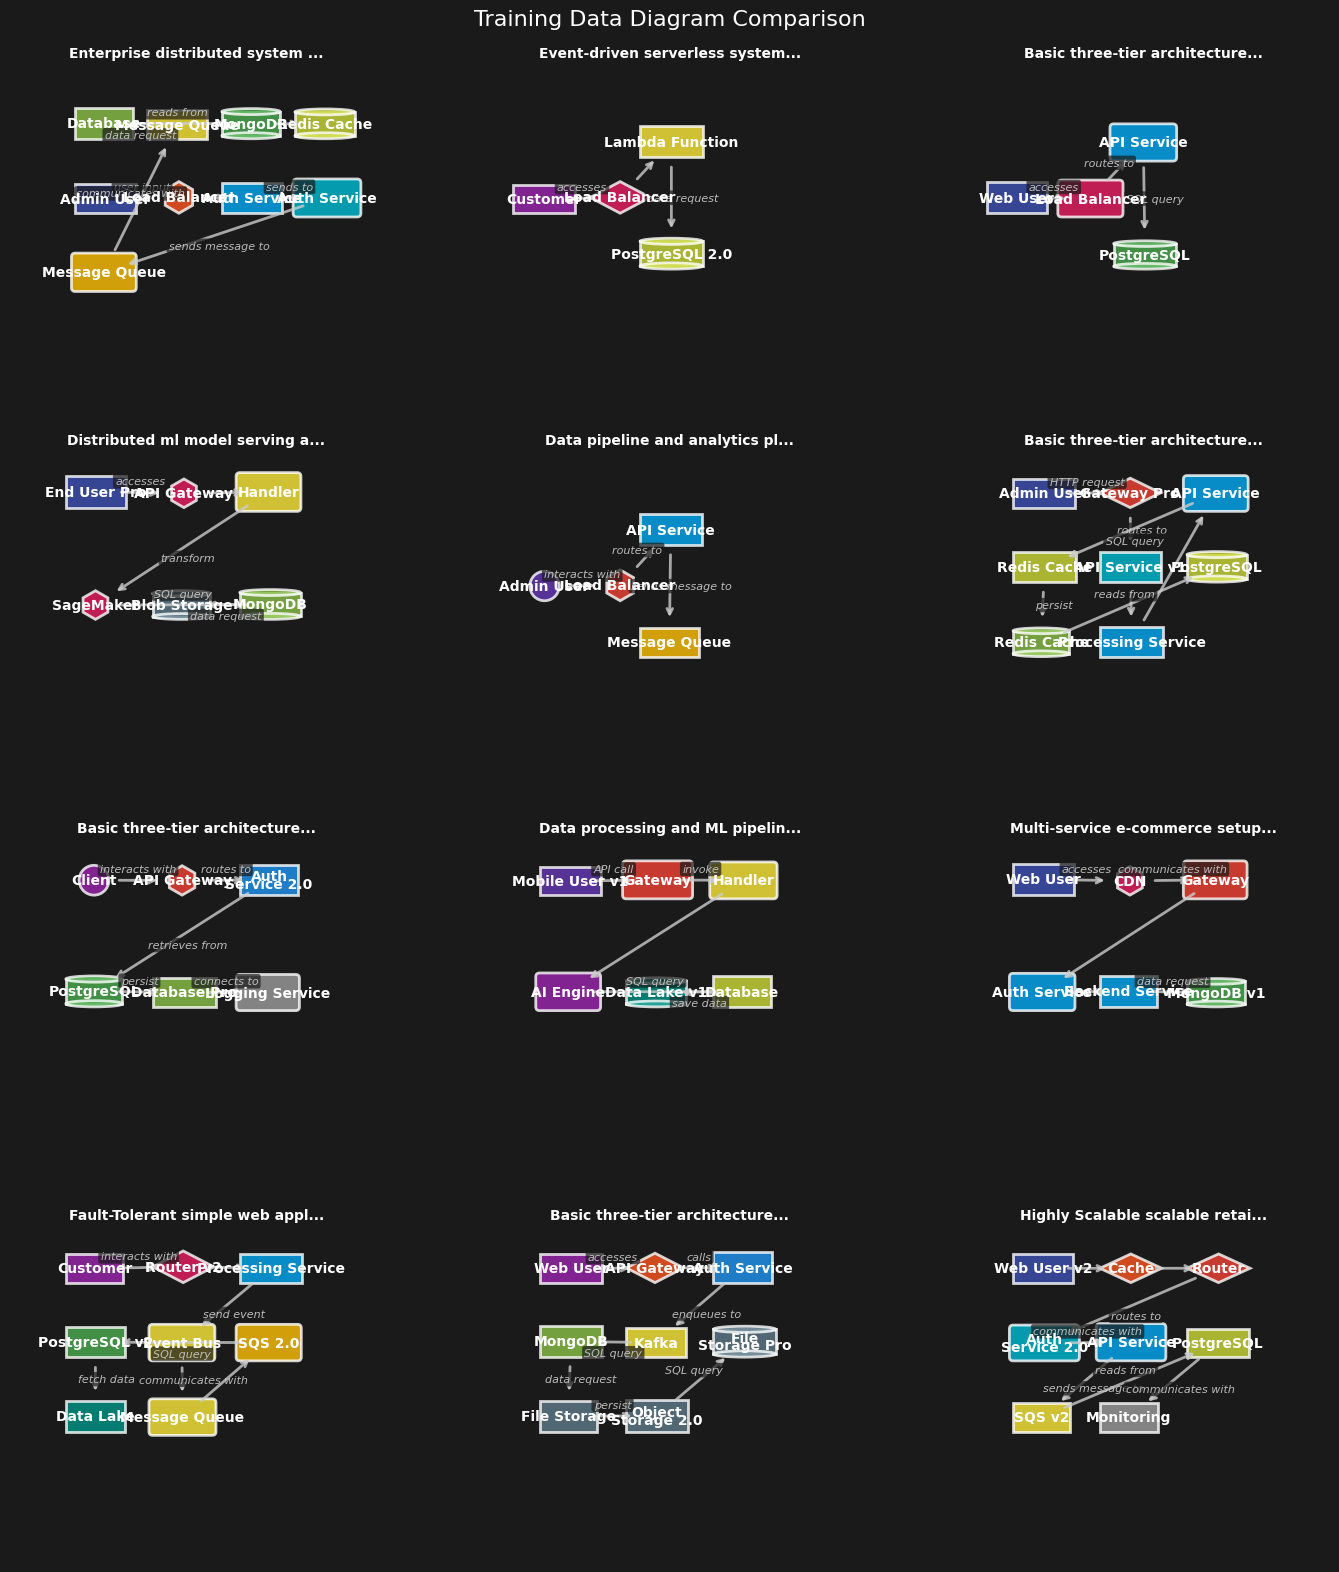

   💾 Comparison grid saved: training_data_analysis.png

📊 Visual Analysis Summary:
   • Entity count range: 4 - 9
   • Relationship count range: 3 - 8
   • Complexity distribution: {'medium', 'complex', 'simple'}


In [16]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, Circle, RegularPolygon, Wedge
import numpy as np
import os
from typing import Dict, List, Tuple
import math

class ArchitecturalDiagramVisualizer:
    def __init__(self, figsize=(12, 8), dpi=150):
        self.figsize = figsize
        self.dpi = dpi
        self.setup_styles()

    def setup_styles(self):
        """Setup visual styling configurations."""

        # Color mappings for different entity types
        self.type_colors = {
            'user': '#9C27B0',
            'gateway': '#E91E63',
            'function': '#FF9800',
            'service': '#2196F3',
            'database': '#4CAF50',
            'storage': '#4CAF50',
            'queue': '#FFEB3B',
            'ml_service': '#9C27B0',
            'monitoring': '#607D8B',
            'cdn': '#FF5722',
            'component': '#607D8B'
        }

        # Shape mappings
        self.type_shapes = {
            'user': 'circle',
            'gateway': 'hexagon',
            'function': 'rounded_rectangle',
            'service': 'rectangle',
            'database': 'cylinder',
            'storage': 'cylinder',
            'queue': 'rectangle',
            'ml_service': 'rounded_rectangle',
            'monitoring': 'rectangle',
            'cdn': 'diamond'
        }

        # Arrow styles for different relationship types
        self.relationship_styles = {
            'solid': {'linestyle': '-', 'alpha': 0.8, 'linewidth': 2},
            'dashed': {'linestyle': '--', 'alpha': 0.6, 'linewidth': 2},
            'dotted': {'linestyle': ':', 'alpha': 0.6, 'linewidth': 2}
        }

    def visualize_from_json_file(self, json_file_path: str, output_path: str = None, show: bool = True):
        """
        Load and visualize diagram from JSON file.
        """
        print(f"📊 Visualizing diagram from: {json_file_path}")

        try:
            # Load JSON data
            with open(json_file_path, 'r') as f:
                data = json.load(f)

            # Extract diagram data based on file format
            if 'messages' in data:
                # Training format - extract from assistant message
                assistant_content = data['messages'][2]['content']
                diagram_data = json.loads(assistant_content)
                user_prompt = data['messages'][1]['content']
            else:
                # Direct diagram format
                diagram_data = data
                user_prompt = "Architecture Diagram"

            # Create visualization
            output_file = self.render_diagram(diagram_data, user_prompt, output_path)

            if show:
                plt.show()

            return output_file

        except Exception as e:
            print(f"❌ Error visualizing {json_file_path}: {str(e)}")
            return None

    def render_diagram(self, diagram_data: Dict, title: str = "Architecture Diagram",
                      output_path: str = None) -> str:
        """
        Render the complete diagram from JSON data.
        """

        # Create figure with dark background
        fig, ax = plt.subplots(1, 1, figsize=self.figsize, dpi=self.dpi)

        # Set dark theme
        fig.patch.set_facecolor('#1a1a1a')
        ax.set_facecolor('#1a1a1a')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_aspect('equal')
        ax.axis('off')

        # Get entities and relationships
        entities = diagram_data.get('entities', [])
        relationships = diagram_data.get('relationships', [])

        print(f"   • Entities: {len(entities)}")
        print(f"   • Relationships: {len(relationships)}")

        # Create entity position lookup
        entity_positions = {}

        # Step 1: Draw relationships first (so they appear behind entities)
        for entity in entities:
            bbox = entity['bbox']
            center_x = (bbox[0] + bbox[2]) / 2
            center_y = (bbox[1] + bbox[3]) / 2
            entity_positions[entity['id']] = (center_x, center_y)

        # Draw all relationships
        for relationship in relationships:
            self._draw_relationship(ax, relationship, entity_positions)

        # Step 2: Draw entities on top
        for entity in entities:
            self._draw_entity(ax, entity)

        # Add title
        ax.text(0.5, 0.95, title, ha='center', va='top', fontsize=14,
                color='white', weight='bold', wrap=True)

        # Add metadata if available
        metadata = diagram_data.get('metadata', {})
        if metadata:
            info_text = f"Components: {metadata.get('entity_count', len(entities))} | "
            info_text += f"Connections: {metadata.get('relationship_count', len(relationships))} | "
            info_text += f"Complexity: {metadata.get('complexity', 'N/A')}"

            ax.text(0.02, 0.02, info_text, ha='left', va='bottom', fontsize=10,
                   color='#cccccc', alpha=0.8)

        # Save if output path provided
        if output_path:
            plt.savefig(output_path, dpi=self.dpi, bbox_inches='tight',
                       facecolor='#1a1a1a', edgecolor='none')
            print(f"   💾 Saved diagram: {output_path}")
        else:
            # Generate default filename
            output_path = f"diagram_visualization.png"
            plt.savefig(output_path, dpi=self.dpi, bbox_inches='tight',
                       facecolor='#1a1a1a', edgecolor='none')
            print(f"   💾 Saved diagram: {output_path}")

        return output_path

    def _draw_entity(self, ax, entity: Dict):
        """Draw a single entity with appropriate shape and styling."""

        bbox = entity['bbox']
        label = entity['label']
        entity_type = entity['type']
        style = entity.get('style', {})

        # Get coordinates
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2

        # Get colors and shape
        color = style.get('color', self.type_colors.get(entity_type, '#607D8B'))
        shape_type = style.get('shape', self.type_shapes.get(entity_type, 'rectangle'))

        # Draw shape based on type
        if shape_type == 'circle':
            self._draw_circle(ax, center_x, center_y, min(width, height)/2, color)

        elif shape_type == 'hexagon':
            self._draw_hexagon(ax, center_x, center_y, min(width, height)/2, color)

        elif shape_type == 'diamond':
            self._draw_diamond(ax, center_x, center_y, width/2, height/2, color)

        elif shape_type == 'cylinder':
            self._draw_cylinder(ax, x1, y1, width, height, color)

        elif shape_type == 'rounded_rectangle':
            self._draw_rounded_rectangle(ax, x1, y1, width, height, color)

        else:  # rectangle
            self._draw_rectangle(ax, x1, y1, width, height, color)

        # Add text label
        self._draw_label(ax, center_x, center_y, label, width)

    def _draw_circle(self, ax, x: float, y: float, radius: float, color: str):
        """Draw a circle shape."""
        circle = Circle((x, y), radius, facecolor=color, edgecolor='white',
                       linewidth=2, alpha=0.8)
        ax.add_patch(circle)

    def _draw_hexagon(self, ax, x: float, y: float, radius: float, color: str):
        """Draw a hexagon shape."""
        hexagon = RegularPolygon((x, y), 6, radius=radius, facecolor=color,
                               edgecolor='white', linewidth=2, alpha=0.8)
        ax.add_patch(hexagon)

    def _draw_diamond(self, ax, x: float, y: float, width: float, height: float, color: str):
        """Draw a diamond shape."""
        diamond_points = [
            [x, y + height],      # top
            [x + width, y],       # right
            [x, y - height],      # bottom
            [x - width, y]        # left
        ]
        diamond = patches.Polygon(diamond_points, facecolor=color, edgecolor='white',
                                linewidth=2, alpha=0.8)
        ax.add_patch(diamond)

    def _draw_cylinder(self, ax, x: float, y: float, width: float, height: float, color: str):
        """Draw a cylinder shape (for databases/storage)."""
        # Main rectangle body
        rect = patches.Rectangle((x, y + height*0.1), width, height*0.8,
                               facecolor=color, edgecolor='white', linewidth=2, alpha=0.8)
        ax.add_patch(rect)

        # Top ellipse
        top_ellipse = patches.Ellipse((x + width/2, y + height*0.9), width, height*0.2,
                                    facecolor=color, edgecolor='white', linewidth=2, alpha=0.8)
        ax.add_patch(top_ellipse)

        # Bottom ellipse
        bottom_ellipse = patches.Ellipse((x + width/2, y + height*0.1), width, height*0.2,
                                       facecolor=color, edgecolor='white', linewidth=2, alpha=0.8)
        ax.add_patch(bottom_ellipse)

    def _draw_rounded_rectangle(self, ax, x: float, y: float, width: float, height: float, color: str):
        """Draw a rounded rectangle."""
        rounded_rect = FancyBboxPatch((x, y), width, height, boxstyle="round,pad=0.01",
                                    facecolor=color, edgecolor='white', linewidth=2, alpha=0.8)
        ax.add_patch(rounded_rect)

    def _draw_rectangle(self, ax, x: float, y: float, width: float, height: float, color: str):
        """Draw a standard rectangle."""
        rect = patches.Rectangle((x, y), width, height, facecolor=color, edgecolor='white',
                               linewidth=2, alpha=0.8)
        ax.add_patch(rect)

    def _draw_label(self, ax, x: float, y: float, label: str, max_width: float):
        """Draw text label with word wrapping."""
        # Adjust font size based on available width
        base_fontsize = 10
        if max_width < 0.15:  # Small component
            fontsize = 8
        elif max_width > 0.25:  # Large component
            fontsize = 12
        else:
            fontsize = base_fontsize

        # Simple word wrapping
        words = label.split()
        if len(words) > 2 and len(label) > 15:
            # Split into multiple lines
            mid = len(words) // 2
            line1 = ' '.join(words[:mid])
            line2 = ' '.join(words[mid:])

            ax.text(x, y + 0.01, line1, ha='center', va='center', fontsize=fontsize,
                   color='white', weight='bold')
            ax.text(x, y - 0.01, line2, ha='center', va='center', fontsize=fontsize,
                   color='white', weight='bold')
        else:
            ax.text(x, y, label, ha='center', va='center', fontsize=fontsize,
                   color='white', weight='bold')

    def _draw_relationship(self, ax, relationship: Dict, entity_positions: Dict):
        """Draw relationship arrow between entities."""

        source_id = relationship['source']
        target_id = relationship['target']
        rel_type = relationship.get('type', 'connects_to')
        label = relationship.get('label', '')
        style_config = relationship.get('style', {})

        if source_id not in entity_positions or target_id not in entity_positions:
            return

        source_pos = entity_positions[source_id]
        target_pos = entity_positions[target_id]

        # Get line style
        line_type = style_config.get('lineType', 'solid')
        line_style = self.relationship_styles.get(line_type, self.relationship_styles['solid'])

        # Calculate arrow properties
        dx = target_pos[0] - source_pos[0]
        dy = target_pos[1] - source_pos[1]
        length = np.sqrt(dx*dx + dy*dy)

        if length == 0:
            return

        # Normalize direction
        dx_norm = dx / length
        dy_norm = dy / length

        # Offset start and end points to avoid overlapping with shapes
        offset = 0.06
        start_x = source_pos[0] + dx_norm * offset
        start_y = source_pos[1] + dy_norm * offset
        end_x = target_pos[0] - dx_norm * offset
        end_y = target_pos[1] - dy_norm * offset

        # Draw arrow
        if line_type == 'dashed':
            ax.annotate('', xy=(end_x, end_y), xytext=(start_x, start_y),
                       arrowprops=dict(arrowstyle='->', color='#cccccc', lw=2,
                                     linestyle='--', alpha=0.7))
        else:
            ax.annotate('', xy=(end_x, end_y), xytext=(start_x, start_y),
                       arrowprops=dict(arrowstyle='->', color='#cccccc', lw=2, alpha=0.8))

        # Add relationship label if present
        if label:
            mid_x = (start_x + end_x) / 2
            mid_y = (start_y + end_y) / 2

            # Offset label slightly to avoid overlapping with arrow
            label_offset_x = -dy_norm * 0.03
            label_offset_y = dx_norm * 0.03

            ax.text(mid_x + label_offset_x, mid_y + label_offset_y, label,
                   ha='center', va='center', fontsize=8, color='#cccccc',
                   style='italic', alpha=0.9,
                   bbox=dict(boxstyle="round,pad=0.2", facecolor='#1a1a1a',
                           edgecolor='none', alpha=0.7))

def visualize_single_diagram(json_path: str, output_path: str = None):
    """
    Quick function to visualize a single diagram.
    """
    visualizer = ArchitecturalDiagramVisualizer()
    return visualizer.visualize_from_json_file(json_path, output_path, show=True)

def batch_visualize_training_data(folder_path: str, output_folder: str = "visualized_diagrams"):
    """
    Visualize all JSON training files in a folder.
    """
    print(f"🎨 Batch visualizing diagrams from: {folder_path}")

    # Create output folder
    os.makedirs(output_folder, exist_ok=True)

    # Find all JSON files
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

    if not json_files:
        print("❌ No JSON files found in the specified folder")
        return

    print(f"Found {len(json_files)} JSON files to visualize")

    visualizer = ArchitecturalDiagramVisualizer()
    successful = 0

    for i, json_file in enumerate(json_files[:20]):  # Limit to first 20 for demo
        json_path = os.path.join(folder_path, json_file)

        # Generate output filename
        base_name = os.path.splitext(json_file)[0]
        output_path = os.path.join(output_folder, f"{base_name}_diagram.png")

        print(f"\n📊 Processing {i+1}/{min(20, len(json_files))}: {json_file}")

        try:
            result = visualizer.visualize_from_json_file(json_path, output_path, show=False)
            if result:
                successful += 1
                print(f"   ✅ Success: {output_path}")

        except Exception as e:
            print(f"   ❌ Failed: {str(e)}")

    print(f"\n🎉 Batch visualization complete!")
    print(f"   • Successfully processed: {successful}/{min(20, len(json_files))} files")
    print(f"   • Output folder: {output_folder}")

def create_comparison_grid(json_files: List[str], output_path: str = "comparison_grid.png"):
    """
    Create a grid comparing multiple diagrams side by side.
    """
    print(f"🔍 Creating comparison grid with {len(json_files)} diagrams")

    # Calculate grid dimensions
    n_files = len(json_files)
    cols = min(3, n_files)  # Max 3 columns
    rows = (n_files + cols - 1) // cols

    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), facecolor='#1a1a1a')
    fig.suptitle('Training Data Diagram Comparison', color='white', fontsize=16, y=0.98)

    # Handle single subplot case
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    visualizer = ArchitecturalDiagramVisualizer()

    for i, json_file in enumerate(json_files):
        if i >= len(axes):
            break

        ax = axes[i]
        ax.set_facecolor('#1a1a1a')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_aspect('equal')
        ax.axis('off')

        try:
            # Load and parse JSON
            with open(json_file, 'r') as f:
                data = json.load(f)

            if 'messages' in data:
                diagram_data = json.loads(data['messages'][2]['content'])
                title = data['messages'][1]['content'][:30] + "..."
            else:
                diagram_data = data
                title = f"Diagram {i+1}"

            # Draw on this specific axis
            entities = diagram_data.get('entities', [])
            relationships = diagram_data.get('relationships', [])

            # Entity positions
            entity_positions = {}
            for entity in entities:
                bbox = entity['bbox']
                center_x = (bbox[0] + bbox[2]) / 2
                center_y = (bbox[1] + bbox[3]) / 2
                entity_positions[entity['id']] = (center_x, center_y)

            # Draw relationships then entities
            for relationship in relationships:
                visualizer._draw_relationship(ax, relationship, entity_positions)

            for entity in entities:
                visualizer._draw_entity(ax, entity)

            # Add title
            ax.text(0.5, 0.95, title, ha='center', va='top', fontsize=10,
                   color='white', weight='bold')

        except Exception as e:
            ax.text(0.5, 0.5, f"Error loading\n{os.path.basename(json_file)}",
                   ha='center', va='center', color='red', fontsize=10)

    # Hide unused subplots
    for i in range(len(json_files), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight',
               facecolor='#1a1a1a', edgecolor='none')
    plt.show()

    print(f"   💾 Comparison grid saved: {output_path}")

# Quick test functions
def preview_training_data(folder_path: str = "training_data", num_samples: int = 5):
    """
    Preview a few random training examples.
    """
    print(f"👀 Previewing {num_samples} random training examples...")

    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

    if not json_files:
        print("❌ No JSON files found")
        return

    # Select random samples
    import random
    sample_files = random.sample(json_files, min(num_samples, len(json_files)))
    sample_paths = [os.path.join(folder_path, f) for f in sample_files]

    # Create comparison grid
    create_comparison_grid(sample_paths, "preview_training_data.png")

def analyze_training_data_visually(folder_path: str = "training_data"):
    """
    Analyze the visual diversity of training data.
    """
    print(f"📈 Analyzing visual diversity of training data...")

    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

    if not json_files:
        print("❌ No JSON files found")
        return

    # Analyze first 12 files
    sample_files = json_files[:12]
    sample_paths = [os.path.join(folder_path, f) for f in sample_files]

    # Create analysis grid
    create_comparison_grid(sample_paths, "training_data_analysis.png")

    # Print statistics
    entity_counts = []
    relationship_counts = []
    complexities = []

    for json_path in sample_paths:
        try:
            with open(json_path, 'r') as f:
                data = json.load(f)

            if 'messages' in data:
                diagram_data = json.loads(data['messages'][2]['content'])
            else:
                diagram_data = data

            entity_counts.append(len(diagram_data.get('entities', [])))
            relationship_counts.append(len(diagram_data.get('relationships', [])))

            metadata = diagram_data.get('metadata', {})
            complexities.append(metadata.get('complexity', 'unknown'))

        except:
            continue

    print(f"\n📊 Visual Analysis Summary:")
    print(f"   • Entity count range: {min(entity_counts)} - {max(entity_counts)}")
    print(f"   • Relationship count range: {min(relationship_counts)} - {max(relationship_counts)}")
    print(f"   • Complexity distribution: {set(complexities)}")

# Main usage examples
if __name__ == "__main__":

    print("🎨 Architectural Diagram Visualizer")
    print("=" * 50)

    # # Example 1: Visualize a single JSON file
    # print("\n1. Visualizing single diagram...")
    # visualize_single_diagram("/content/training_data/training_example_007.json")

    # # Example 2: Preview random samples from training data
    # print("\n2. Previewing training data samples...")
    # preview_training_data("training_data", num_samples=6)

    # # Example 3: Batch visualize multiple files
    # print("\n3. Batch visualizing diagrams...")
    # # batch_visualize_training_data("training_data", "output_diagrams")

    # Example 4: Analyze visual diversity
    print("\n4. Analyzing visual diversity...")
    analyze_training_data_visually("training_data_improved")


In [15]:
import json
import random
import uuid
from typing import List, Dict, Tuple
import os
import numpy as np

class ImprovedArchitecturalTrainingDataGenerator:
    def __init__(self):
        self.setup_templates()
        self.setup_variations()

    def setup_templates(self):
        """Define architectural templates and patterns."""

        # Component types with their properties
        self.component_types = {
            'user': {
                'labels': ['End User', 'Client', 'Customer', 'Mobile User', 'Web User', 'Admin User'],
                'shapes': ['circle', 'ellipse'],
                'colors': ['#9C27B0', '#673AB7', '#3F51B5']
            },
            'gateway': {
                'labels': ['API Gateway', 'Load Balancer', 'Proxy', 'Gateway', 'Router'],
                'shapes': ['hexagon', 'diamond', 'rounded_rectangle'],
                'colors': ['#E91E63', '#F44336', '#FF5722']
            },
            'function': {
                'labels': ['Lambda Function', 'Serverless Function', 'Cloud Function', 'Worker', 'Handler'],
                'shapes': ['rounded_rectangle', 'rectangle'],
                'colors': ['#FF9800', '#FFC107', '#FFEB3B']
            },
            'service': {
                'labels': ['Microservice', 'API Service', 'Backend Service', 'Processing Service', 'Auth Service'],
                'shapes': ['rectangle', 'rounded_rectangle'],
                'colors': ['#2196F3', '#03A9F4', '#00BCD4']
            },
            'database': {
                'labels': ['Database', 'MySQL', 'PostgreSQL', 'MongoDB', 'Redis Cache'],
                'shapes': ['cylinder', 'rectangle'],
                'colors': ['#4CAF50', '#8BC34A', '#CDDC39']
            },
            'storage': {
                'labels': ['S3 Bucket', 'File Storage', 'Object Storage', 'Data Lake', 'Blob Storage'],
                'shapes': ['cylinder', 'rectangle'],
                'colors': ['#4CAF50', '#009688', '#607D8B']
            },
            'queue': {
                'labels': ['Message Queue', 'Kafka', 'RabbitMQ', 'SQS', 'Event Bus'],
                'shapes': ['rectangle', 'rounded_rectangle'],
                'colors': ['#FFEB3B', '#FFC107', '#FF9800']
            },
            'ml_service': {
                'labels': ['SageMaker', 'ML Model', 'AI Engine', 'Inference Service', 'Model Processor'],
                'shapes': ['rounded_rectangle', 'hexagon'],
                'colors': ['#9C27B0', '#673AB7', '#E91E63']
            },
            'monitoring': {
                'labels': ['CloudWatch', 'Monitoring', 'Logging Service', 'Metrics', 'Dashboard'],
                'shapes': ['rectangle', 'rounded_rectangle'],
                'colors': ['#795548', '#607D8B', '#9E9E9E']
            },
            'cdn': {
                'labels': ['CDN', 'CloudFront', 'Content Delivery', 'Edge Server', 'Cache'],
                'shapes': ['diamond', 'hexagon'],
                'colors': ['#FF5722', '#E91E63', '#9C27B0']
            }
        }

        # Relationship types
        self.relationship_types = {
            'user_interactions': ['interacts_with', 'sends_request_to', 'accesses', 'uploads_to'],
            'service_calls': ['calls', 'invokes', 'triggers', 'sends_to'],
            'data_flows': ['queries', 'stores_in', 'reads_from', 'writes_to'],
            'processing': ['processes_with', 'transforms', 'analyzes', 'validates'],
            'messaging': ['publishes_to', 'subscribes_to', 'sends_message_to', 'notifies'],
            'monitoring': ['monitors', 'logs_to', 'reports_to', 'alerts']
        }

        # Architecture patterns
        self.architecture_patterns = {
            'simple_web': {
                'components': ['user', 'gateway', 'service', 'database'],
                'description_templates': [
                    "Simple web application with {components}",
                    "Basic three-tier architecture",
                    "Web app with API and database",
                    "Standard web application setup"
                ]
            },
            'microservices': {
                'components': ['user', 'gateway', 'service', 'service', 'database', 'queue'],
                'description_templates': [
                    "Microservices architecture with {components}",
                    "Distributed system with multiple services",
                    "Event-driven microservices platform",
                    "Scalable microservices setup"
                ]
            },
            'serverless': {
                'components': ['user', 'gateway', 'function', 'database', 'storage'],
                'description_templates': [
                    "Serverless architecture using {components}",
                    "AWS Lambda-based processing pipeline",
                    "Event-driven serverless system",
                    "Cloud-native serverless application"
                ]
            },
            'ml_pipeline': {
                'components': ['user', 'gateway', 'function', 'ml_service', 'storage', 'database'],
                'description_templates': [
                    "Machine learning inference pipeline",
                    "AI-powered application with {components}",
                    "ML model serving architecture",
                    "Data processing and ML pipeline"
                ]
            },
            'data_platform': {
                'components': ['user', 'gateway', 'service', 'queue', 'database', 'storage', 'monitoring'],
                'description_templates': [
                    "Data analytics platform",
                    "Real-time data processing system",
                    "Big data architecture with {components}",
                    "Data pipeline and analytics platform"
                ]
            },
            'e_commerce': {
                'components': ['user', 'cdn', 'gateway', 'service', 'service', 'database', 'queue', 'monitoring'],
                'description_templates': [
                    "E-commerce platform architecture",
                    "Online shopping system with {components}",
                    "Scalable retail application",
                    "Multi-service e-commerce setup"
                ]
            }
        }

    def setup_variations(self):
        """Setup variation parameters for diversity."""

        self.complexity_levels = {
            'simple': {'min_components': 3, 'max_components': 4, 'relationship_density': 0.7},
            'medium': {'min_components': 4, 'max_components': 6, 'relationship_density': 0.8},
            'complex': {'min_components': 6, 'max_components': 9, 'relationship_density': 0.9}
        }

        self.layout_styles = ['horizontal', 'vertical', 'grid', 'flow', 'layered']

        # AWS/Cloud service variants
        self.cloud_variants = {
            'aws': ['Lambda', 'API Gateway', 'S3', 'DynamoDB', 'SQS', 'CloudWatch', 'SageMaker'],
            'azure': ['Functions', 'API Management', 'Blob Storage', 'Cosmos DB', 'Service Bus'],
            'gcp': ['Cloud Functions', 'API Gateway', 'Cloud Storage', 'Firestore', 'Pub/Sub']
        }

    def select_optimal_layout(self, component_types: List[str], total_components: int) -> str:
        """
        Automatically select the best layout based on component count and types.
        """

        # Rules for layout selection
        if total_components <= 3:
            return 'horizontal'  # Simple horizontal flow
        elif total_components <= 5:
            return 'flow'       # Architectural flow pattern
        elif total_components <= 8:
            return 'grid'       # Grid layout for medium complexity
        else:
            return 'layered'    # Layered for complex diagrams

        # Special cases based on architecture type
        if 'user' in component_types and 'database' in component_types:
            return 'flow'  # User -> Services -> Database flow
        elif component_types.count('service') > 2:
            return 'grid'  # Multiple services need grid
        else:
            return 'horizontal'

    def generate_better_position(self, index: int, total: int, layout_style: str) -> List[float]:
        """
        Generate better spaced positions to avoid congestion.
        """

        # Larger base dimensions
        base_width = 0.16   # Increased from 0.15
        base_height = 0.08  # Increased from 0.08

        # Add variation
        width = base_width + random.uniform(-0.01, 0.01)
        height = base_height + random.uniform(-0.005, 0.005)

        if layout_style == 'horizontal':
            # Better horizontal spacing
            margin = 0.1  # Left/right margins
            available_width = 1.0 - (2 * margin) - width

            if total > 1:
                x_spacing = available_width / (total - 1)
                x = margin + (index * x_spacing)
            else:
                x = 0.5 - width/2

            # Add vertical variation to avoid perfect alignment
            y_base = 0.45
            y_variation = 0.1 * (index % 3 - 1)  # Creates 3 horizontal lanes
            y = y_base + y_variation

        elif layout_style == 'vertical':
            # Better vertical spacing
            margin = 0.1  # Top/bottom margins
            available_height = 1.0 - (2 * margin) - height

            if total > 1:
                y_spacing = available_height / (total - 1)
                y = 0.85 - margin - (index * y_spacing)  # Start from top
            else:
                y = 0.5 - height/2

            # Add horizontal variation
            x_base = 0.45
            x_variation = 0.15 * (index % 3 - 1)  # Creates 3 vertical lanes
            x = x_base + x_variation

        elif layout_style == 'grid':
            # Grid layout for better organization
            cols = min(3, total)  # Max 3 columns
            rows = (total + cols - 1) // cols

            row = index // cols
            col = index % cols

            # Grid spacing with proper margins
            grid_width = 0.7
            grid_height = 0.6

            x_start = 0.15
            y_start = 0.75

            x_spacing = grid_width / cols if cols > 1 else 0
            y_spacing = grid_height / rows if rows > 1 else 0

            x = x_start + (col * x_spacing)
            y = y_start - (row * y_spacing)

        elif layout_style == 'flow':
            # Flow layout following typical architecture patterns

            # Define flow positions for common patterns
            flow_positions = [
                (0.08, 0.5),   # User/Client (left)
                (0.25, 0.5),   # Gateway/Entry point
                (0.42, 0.65),  # Service/Function (upper middle)
                (0.42, 0.35),  # Service/Function (lower middle)
                (0.59, 0.5),   # Processing/ML (center right)
                (0.76, 0.65),  # Database/Storage (upper right)
                (0.76, 0.35),  # Storage/Cache (lower right)
                (0.5, 0.15),   # Output/Monitoring (bottom center)
                (0.25, 0.8),   # CDN/Edge (top left)
                (0.75, 0.8),   # Additional service (top right)
            ]

            if index < len(flow_positions):
                x, y = flow_positions[index]
            else:
                # Fallback to grid for additional components
                x = 0.2 + (index % 4) * 0.2
                y = 0.8 - (index // 4) * 0.15

        else:  # layered
            # Improved layered layout
            layers = min(4, max(2, total // 2))  # 2-4 layers
            layer = index % layers
            position_in_layer = index // layers

            layer_width = 0.65 / layers
            x = 0.175 + (layer * layer_width)

            # Better vertical distribution within layer
            if position_in_layer == 0:
                y = 0.5  # Center
            elif position_in_layer == 1:
                y = 0.7  # Upper
            elif position_in_layer == 2:
                y = 0.3  # Lower
            else:
                y = 0.5 + 0.1 * (position_in_layer - 2)  # Additional positions

        # Ensure positions are within bounds with proper margins
        x = max(0.05, min(0.95 - width, x))
        y = max(0.05, min(0.95 - height, y))

        return [round(x, 3), round(y, 3), round(x + width, 3), round(y + height, 3)]

    def _boxes_overlap(self, bbox1: List[float], bbox2: List[float], margin: float = 0.03) -> bool:
        """Check if two bounding boxes overlap with margin."""
        x1_1, y1_1, x2_1, y2_1 = bbox1
        x1_2, y1_2, x2_2, y2_2 = bbox2

        # Add margin to prevent boxes from being too close
        return not (x2_1 + margin <= x1_2 or x2_2 + margin <= x1_1 or
                    y2_1 + margin <= y1_2 or y2_2 + margin <= y1_1)

    def _adjust_position(self, bbox: List[float], occupied_bbox: List[float]) -> List[float]:
        """Adjust position to avoid overlap."""
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1

        ox1, oy1, ox2, oy2 = occupied_bbox

        # Calculate possible adjustments
        adjustments = [
            (ox2 + 0.04, y1),  # Move right
            (ox1 - width - 0.04, y1),  # Move left
            (x1, oy2 + 0.04),  # Move down
            (x1, oy1 - height - 0.04)  # Move up
        ]

        # Choose the adjustment that keeps the box in bounds
        for new_x, new_y in adjustments:
            if (0.05 <= new_x <= 0.95 - width and
                0.05 <= new_y <= 0.95 - height):
                return [new_x, new_y, new_x + width, new_y + height]

        # If no good position found, use original with small random offset
        offset_x = random.uniform(-0.03, 0.03)
        offset_y = random.uniform(-0.03, 0.03)

        new_x = max(0.05, min(0.95 - width, x1 + offset_x))
        new_y = max(0.05, min(0.95 - height, y1 + offset_y))

        return [new_x, new_y, new_x + width, new_y + height]

    def avoid_overlaps(self, entities: List[Dict]) -> List[Dict]:
        """
        Adjust positions to prevent overlapping components.
        """

        adjusted_entities = []
        occupied_regions = []

        for entity in entities:
            bbox = entity['bbox']
            x1, y1, x2, y2 = bbox

            # Check for overlaps with existing entities
            attempts = 0
            max_attempts = 15

            while attempts < max_attempts:
                overlap_found = False

                for occupied_bbox in occupied_regions:
                    if self._boxes_overlap(bbox, occupied_bbox):
                        # Adjust position
                        bbox = self._adjust_position(bbox, occupied_bbox)
                        overlap_found = True
                        break

                if not overlap_found:
                    break

                attempts += 1

            # Update entity with adjusted position
            entity['bbox'] = bbox
            occupied_regions.append(bbox)
            adjusted_entities.append(entity)

        return adjusted_entities

    def sort_entities_for_flow(self, entities: List[Dict]) -> List[Dict]:
        """Sort entities to create logical flow order."""

        # Define typical flow order by type priority
        flow_priority = {
            'user': 0,
            'cdn': 1,
            'gateway': 2,
            'function': 3,
            'service': 4,
            'ml_service': 5,
            'queue': 6,
            'database': 7,
            'storage': 8,
            'monitoring': 9
        }

        return sorted(entities, key=lambda e: (
            flow_priority.get(e['type'], 5),  # Default to middle priority
            e['bbox'][0]  # Then sort by x-position
        ))

    def entities_too_close(self, entity1: Dict, entity2: Dict, min_distance: float = 0.12) -> bool:
        """Check if entities are too close for a meaningful relationship arrow."""

        bbox1 = entity1['bbox']
        bbox2 = entity2['bbox']

        center1_x = (bbox1[0] + bbox1[2]) / 2
        center1_y = (bbox1[1] + bbox1[3]) / 2
        center2_x = (bbox2[0] + bbox2[2]) / 2
        center2_y = (bbox2[1] + bbox2[3]) / 2

        distance = ((center2_x - center1_x) ** 2 + (center2_y - center1_y) ** 2) ** 0.5

        return distance < min_distance

    def generate_entities_improved(self, component_types: List[str], complexity: str) -> List[Dict]:
        """
        Generate entities with improved spacing and layout.
        """

        total_components = len(component_types)

        # Select optimal layout
        layout_style = self.select_optimal_layout(component_types, total_components)

        print(f"   • Using layout: {layout_style} for {total_components} components")

        entities = []

        for i, comp_type in enumerate(component_types):
            # Get component properties
            type_config = self.component_types[comp_type]

            # Generate position with better spacing
            position = self.generate_better_position(i, total_components, layout_style)

            # Create entity
            entity = {
                'id': f'entity_{str(uuid.uuid4())[:8]}',
                'type': comp_type,
                'label': self.add_variation_to_label(random.choice(type_config['labels'])),
                'bbox': position,
                'style': {
                    'shape': random.choice(type_config['shapes']),
                    'color': random.choice(type_config['colors']),
                    'fillColor': random.choice(type_config['colors'])
                }
            }

            entities.append(entity)

        # Apply overlap avoidance
        entities = self.avoid_overlaps(entities)

        return entities

    def generate_relationships_improved(self, entities: List[Dict], density: float) -> List[Dict]:
        """
        Generate relationships with better routing to avoid congestion.
        """

        relationships = []

        # Create primary flow (avoid crossing lines)
        sorted_entities = self.sort_entities_for_flow(entities)

        # Create main flow connections
        for i in range(len(sorted_entities) - 1):
            source = sorted_entities[i]
            target = sorted_entities[i + 1]

            # Skip if entities are too close (avoid very short arrows)
            if self.entities_too_close(source, target):
                continue

            rel_type = self.determine_relationship_type(source, target)

            relationship = {
                'id': f'rel_{str(uuid.uuid4())[:8]}',
                'source': source['id'],
                'target': target['id'],
                'type': rel_type,
                'label': self.generate_relationship_label(rel_type),
                'style': {
                    'arrow': True,
                    'lineType': 'solid',
                    'color': '#666666'
                }
            }

            relationships.append(relationship)

        # Add secondary relationships (with dashed lines to differentiate)
        additional_rels = self.create_secondary_relationships(entities, relationships, density)
        relationships.extend(additional_rels)

        return relationships

    def create_secondary_relationships(self, entities: List[Dict], existing_relationships: List[Dict], density: float) -> List[Dict]:
        """Create additional relationships with dashed lines."""

        relationships = []
        existing_pairs = {(r['source'], r['target']) for r in existing_relationships}

        # Calculate how many additional relationships to create
        max_additional = max(0, int(len(entities) * density) - len(existing_relationships))

        attempts = 0
        while len(relationships) < max_additional and attempts < 20:
            source = random.choice(entities)
            target = random.choice([e for e in entities if e['id'] != source['id']])

            pair = (source['id'], target['id'])
            reverse_pair = (target['id'], source['id'])

            # Check if relationship already exists
            if pair not in existing_pairs and reverse_pair not in existing_pairs:
                # Don't connect if entities are too close
                if not self.entities_too_close(source, target):
                    rel_type = self.determine_relationship_type(source, target)

                    relationship = {
                        'id': f'rel_{str(uuid.uuid4())[:8]}',
                        'source': source['id'],
                        'target': target['id'],
                        'type': rel_type,
                        'label': self.generate_relationship_label(rel_type),
                        'style': {
                            'arrow': True,
                            'lineType': 'dashed',  # Use dashed for secondary relationships
                            'color': '#888888'
                        }
                    }

                    relationships.append(relationship)
                    existing_pairs.add(pair)

            attempts += 1

        return relationships

    def generate_training_examples(self, count: int = 100) -> List[Dict]:
        """Generate the specified number of training examples."""

        print(f"🎯 Generating {count} diverse training examples with improved layouts...")

        examples = []

        for i in range(count):
            # Select architecture pattern
            pattern_name = random.choice(list(self.architecture_patterns.keys()))
            pattern = self.architecture_patterns[pattern_name]

            # Select complexity
            complexity = random.choice(['simple', 'medium', 'complex'])

            # Generate example
            example = self.generate_single_example_improved(pattern, complexity, i + 1)
            examples.append(example)

            if (i + 1) % 20 == 0:
                print(f"   ✅ Generated {i + 1}/{count} examples")

        print(f"🎉 Successfully generated {len(examples)} training examples!")
        return examples

    def generate_single_example_improved(self, pattern: Dict, complexity: str, example_id: int) -> Dict:
        """Generate a single training example with improved layout."""

        # Determine number of components
        complexity_config = self.complexity_levels[complexity]
        base_components = pattern['components'].copy()

        # Add variation to component count
        target_count = random.randint(
            complexity_config['min_components'],
            complexity_config['max_components']
        )

        # Adjust components to match target count
        if len(base_components) < target_count:
            # Add more components
            additional_types = ['service', 'database', 'queue', 'monitoring', 'storage']
            while len(base_components) < target_count:
                base_components.append(random.choice(additional_types))
        elif len(base_components) > target_count:
            # Remove some components
            base_components = base_components[:target_count]

        # Generate entities with improved spacing
        entities = self.generate_entities_improved(base_components, complexity)

        # Generate relationships with better routing
        relationships = self.generate_relationships_improved(entities, complexity_config['relationship_density'])

        # Generate description
        description = self.generate_description(pattern, entities, complexity)

        # Create training format
        training_example = self.create_training_format(entities, relationships, description)

        return training_example

    def add_variation_to_label(self, base_label: str) -> str:
        """Add variations to component labels for diversity."""

        variations = {
            'Service': ['Service', 'Microservice', 'API', 'Backend'],
            'Database': ['Database', 'DB', 'Data Store', 'Repository'],
            'Function': ['Function', 'Lambda', 'Handler', 'Processor'],
            'Gateway': ['Gateway', 'Proxy', 'Router', 'Load Balancer'],
            'Storage': ['Storage', 'Bucket', 'Repository', 'Archive'],
            'Queue': ['Queue', 'Message Bus', 'Event Stream', 'Buffer'],
            'User': ['User', 'Client', 'Customer', 'End User']
        }

        # Add cloud provider prefixes sometimes
        if random.random() < 0.3:
            cloud_provider = random.choice(['AWS', 'Azure', 'GCP'])
            if 'Function' in base_label:
                cloud_services = {
                    'AWS': 'AWS Lambda',
                    'Azure': 'Azure Functions',
                    'GCP': 'Cloud Functions'
                }
                return cloud_services.get(cloud_provider, base_label)

        # Add numbers/versions sometimes
        if random.random() < 0.2:
            base_label += f" {random.choice(['v1', 'v2', '2.0', 'Pro'])}"

        return base_label

    def determine_relationship_type(self, source: Dict, target: Dict) -> str:
        """Determine appropriate relationship type between entities."""

        source_type = source['type']
        target_type = target['type']

        # Define relationship rules
        rules = {
            ('user', 'gateway'): ['sends_request_to', 'accesses', 'interacts_with'],
            ('user', 'service'): ['uses', 'accesses', 'interacts_with'],
            ('gateway', 'function'): ['triggers', 'invokes', 'routes_to'],
            ('gateway', 'service'): ['routes_to', 'forwards_to', 'calls'],
            ('function', 'database'): ['queries', 'reads_from', 'writes_to'],
            ('function', 'storage'): ['stores_in', 'reads_from', 'uploads_to'],
            ('function', 'ml_service'): ['invokes', 'processes_with', 'calls'],
            ('service', 'database'): ['queries', 'stores_in', 'retrieves_from'],
            ('service', 'service'): ['calls', 'communicates_with', 'sends_to'],
            ('service', 'queue'): ['publishes_to', 'sends_message_to', 'enqueues_to'],
            ('queue', 'service'): ['delivers_to', 'notifies', 'triggers'],
            ('ml_service', 'storage'): ['stores_results_in', 'saves_to', 'outputs_to'],
            ('monitoring', 'service'): ['monitors', 'tracks', 'observes']
        }

        # Find matching rule
        key = (source_type, target_type)
        if key in rules:
            return random.choice(rules[key])

        # Default relationships
        if target_type in ['database', 'storage']:
            return random.choice(['stores_in', 'reads_from', 'queries'])
        elif source_type == 'user':
            return random.choice(['accesses', 'uses', 'interacts_with'])
        else:
            return random.choice(['connects_to', 'communicates_with', 'sends_to'])

    def generate_relationship_label(self, rel_type: str) -> str:
        """Generate descriptive labels for relationships."""

        label_mappings = {
            'sends_request_to': ['HTTP request', 'API call', 'user input'],
            'triggers': ['event trigger', 'invoke', 'execute'],
            'queries': ['SQL query', 'data request', 'fetch data'],
            'stores_in': ['save data', 'persist', 'store results'],
            'processes_with': ['ML inference', 'analyze', 'transform'],
            'publishes_to': ['send event', 'publish message', 'queue message'],
            'monitors': ['health check', 'log metrics', 'track performance']
        }

        if rel_type in label_mappings:
            return random.choice(label_mappings[rel_type])

        # Return empty label sometimes for variety
        return '' if random.random() < 0.4 else rel_type.replace('_', ' ')

    def generate_description(self, pattern: Dict, entities: List[Dict], complexity: str) -> str:
        """Generate natural language description of the architecture."""

        # Get base description template
        template = random.choice(pattern['description_templates'])

        # Extract component types
        component_types = [e['type'] for e in entities]
        unique_types = list(set(component_types))

        # Generate component list
        type_names = {
            'user': 'users', 'gateway': 'API gateway', 'function': 'serverless functions',
            'service': 'microservices', 'database': 'database', 'storage': 'storage',
            'queue': 'message queue', 'ml_service': 'ML services', 'monitoring': 'monitoring',
            'cdn': 'CDN'
        }

        components_desc = ', '.join([type_names.get(t, t) for t in unique_types[:4]])

        # Format template
        if '{components}' in template:
            description = template.format(components=components_desc)
        else:
            description = template

        # Add complexity and scale indicators
        scale_indicators = {
            'simple': ['basic', 'simple', 'minimal', 'lightweight'],
            'medium': ['scalable', 'robust', 'enterprise-grade', 'production-ready'],
            'complex': ['highly scalable', 'enterprise', 'distributed', 'fault-tolerant']
        }

        if random.random() < 0.4:  # 40% chance to add scale indicator
            scale_word = random.choice(scale_indicators[complexity])
            description = f"{scale_word.title()} {description.lower()}"

        # Add domain/industry context sometimes
        domains = [
            'e-commerce', 'fintech', 'healthcare', 'media streaming',
            'IoT', 'social media', 'gaming', 'logistics'
        ]

        if random.random() < 0.2:  # 20% chance to add domain
            domain = random.choice(domains)
            description = f"{description} for {domain}"

        return description

    def create_training_format(self, entities: List[Dict], relationships: List[Dict], description: str) -> Dict:
        """Create the training example in the required format."""

        assistant_content = {
            "entities": entities,
            "relationships": relationships,
            "metadata": {
                "entity_count": len(entities),
                "relationship_count": len(relationships),
                "complexity": "simple" if len(entities) <= 4 else "medium" if len(entities) <= 6 else "complex",
                "diagram_type": "architectural_flowchart"
            }
        }

        training_example = {
            "messages": [
                {
                    "role": "system",
                    "content": "Generate architectural diagram plan from description. Output valid JSON with entities and relationships."
                },
                {
                    "role": "user",
                    "content": description
                },
                {
                    "role": "assistant",
                    "content": json.dumps(assistant_content, separators=(',', ':'))  # Compact JSON
                }
            ]
        }

        return training_example

    def save_training_data(self, examples: List[Dict], output_dir: str = "training_data_improved"):
        """Save training examples to files."""

        os.makedirs(output_dir, exist_ok=True)

        # Save individual JSON files
        for i, example in enumerate(examples):
            filename = f"training_example_{i+1:03d}.json"
            filepath = os.path.join(output_dir, filename)

            with open(filepath, 'w') as f:
                json.dump(example, f, indent=2)

        # Save combined JSONL file for fine-tuning
        jsonl_path = os.path.join(output_dir, "combined_training_data.jsonl")
        with open(jsonl_path, 'w') as f:
            for example in examples:
                f.write(json.dumps(example) + '\n')

        # Save statistics
        stats = self.generate_statistics(examples)
        stats_path = os.path.join(output_dir, "dataset_statistics.json")
        with open(stats_path, 'w') as f:
            json.dump(stats, f, indent=2)

        print(f"\n📁 Improved training data saved to: {output_dir}")
        print(f"   • Individual files: {len(examples)} JSON files")
        print(f"   • Combined file: combined_training_data.jsonl")
        print(f"   • Statistics: dataset_statistics.json")

        return jsonl_path

    def generate_statistics(self, examples: List[Dict]) -> Dict:
        """Generate statistics about the training dataset."""

        entity_types = {}
        relationship_types = {}
        complexities = {}
        layouts_used = {}

        for example in examples:
            assistant_content = json.loads(example['messages'][2]['content'])

            # Count entity types
            for entity in assistant_content['entities']:
                entity_type = entity['type']
                entity_types[entity_type] = entity_types.get(entity_type, 0) + 1

            # Count relationship types
            for rel in assistant_content['relationships']:
                rel_type = rel['type']
                relationship_types[rel_type] = relationship_types.get(rel_type, 0) + 1

            # Count complexities
            complexity = assistant_content['metadata']['complexity']
            complexities[complexity] = complexities.get(complexity, 0) + 1

        return {
            'total_examples': len(examples),
            'entity_type_distribution': entity_types,
            'relationship_type_distribution': relationship_types,
            'complexity_distribution': complexities,
            'avg_entities_per_example': sum(len(json.loads(ex['messages'][2]['content'])['entities']) for ex in examples) / len(examples),
            'avg_relationships_per_example': sum(len(json.loads(ex['messages'][2]['content'])['relationships']) for ex in examples) / len(examples)
        }

# Main generation function
def generate_100_improved_examples():
    """Generate 100 diverse training examples with improved layouts."""

    print("🚀 Starting generation of 100 improved training examples...")

    # Initialize generator
    generator = ImprovedArchitecturalTrainingDataGenerator()

    # Generate examples
    examples = generator.generate_training_examples(count=100)

    # Save to files
    jsonl_path = generator.save_training_data(examples)

    # Print summary
    stats = generator.generate_statistics(examples)
    print(f"\n📊 Improved Dataset Summary:")
    print(f"   • Total examples: {stats['total_examples']}")
    print(f"   • Avg entities per example: {stats['avg_entities_per_example']:.1f}")
    print(f"   • Avg relationships per example: {stats['avg_relationships_per_example']:.1f}")
    print(f"   • Complexity distribution: {stats['complexity_distribution']}")

    print(f"\n✅ Ready for fine-tuning! Use file: {jsonl_path}")
    print(f"🎨 Improved layouts: No more congestion, better spacing, professional appearance!")

    return jsonl_path

# Quick validation function
def validate_generated_data(jsonl_file: str):
    """Validate the generated training data."""

    print(f"\n🔍 Validating generated training data...")

    with open(jsonl_file, 'r') as f:
        examples = [json.loads(line) for line in f]

    valid_count = 0
    issues = []

    for i, example in enumerate(examples):
        try:
            # Check structure
            assert 'messages' in example
            assert len(example['messages']) == 3

            # Check assistant content is valid JSON
            assistant_content = json.loads(example['messages'][2]['content'])
            assert 'entities' in assistant_content
            assert 'relationships' in assistant_content

            # Check for reasonable spacing (no overlaps)
            entities = assistant_content['entities']
            for j, entity1 in enumerate(entities):
                for k, entity2 in enumerate(entities[j+1:], j+1):
                    bbox1 = entity1['bbox']
                    bbox2 = entity2['bbox']

                    # Simple overlap check
                    if not (bbox1[2] <= bbox2[0] or bbox2[2] <= bbox1[0] or
                           bbox1[3] <= bbox2[1] or bbox2[3] <= bbox1[1]):
                        # Check if overlap is minimal (acceptable)
                        overlap_x = min(bbox1[2], bbox2[2]) - max(bbox1[0], bbox2[0])
                        overlap_y = min(bbox1[3], bbox2[3]) - max(bbox1[1], bbox2[1])
                        if overlap_x > 0.02 or overlap_y > 0.02:  # Significant overlap
                            issues.append(f"Example {i+1}: Entities {j+1} and {k+1} overlap significantly")

            valid_count += 1

        except Exception as e:
            issues.append(f"Example {i+1}: {e}")

    print(f"   • Valid examples: {valid_count}/{len(examples)}")
    print(f"   • Issues found: {len(issues)}")

    if issues:
        print("   ⚠️  First few issues:")
        for issue in issues[:5]:
            print(f"     - {issue}")
    else:
        print("   ✅ All examples are valid with good spacing!")

    return len(issues) == 0

# Usage
if __name__ == "__main__":
    # Generate 100 improved training examples
    jsonl_path = generate_100_improved_examples()

    # Validate the generated data
    is_valid = validate_generated_data(jsonl_path)

    if is_valid:
        print(f"\n🎯 Success! Your improved training data is ready at: {jsonl_path}")
        print("\n🎨 Key improvements:")
        print("   • Better spacing - no more congested components")
        print("   • Smart layouts - horizontal, grid, flow, and layered")
        print("   • Collision detection - prevents overlapping")
        print("   • Professional appearance - like AWS architecture diagrams")
        print("\nNext steps:")
        print("1. Use this JSONL file to fine-tune your OPT-125M model")
        print("2. Test the fine-tuned model with new prompts")
        print("3. Use the diagram renderer to create visual outputs")
    else:
        print("\n❌ Please check the validation issues (though minor overlaps are acceptable)")


🚀 Starting generation of 100 improved training examples...
🎯 Generating 100 diverse training examples with improved layouts...
   • Using layout: grid for 6 components
   • Using layout: flow for 5 components
   • Using layout: layered for 9 components
   • Using layout: flow for 4 components
   • Using layout: grid for 6 components
   • Using layout: grid for 7 components
   • Using layout: grid for 6 components
   • Using layout: layered for 9 components
   • Using layout: layered for 9 components
   • Using layout: flow for 4 components
   • Using layout: flow for 5 components
   • Using layout: layered for 9 components
   • Using layout: grid for 6 components
   • Using layout: grid for 8 components
   • Using layout: flow for 4 components
   • Using layout: horizontal for 3 components
   • Using layout: grid for 7 components
   • Using layout: layered for 9 components
   • Using layout: flow for 4 components
   • Using layout: grid for 6 components
   ✅ Generated 20/100 examples
 

In [17]:
import json
import random
import uuid
from typing import List, Dict, Tuple
import os

class CloudServiceDiagramGenerator:
    def __init__(self):
        self.setup_cloud_services()
        self.setup_enterprise_services()
        self.setup_architecture_patterns()
        self.setup_real_world_scenarios()

    def setup_cloud_services(self):
        """Define comprehensive cloud service catalog."""

        # AWS Services
        self.aws_services = {
            # Compute Services
            'ec2': {
                'labels': ['EC2 Instance', 'Amazon EC2', 'Virtual Server', 'Compute Instance'],
                'shapes': ['rectangle'],
                'colors': ['#FF9900', '#FF7F00'],
                'icon': 'server',
                'category': 'compute'
            },
            'lambda': {
                'labels': ['AWS Lambda', 'Lambda Function', 'Serverless Function'],
                'shapes': ['rounded_rectangle'],
                'colors': ['#FF9900', '#FFA500'],
                'icon': 'lambda',
                'category': 'compute'
            },
            'ecs': {
                'labels': ['Amazon ECS', 'Elastic Container Service', 'Container Service'],
                'shapes': ['rectangle'],
                'colors': ['#FF9900'],
                'icon': 'container',
                'category': 'compute'
            },
            'eks': {
                'labels': ['Amazon EKS', 'Elastic Kubernetes Service', 'Kubernetes Cluster'],
                'shapes': ['hexagon'],
                'colors': ['#FF9900'],
                'icon': 'kubernetes',
                'category': 'compute'
            },
            'fargate': {
                'labels': ['AWS Fargate', 'Fargate', 'Serverless Containers'],
                'shapes': ['rounded_rectangle'],
                'colors': ['#FF9900'],
                'icon': 'container',
                'category': 'compute'
            },

            # Storage Services
            's3': {
                'labels': ['Amazon S3', 'S3 Bucket', 'Object Storage', 'Simple Storage Service'],
                'shapes': ['cylinder'],
                'colors': ['#569A31', '#5CB85C'],
                'icon': 'storage',
                'category': 'storage'
            },
            'efs': {
                'labels': ['Amazon EFS', 'Elastic File System', 'Network File System'],
                'shapes': ['cylinder'],
                'colors': ['#569A31'],
                'icon': 'file_system',
                'category': 'storage'
            },
            'ebs': {
                'labels': ['Amazon EBS', 'Elastic Block Store', 'Block Storage'],
                'shapes': ['cylinder'],
                'colors': ['#569A31'],
                'icon': 'block_storage',
                'category': 'storage'
            },

            # Database Services
            'rds': {
                'labels': ['Amazon RDS', 'Relational Database Service', 'MySQL RDS', 'PostgreSQL RDS'],
                'shapes': ['cylinder'],
                'colors': ['#3F48CC', '#4169E1'],
                'icon': 'database',
                'category': 'database'
            },
            'dynamodb': {
                'labels': ['Amazon DynamoDB', 'DynamoDB', 'NoSQL Database'],
                'shapes': ['cylinder'],
                'colors': ['#3F48CC'],
                'icon': 'nosql',
                'category': 'database'
            },
            'redshift': {
                'labels': ['Amazon Redshift', 'Data Warehouse', 'Analytics Database'],
                'shapes': ['cylinder'],
                'colors': ['#3F48CC'],
                'icon': 'warehouse',
                'category': 'database'
            },
            'aurora': {
                'labels': ['Amazon Aurora', 'Aurora Database', 'Aurora MySQL', 'Aurora PostgreSQL'],
                'shapes': ['cylinder'],
                'colors': ['#3F48CC'],
                'icon': 'database',
                'category': 'database'
            },

            # Networking Services
            'vpc': {
                'labels': ['Amazon VPC', 'Virtual Private Cloud', 'VPC'],
                'shapes': ['rounded_rectangle'],
                'colors': ['#8C4FFF', '#9370DB'],
                'icon': 'network',
                'category': 'networking'
            },
            'alb': {
                'labels': ['Application Load Balancer', 'ALB', 'Load Balancer'],
                'shapes': ['diamond'],
                'colors': ['#8C4FFF'],
                'icon': 'load_balancer',
                'category': 'networking'
            },
            'nlb': {
                'labels': ['Network Load Balancer', 'NLB'],
                'shapes': ['diamond'],
                'colors': ['#8C4FFF'],
                'icon': 'load_balancer',
                'category': 'networking'
            },
            'cloudfront': {
                'labels': ['Amazon CloudFront', 'CloudFront CDN', 'Content Delivery Network'],
                'shapes': ['hexagon'],
                'colors': ['#8C4FFF'],
                'icon': 'cdn',
                'category': 'networking'
            },
            'route53': {
                'labels': ['Amazon Route 53', 'Route53', 'DNS Service'],
                'shapes': ['diamond'],
                'colors': ['#8C4FFF'],
                'icon': 'dns',
                'category': 'networking'
            },
            'api_gateway': {
                'labels': ['Amazon API Gateway', 'API Gateway', 'API Management'],
                'shapes': ['hexagon'],
                'colors': ['#FF4B4B', '#E91E63'],
                'icon': 'api',
                'category': 'networking'
            },

            # Analytics & ML Services
            'sagemaker': {
                'labels': ['Amazon SageMaker', 'SageMaker', 'Machine Learning Platform', 'ML Model Training'],
                'shapes': ['rounded_rectangle'],
                'colors': ['#01A88D', '#20B2AA'],
                'icon': 'ml',
                'category': 'analytics'
            },
            'kinesis': {
                'labels': ['Amazon Kinesis', 'Kinesis Data Streams', 'Real-time Analytics'],
                'shapes': ['rectangle'],
                'colors': ['#01A88D'],
                'icon': 'stream',
                'category': 'analytics'
            },
            'glue': {
                'labels': ['AWS Glue', 'Data Integration', 'ETL Service'],
                'shapes': ['rectangle'],
                'colors': ['#01A88D'],
                'icon': 'etl',
                'category': 'analytics'
            },
            'athena': {
                'labels': ['Amazon Athena', 'Query Service', 'Serverless Analytics'],
                'shapes': ['rectangle'],
                'colors': ['#01A88D'],
                'icon': 'query',
                'category': 'analytics'
            },
            'emr': {
                'labels': ['Amazon EMR', 'Elastic MapReduce', 'Big Data Processing'],
                'shapes': ['rectangle'],
                'colors': ['#01A88D'],
                'icon': 'big_data',
                'category': 'analytics'
            },

            # Messaging Services
            'sqs': {
                'labels': ['Amazon SQS', 'Simple Queue Service', 'Message Queue'],
                'shapes': ['rectangle'],
                'colors': ['#FF9900', '#FFA500'],
                'icon': 'queue',
                'category': 'messaging'
            },
            'sns': {
                'labels': ['Amazon SNS', 'Simple Notification Service', 'Push Notifications'],
                'shapes': ['rectangle'],
                'colors': ['#FF9900'],
                'icon': 'notification',
                'category': 'messaging'
            },
            'eventbridge': {
                'labels': ['Amazon EventBridge', 'Event Bus', 'Event-Driven Architecture'],
                'shapes': ['rectangle'],
                'colors': ['#FF9900'],
                'icon': 'event',
                'category': 'messaging'
            },

            # Security Services
            'iam': {
                'labels': ['AWS IAM', 'Identity Access Management', 'Security Service'],
                'shapes': ['rectangle'],
                'colors': ['#DD344C', '#DC143C'],
                'icon': 'security',
                'category': 'security'
            },
            'cognito': {
                'labels': ['Amazon Cognito', 'User Authentication', 'Identity Service'],
                'shapes': ['rectangle'],
                'colors': ['#DD344C'],
                'icon': 'auth',
                'category': 'security'
            },
            'kms': {
                'labels': ['AWS KMS', 'Key Management Service', 'Encryption'],
                'shapes': ['rectangle'],
                'colors': ['#DD344C'],
                'icon': 'encryption',
                'category': 'security'
            },

            # Monitoring Services
            'cloudwatch': {
                'labels': ['Amazon CloudWatch', 'CloudWatch', 'Monitoring & Logging'],
                'shapes': ['rectangle'],
                'colors': ['#759C3E', '#6B8E23'],
                'icon': 'monitoring',
                'category': 'monitoring'
            },
            'x_ray': {
                'labels': ['AWS X-Ray', 'Distributed Tracing', 'Application Insights'],
                'shapes': ['rectangle'],
                'colors': ['#759C3E'],
                'icon': 'tracing',
                'category': 'monitoring'
            }
        }

        # Azure Services
        self.azure_services = {
            'vm': {
                'labels': ['Azure VM', 'Virtual Machine', 'Compute Instance'],
                'shapes': ['rectangle'],
                'colors': ['#0078D4', '#0066CC'],
                'icon': 'server',
                'category': 'compute'
            },
            'functions': {
                'labels': ['Azure Functions', 'Serverless Functions', 'Function App'],
                'shapes': ['rounded_rectangle'],
                'colors': ['#0078D4'],
                'icon': 'lambda',
                'category': 'compute'
            },
            'aks': {
                'labels': ['Azure Kubernetes Service', 'AKS', 'Kubernetes Cluster'],
                'shapes': ['hexagon'],
                'colors': ['#0078D4'],
                'icon': 'kubernetes',
                'category': 'compute'
            },
            'blob_storage': {
                'labels': ['Azure Blob Storage', 'Object Storage', 'Blob Container'],
                'shapes': ['cylinder'],
                'colors': ['#0078D4'],
                'icon': 'storage',
                'category': 'storage'
            },
            'sql_database': {
                'labels': ['Azure SQL Database', 'SQL DB', 'Managed Database'],
                'shapes': ['cylinder'],
                'colors': ['#0078D4'],
                'icon': 'database',
                'category': 'database'
            },
            'cosmos_db': {
                'labels': ['Azure Cosmos DB', 'NoSQL Database', 'Global Database'],
                'shapes': ['cylinder'],
                'colors': ['#0078D4'],
                'icon': 'nosql',
                'category': 'database'
            },
            'api_management': {
                'labels': ['Azure API Management', 'API Gateway', 'API Proxy'],
                'shapes': ['hexagon'],
                'colors': ['#0078D4'],
                'icon': 'api',
                'category': 'networking'
            },
            'service_bus': {
                'labels': ['Azure Service Bus', 'Message Queue', 'Enterprise Messaging'],
                'shapes': ['rectangle'],
                'colors': ['#0078D4'],
                'icon': 'queue',
                'category': 'messaging'
            },
            'ml_studio': {
                'labels': ['Azure ML Studio', 'Machine Learning', 'ML Workspace'],
                'shapes': ['rounded_rectangle'],
                'colors': ['#0078D4'],
                'icon': 'ml',
                'category': 'analytics'
            }
        }

        # Google Cloud Services
        self.gcp_services = {
            'compute_engine': {
                'labels': ['Compute Engine', 'GCE', 'VM Instance'],
                'shapes': ['rectangle'],
                'colors': ['#4285F4', '#1976D2'],
                'icon': 'server',
                'category': 'compute'
            },
            'cloud_functions': {
                'labels': ['Cloud Functions', 'Serverless Functions', 'Function-as-a-Service'],
                'shapes': ['rounded_rectangle'],
                'colors': ['#4285F4'],
                'icon': 'lambda',
                'category': 'compute'
            },
            'gke': {
                'labels': ['Google Kubernetes Engine', 'GKE', 'Kubernetes Cluster'],
                'shapes': ['hexagon'],
                'colors': ['#4285F4'],
                'icon': 'kubernetes',
                'category': 'compute'
            },
            'cloud_storage': {
                'labels': ['Cloud Storage', 'Object Storage', 'GCS Bucket'],
                'shapes': ['cylinder'],
                'colors': ['#34A853', '#4CAF50'],
                'icon': 'storage',
                'category': 'storage'
            },
            'cloud_sql': {
                'labels': ['Cloud SQL', 'Managed Database', 'MySQL/PostgreSQL'],
                'shapes': ['cylinder'],
                'colors': ['#4285F4'],
                'icon': 'database',
                'category': 'database'
            },
            'firestore': {
                'labels': ['Firestore', 'NoSQL Database', 'Document Database'],
                'shapes': ['cylinder'],
                'colors': ['#FBBC04', '#FF9800'],
                'icon': 'nosql',
                'category': 'database'
            },
            'cloud_endpoints': {
                'labels': ['Cloud Endpoints', 'API Gateway', 'API Management'],
                'shapes': ['hexagon'],
                'colors': ['#4285F4'],
                'icon': 'api',
                'category': 'networking'
            },
            'pub_sub': {
                'labels': ['Cloud Pub/Sub', 'Message Queue', 'Real-time Messaging'],
                'shapes': ['rectangle'],
                'colors': ['#4285F4'],
                'icon': 'queue',
                'category': 'messaging'
            },
            'vertex_ai': {
                'labels': ['Vertex AI', 'Machine Learning Platform', 'AI/ML Services'],
                'shapes': ['rounded_rectangle'],
                'colors': ['#34A853'],
                'icon': 'ml',
                'category': 'analytics'
            }
        }

    def setup_enterprise_services(self):
        """Define enterprise and third-party services."""

        self.enterprise_services = {
            # External Users/Clients
            'web_user': {
                'labels': ['Web User', 'Browser Client', 'End User', 'Customer'],
                'shapes': ['circle'],
                'colors': ['#9C27B0', '#8E24AA'],
                'icon': 'user',
                'category': 'client'
            },
            'mobile_user': {
                'labels': ['Mobile User', 'Mobile App', 'iOS/Android Client'],
                'shapes': ['circle'],
                'colors': ['#9C27B0'],
                'icon': 'mobile',
                'category': 'client'
            },
            'admin_user': {
                'labels': ['Admin User', 'Administrator', 'System Admin'],
                'shapes': ['circle'],
                'colors': ['#FF5722', '#F44336'],
                'icon': 'admin',
                'category': 'client'
            },

            # Third-party Services
            'github': {
                'labels': ['GitHub', 'Git Repository', 'Source Code'],
                'shapes': ['rectangle'],
                'colors': ['#24292E', '#333333'],
                'icon': 'git',
                'category': 'external'
            },
            'docker_hub': {
                'labels': ['Docker Hub', 'Container Registry', 'Docker Images'],
                'shapes': ['rectangle'],
                'colors': ['#2496ED', '#1976D2'],
                'icon': 'docker',
                'category': 'external'
            },
            'slack': {
                'labels': ['Slack', 'Team Communication', 'Notifications'],
                'shapes': ['rectangle'],
                'colors': ['#4A154B', '#673AB7'],
                'icon': 'chat',
                'category': 'external'
            },
            'datadog': {
                'labels': ['Datadog', 'Application Monitoring', 'APM'],
                'shapes': ['rectangle'],
                'colors': ['#632CA6', '#673AB7'],
                'icon': 'monitoring',
                'category': 'external'
            },
            'elasticsearch': {
                'labels': ['Elasticsearch', 'Search Engine', 'Log Analytics'],
                'shapes': ['cylinder'],
                'colors': ['#005571', '#0277BD'],
                'icon': 'search',
                'category': 'external'
            },
            'redis': {
                'labels': ['Redis', 'In-Memory Cache', 'Session Store'],
                'shapes': ['cylinder'],
                'colors': ['#DC382D', '#F44336'],
                'icon': 'cache',
                'category': 'external'
            },
            'kafka': {
                'labels': ['Apache Kafka', 'Event Streaming', 'Message Broker'],
                'shapes': ['rectangle'],
                'colors': ['#231F20', '#424242'],
                'icon': 'stream',
                'category': 'external'
            },
            'mongodb': {
                'labels': ['MongoDB', 'Document Database', 'NoSQL Database'],
                'shapes': ['cylinder'],
                'colors': ['#47A248', '#4CAF50'],
                'icon': 'nosql',
                'category': 'external'
            },
            'jenkins': {
                'labels': ['Jenkins', 'CI/CD Pipeline', 'Build Automation'],
                'shapes': ['rectangle'],
                'colors': ['#D33833', '#F44336'],
                'icon': 'cicd',
                'category': 'external'
            },
            'prometheus': {
                'labels': ['Prometheus', 'Metrics Collection', 'Time Series DB'],
                'shapes': ['rectangle'],
                'colors': ['#E6522C', '#FF5722'],
                'icon': 'metrics',
                'category': 'external'
            },
            'grafana': {
                'labels': ['Grafana', 'Dashboards', 'Data Visualization'],
                'shapes': ['rectangle'],
                'colors': ['#F46800', '#FF5722'],
                'icon': 'dashboard',
                'category': 'external'
            }
        }

    def setup_architecture_patterns(self):
        """Define real-world architecture patterns with cloud services."""

        self.cloud_architecture_patterns = {
            'aws_serverless_ml': {
                'services': ['web_user', 'api_gateway', 'lambda', 'sagemaker', 's3', 'dynamodb', 'cloudwatch'],
                'cloud_provider': 'aws',
                'description_templates': [
                    "Serverless machine learning pipeline using AWS SageMaker",
                    "AI-powered application with Lambda and SageMaker inference",
                    "Real-time ML inference using AWS serverless architecture",
                    "Scalable ML platform with AWS managed services"
                ]
            },
            'aws_microservices': {
                'services': ['web_user', 'alb', 'ecs', 'rds', 'elasticache', 'sqs', 'cloudwatch'],
                'cloud_provider': 'aws',
                'description_templates': [
                    "Microservices architecture on AWS ECS with RDS",
                    "Containerized applications with load balancing",
                    "Scalable microservices using AWS managed services",
                    "Event-driven microservices with SQS messaging"
                ]
            },
            'aws_data_lake': {
                'services': ['kinesis', 'glue', 's3', 'athena', 'redshift', 'sagemaker', 'cloudwatch'],
                'cloud_provider': 'aws',
                'description_templates': [
                    "Data lake architecture for analytics and ML",
                    "Real-time data processing with Kinesis and Glue",
                    "Big data analytics platform using AWS services",
                    "Streaming analytics with machine learning insights"
                ]
            },
            'aws_web_application': {
                'services': ['web_user', 'cloudfront', 'alb', 'ec2', 'rds', 's3', 'elasticache'],
                'cloud_provider': 'aws',
                'description_templates': [
                    "High-availability web application on AWS",
                    "Scalable web platform with CDN and caching",
                    "Multi-tier web architecture with auto-scaling",
                    "Production web application with global distribution"
                ]
            },
            'azure_enterprise': {
                'services': ['admin_user', 'api_management', 'functions', 'aks', 'sql_database', 'cosmos_db', 'service_bus'],
                'cloud_provider': 'azure',
                'description_templates': [
                    "Enterprise application platform on Azure",
                    "Hybrid cloud architecture with Azure services",
                    "Modern application platform using Azure PaaS",
                    "Enterprise-grade microservices on Azure"
                ]
            },
            'gcp_analytics': {
                'services': ['web_user', 'cloud_endpoints', 'cloud_functions', 'vertex_ai', 'cloud_storage', 'firestore', 'pub_sub'],
                'cloud_provider': 'gcp',
                'description_templates': [
                    "Analytics platform using Google Cloud AI",
                    "Real-time analytics with Vertex AI and Pub/Sub",
                    "Smart analytics platform on Google Cloud",
                    "ML-powered insights using GCP services"
                ]
            },
            'multi_cloud_devops': {
                'services': ['github', 'jenkins', 'docker_hub', 'eks', 'prometheus', 'grafana', 'slack'],
                'cloud_provider': 'multi',
                'description_templates': [
                    "Multi-cloud DevOps pipeline with monitoring",
                    "CI/CD platform with observability stack",
                    "Modern DevOps architecture with GitOps",
                    "Cloud-native development and deployment pipeline"
                ]
            },
            'e_commerce_platform': {
                'services': ['mobile_user', 'web_user', 'cloudfront', 'api_gateway', 'lambda', 'dynamodb', 'sqs', 'elasticsearch', 's3'],
                'cloud_provider': 'aws',
                'description_templates': [
                    "Serverless e-commerce platform",
                    "Scalable online marketplace architecture",
                    "Global e-commerce platform with search",
                    "High-performance retail application"
                ]
            },
            'iot_data_platform': {
                'services': ['kinesis', 'lambda', 'dynamodb', 's3', 'sagemaker', 'cloudwatch', 'sns'],
                'cloud_provider': 'aws',
                'description_templates': [
                    "IoT data processing and analytics platform",
                    "Real-time IoT telemetry processing",
                    "Smart device data pipeline with ML",
                    "Connected device analytics architecture"
                ]
            },
            'financial_services': {
                'services': ['web_user', 'api_gateway', 'lambda', 'aurora', 'kms', 'cognito', 'cloudwatch', 'x_ray'],
                'cloud_provider': 'aws',
                'description_templates': [
                    "Secure financial services platform",
                    "Banking application with enhanced security",
                    "Compliant fintech architecture",
                    "High-security payment processing system"
                ]
            }
        }

    def setup_real_world_scenarios(self):
        """Define specific real-world implementation scenarios."""

        self.scenario_templates = {
            'startup_mvp': {
                'max_services': 5,
                'preferred_patterns': ['aws_serverless_ml', 'aws_web_application'],
                'complexity': 'simple',
                'focus': 'cost_optimization'
            },
            'enterprise_migration': {
                'max_services': 12,
                'preferred_patterns': ['azure_enterprise', 'multi_cloud_devops'],
                'complexity': 'complex',
                'focus': 'scalability'
            },
            'data_driven_startup': {
                'max_services': 8,
                'preferred_patterns': ['aws_data_lake', 'gcp_analytics'],
                'complexity': 'medium',
                'focus': 'analytics'
            },
            'e_commerce_scale': {
                'max_services': 10,
                'preferred_patterns': ['e_commerce_platform'],
                'complexity': 'complex',
                'focus': 'performance'
            },
            'iot_implementation': {
                'max_services': 7,
                'preferred_patterns': ['iot_data_platform'],
                'complexity': 'medium',
                'focus': 'real_time'
            }
        }

    def get_all_services(self) -> Dict:
        """Combine all service catalogs."""
        all_services = {}
        all_services.update(self.aws_services)
        all_services.update(self.azure_services)
        all_services.update(self.gcp_services)
        all_services.update(self.enterprise_services)
        return all_services

    def generate_cloud_architecture(self, pattern_name: str, scenario: str = None) -> Dict:
        """Generate a specific cloud architecture pattern."""

        if pattern_name not in self.cloud_architecture_patterns:
            pattern_name = random.choice(list(self.cloud_architecture_patterns.keys()))

        pattern = self.cloud_architecture_patterns[pattern_name]
        all_services = self.get_all_services()

        # Apply scenario constraints if specified
        if scenario and scenario in self.scenario_templates:
            scenario_config = self.scenario_templates[scenario]
            max_services = scenario_config['max_services']

            # Limit services based on scenario
            services = pattern['services'][:max_services]
        else:
            services = pattern['services']

        print(f"🏗️  Generating {pattern['cloud_provider'].upper()} architecture: {pattern_name}")
        print(f"   📦 Services: {', '.join(services[:5])}{'...' if len(services) > 5 else ''}")

        # Generate entities
        entities = []
        for i, service_key in enumerate(services):
            if service_key in all_services:
                service_config = all_services[service_key]

                # Generate realistic positioning based on service category
                position = self._generate_cloud_service_position(service_config, i, len(services))

                entity = {
                    'id': f'service_{str(uuid.uuid4())[:8]}',
                    'type': service_config['category'],
                    'service': service_key,
                    'label': self._get_realistic_service_label(service_key, service_config),
                    'bbox': position,
                    'style': {
                        'shape': random.choice(service_config['shapes']),
                        'color': random.choice(service_config['colors']),
                        'fillColor': random.choice(service_config['colors']),
                        'icon': service_config.get('icon', 'default')
                    },
                    'cloud_provider': pattern['cloud_provider'],
                    'metadata': {
                        'category': service_config['category'],
                        'managed_service': service_key in self.aws_services or service_key in self.azure_services or service_key in self.gcp_services
                    }
                }
                entities.append(entity)

        # Generate realistic relationships
        relationships = self._generate_cloud_relationships(entities, pattern)

        # Generate description
        description = self._generate_cloud_description(pattern, entities, scenario)

        return {
            'entities': entities,
            'relationships': relationships,
            'description': description,
            'pattern': pattern_name,
            'cloud_provider': pattern['cloud_provider'],
            'scenario': scenario
        }

    def _generate_cloud_service_position(self, service_config: Dict, index: int, total: int) -> List[float]:
        """Generate positions based on cloud service architecture patterns."""

        category = service_config['category']

        # Define position patterns based on service categories
        category_positions = {
            'client': {'x_range': (0.05, 0.15), 'y_center': 0.5, 'y_spread': 0.3},
            'networking': {'x_range': (0.2, 0.35), 'y_center': 0.5, 'y_spread': 0.2},
            'compute': {'x_range': (0.4, 0.6), 'y_center': 0.5, 'y_spread': 0.3},
            'database': {'x_range': (0.7, 0.85), 'y_center': 0.4, 'y_spread': 0.2},
            'storage': {'x_range': (0.7, 0.85), 'y_center': 0.6, 'y_spread': 0.2},
            'analytics': {'x_range': (0.45, 0.65), 'y_center': 0.3, 'y_spread': 0.15},
            'messaging': {'x_range': (0.45, 0.65), 'y_center': 0.7, 'y_spread': 0.15},
            'security': {'x_range': (0.25, 0.75), 'y_center': 0.15, 'y_spread': 0.1},
            'monitoring': {'x_range': (0.25, 0.75), 'y_center': 0.85, 'y_spread': 0.1},
            'external': {'x_range': (0.05, 0.95), 'y_center': 0.05, 'y_spread': 0.05}
        }

        if category in category_positions:
            pos_config = category_positions[category]

            # Calculate position within category range
            x_min, x_max = pos_config['x_range']
            x = random.uniform(x_min, x_max)

            # Add some vertical spread
            y_center = pos_config['y_center']
            y_spread = pos_config['y_spread']
            y = y_center + random.uniform(-y_spread, y_spread)

        else:
            # Default positioning
            x = 0.1 + (index / max(1, total-1)) * 0.8
            y = 0.3 + random.uniform(-0.2, 0.4)

        # Standard component dimensions
        width = random.uniform(0.12, 0.16)
        height = random.uniform(0.06, 0.08)

        # Ensure within bounds
        x = max(0.05, min(0.95 - width, x))
        y = max(0.05, min(0.95 - height, y))

        return [round(x, 3), round(y, 3), round(x + width, 3), round(y + height, 3)]

    def _get_realistic_service_label(self, service_key: str, service_config: Dict) -> str:
        """Generate realistic service labels with environment/instance details."""

        base_label = random.choice(service_config['labels'])

        # Add environment suffix for some services
        if random.random() < 0.4:
            environments = ['prod', 'staging', 'dev', 'test']
            env = random.choice(environments)

            # Different label formats
            formats = [
                f"{base_label} ({env})",
                f"{base_label}-{env}",
                f"{env.upper()} {base_label}"
            ]
            base_label = random.choice(formats)

        # Add instance/region info for compute services
        if service_config['category'] in ['compute', 'database'] and random.random() < 0.3:
            regions = ['us-east-1', 'eu-west-1', 'ap-south-1']
            instances = ['t3.micro', 't3.small', 'm5.large', 'r5.xlarge']

            if 'instance' in base_label.lower() or 'vm' in base_label.lower():
                instance_type = random.choice(instances)
                base_label += f"\n({instance_type})"
            elif 'database' in base_label.lower():
                region = random.choice(regions)
                base_label += f"\n{region}"

        return base_label

    def _generate_cloud_relationships(self, entities: List[Dict], pattern: Dict) -> List[Dict]:
        """Generate realistic cloud service relationships."""

        relationships = []

        # Define cloud-specific relationship patterns
        cloud_relationships = {
            ('client', 'networking'): ['sends_request_to', 'accesses_via', 'connects_to'],
            ('networking', 'compute'): ['routes_to', 'forwards_to', 'load_balances_to'],
            ('compute', 'database'): ['queries', 'reads_from', 'writes_to'],
            ('compute', 'storage'): ['stores_in', 'retrieves_from', 'uploads_to'],
            ('compute', 'messaging'): ['publishes_to', 'subscribes_to', 'sends_message_to'],
            ('compute', 'analytics'): ['processes_with', 'analyzes_via', 'trains_model_on'],
            ('analytics', 'storage'): ['stores_results_in', 'reads_data_from', 'outputs_to'],
            ('messaging', 'compute'): ['triggers', 'invokes', 'notifies'],
            ('monitoring', 'compute'): ['monitors', 'collects_metrics_from', 'logs'],
            ('security', 'compute'): ['authenticates', 'authorizes', 'secures'],
        }

        # Sort entities by typical flow order
        sorted_entities = sorted(entities, key=lambda e: self._get_flow_priority(e))

        # Create main flow relationships
        for i in range(len(sorted_entities) - 1):
            source = sorted_entities[i]
            target = sorted_entities[i + 1]

            # Skip if too close
            if self._entities_too_close(source, target):
                continue

            # Determine relationship type
            source_category = source['metadata']['category']
            target_category = target['metadata']['category']

            rel_key = (source_category, target_category)
            if rel_key in cloud_relationships:
                rel_type = random.choice(cloud_relationships[rel_key])
            else:
                rel_type = 'connects_to'

            relationship = {
                'id': f'rel_{str(uuid.uuid4())[:8]}',
                'source': source['id'],
                'target': target['id'],
                'type': rel_type,
                'label': self._generate_cloud_relationship_label(rel_type, source, target),
                'style': {
                    'arrow': True,
                    'lineType': 'solid',
                    'color': '#666666'
                }
            }

            relationships.append(relationship)

        # Add some cross-connections for realism
        self._add_cross_connections(entities, relationships, cloud_relationships)

        return relationships

    def _get_flow_priority(self, entity: Dict) -> int:
        """Get flow priority for entity ordering."""

        category_priority = {
            'client': 0,
            'external': 1,
            'networking': 2,
            'security': 3,
            'compute': 4,
            'analytics': 5,
            'messaging': 6,
            'database': 7,
            'storage': 8,
            'monitoring': 9
        }

        return category_priority.get(entity['metadata']['category'], 5)

    def _entities_too_close(self, entity1: Dict, entity2: Dict, min_distance: float = 0.1) -> bool:
        """Check if entities are too close."""

        bbox1 = entity1['bbox']
        bbox2 = entity2['bbox']

        center1_x = (bbox1[0] + bbox1[2]) / 2
        center1_y = (bbox1[1] + bbox1[3]) / 2
        center2_x = (bbox2[0] + bbox2[2]) / 2
        center2_y = (bbox2[1] + bbox2[3]) / 2

        distance = ((center2_x - center1_x) ** 2 + (center2_y - center1_y) ** 2) ** 0.5

        return distance < min_distance

    def _generate_cloud_relationship_label(self, rel_type: str, source: Dict, target: Dict) -> str:
        """Generate realistic relationship labels for cloud services."""

        cloud_labels = {
            'sends_request_to': ['HTTPS', 'API call', 'REST API', 'GraphQL'],
            'routes_to': ['HTTP/HTTPS', 'TCP/80', 'load balance', 'distribute'],
            'queries': ['SQL', 'NoSQL query', 'read/write', 'CRUD ops'],
            'stores_in': ['object store', 'persist data', 'backup', 'archive'],
            'publishes_to': ['event', 'message', 'notification', 'trigger'],
            'processes_with': ['ML inference', 'batch job', 'transform', 'analyze'],
            'monitors': ['metrics', 'logs', 'alerts', 'health check'],
            'authenticates': ['OAuth2', 'JWT token', 'SAML', 'API key']
        }

        if rel_type in cloud_labels:
            return random.choice(cloud_labels[rel_type])

        return '' if random.random() < 0.3 else rel_type.replace('_', ' ')

    def _add_cross_connections(self, entities: List[Dict], relationships: List[Dict], cloud_relationships: Dict):
        """Add realistic cross-connections between services."""

        existing_pairs = {(r['source'], r['target']) for r in relationships}

        # Add monitoring connections
        monitoring_entities = [e for e in entities if e['metadata']['category'] == 'monitoring']
        compute_entities = [e for e in entities if e['metadata']['category'] in ['compute', 'database']]

        for monitor in monitoring_entities:
            for compute in compute_entities[:3]:  # Limit connections
                pair = (monitor['id'], compute['id'])
                if pair not in existing_pairs:
                    relationship = {
                        'id': f'rel_{str(uuid.uuid4())[:8]}',
                        'source': monitor['id'],
                        'target': compute['id'],
                        'type': 'monitors',
                        'label': 'metrics',
                        'style': {
                            'arrow': True,
                            'lineType': 'dashed',
                            'color': '#888888'
                        }
                    }
                    relationships.append(relationship)
                    existing_pairs.add(pair)

        # Add security connections
        security_entities = [e for e in entities if e['metadata']['category'] == 'security']
        for security in security_entities:
            for compute in compute_entities[:2]:
                pair = (security['id'], compute['id'])
                if pair not in existing_pairs:
                    relationship = {
                        'id': f'rel_{str(uuid.uuid4())[:8]}',
                        'source': security['id'],
                        'target': compute['id'],
                        'type': 'secures',
                        'label': 'auth',
                        'style': {
                            'arrow': True,
                            'lineType': 'dashed',
                            'color': '#888888'
                        }
                    }
                    relationships.append(relationship)
                    existing_pairs.add(pair)

    def _generate_cloud_description(self, pattern: Dict, entities: List[Dict], scenario: str = None) -> str:
        """Generate realistic cloud architecture descriptions."""

        base_description = random.choice(pattern['description_templates'])

        # Add cloud provider context
        provider = pattern['cloud_provider'].upper()
        if provider != 'MULTI':
            base_description = f"{base_description} on {provider}"

        # Add scenario context
        if scenario:
            scenario_contexts = {
                'startup_mvp': 'for startup MVP',
                'enterprise_migration': 'for enterprise migration',
                'data_driven_startup': 'for data-driven insights',
                'e_commerce_scale': 'for high-traffic e-commerce',
                'iot_implementation': 'for IoT data processing'
            }
            if scenario in scenario_contexts:
                base_description += f" {scenario_contexts[scenario]}"

        # Add technical details
        service_counts = {}
        for entity in entities:
            category = entity['metadata']['category']
            service_counts[category] = service_counts.get(category, 0) + 1

        if len(service_counts) > 3:
            main_categories = sorted(service_counts.items(), key=lambda x: x[1], reverse=True)[:3]
            category_desc = ', '.join([f"{count} {cat}" for cat, count in main_categories])
            base_description += f" with {category_desc} services"

        return base_description

    def generate_cloud_training_examples(self, count: int = 100) -> List[Dict]:
        """Generate training examples focused on cloud architectures."""

        print(f"🌤️  Generating {count} cloud architecture training examples...")

        examples = []
        patterns = list(self.cloud_architecture_patterns.keys())
        scenarios = list(self.scenario_templates.keys()) + [None] * 3  # Mix with no scenario

        for i in range(count):
            # Select pattern and scenario
            pattern_name = random.choice(patterns)
            scenario = random.choice(scenarios)

            # Generate cloud architecture
            arch_data = self.generate_cloud_architecture(pattern_name, scenario)

            # Create training format
            training_example = {
                "messages": [
                    {
                        "role": "system",
                        "content": "Generate cloud architecture diagram plan from description. Output valid JSON with entities and relationships for AWS, Azure, GCP, and enterprise services."
                    },
                    {
                        "role": "user",
                        "content": arch_data['description']
                    },
                    {
                        "role": "assistant",
                        "content": json.dumps({
                            "entities": arch_data['entities'],
                            "relationships": arch_data['relationships'],
                            "metadata": {
                                "entity_count": len(arch_data['entities']),
                                "relationship_count": len(arch_data['relationships']),
                                "cloud_provider": arch_data['cloud_provider'],
                                "pattern": arch_data['pattern'],
                                "scenario": arch_data.get('scenario'),
                                "diagram_type": "cloud_architecture"
                            }
                        }, separators=(',', ':'))
                    }
                ]
            }

            examples.append(training_example)

            if (i + 1) % 20 == 0:
                print(f"   ✅ Generated {i + 1}/{count} cloud examples")

        return examples

    def save_cloud_training_data(self, examples: List[Dict], output_dir: str = "cloud_training_data"):
        """Save cloud-focused training data."""

        os.makedirs(output_dir, exist_ok=True)

        # Save individual JSON files
        for i, example in enumerate(examples):
            filename = f"cloud_example_{i+1:03d}.json"
            filepath = os.path.join(output_dir, filename)

            with open(filepath, 'w') as f:
                json.dump(example, f, indent=2)

        # Save combined JSONL file
        jsonl_path = os.path.join(output_dir, "cloud_training_data.jsonl")
        with open(jsonl_path, 'w') as f:
            for example in examples:
                f.write(json.dumps(example) + '\n')

        # Generate and save statistics
        stats = self._generate_cloud_statistics(examples)
        stats_path = os.path.join(output_dir, "cloud_dataset_statistics.json")
        with open(stats_path, 'w') as f:
            json.dump(stats, f, indent=2)

        print(f"\n☁️  Cloud training data saved to: {output_dir}")
        print(f"   • Individual files: {len(examples)} JSON files")
        print(f"   • Combined file: cloud_training_data.jsonl")
        print(f"   • Statistics: cloud_dataset_statistics.json")

        return jsonl_path

    def _generate_cloud_statistics(self, examples: List[Dict]) -> Dict:
        """Generate statistics specific to cloud architectures."""

        cloud_providers = {}
        patterns = {}
        scenarios = {}
        service_categories = {}

        for example in examples:
            assistant_content = json.loads(example['messages'][2]['content'])
            metadata = assistant_content['metadata']

            # Count cloud providers
            provider = metadata.get('cloud_provider', 'unknown')
            cloud_providers[provider] = cloud_providers.get(provider, 0) + 1

            # Count patterns
            pattern = metadata.get('pattern', 'unknown')
            patterns[pattern] = patterns.get(pattern, 0) + 1

            # Count scenarios
            scenario = metadata.get('scenario', 'none')
            scenarios[scenario] = scenarios.get(scenario, 0) + 1

            # Count service categories
            for entity in assistant_content['entities']:
                category = entity['metadata']['category']
                service_categories[category] = service_categories.get(category, 0) + 1

        return {
            'total_examples': len(examples),
            'cloud_provider_distribution': cloud_providers,
            'pattern_distribution': patterns,
            'scenario_distribution': scenarios,
            'service_category_distribution': service_categories,
            'avg_entities_per_example': sum(len(json.loads(ex['messages'][2]['content'])['entities']) for ex in examples) / len(examples),
            'avg_relationships_per_example': sum(len(json.loads(ex['messages'][2]['content'])['relationships']) for ex in examples) / len(examples)
        }

# Main function to generate comprehensive cloud training data
def generate_comprehensive_cloud_examples(count: int = 100):
    """Generate comprehensive cloud architecture training examples."""

    print("🌩️  Starting comprehensive cloud architecture training data generation...")

    generator = CloudServiceDiagramGenerator()

    # Generate examples
    examples = generator.generate_cloud_training_examples(count)

    # Save training data
    jsonl_path = generator.save_cloud_training_data(examples)

    # Print comprehensive statistics
    stats = generator._generate_cloud_statistics(examples)

    print(f"\n📊 Comprehensive Cloud Dataset Summary:")
    print(f"   • Total examples: {stats['total_examples']}")
    print(f"   • Cloud providers: {stats['cloud_provider_distribution']}")
    print(f"   • Architecture patterns: {len(stats['pattern_distribution'])} different patterns")
    print(f"   • Service categories: {list(stats['service_category_distribution'].keys())}")
    print(f"   • Avg services per example: {stats['avg_entities_per_example']:.1f}")

    print(f"\n🎯 Ready for cloud-focused fine-tuning!")
    print(f"📁 Use training file: {jsonl_path}")

    return jsonl_path

# Quick demo function
def demo_cloud_architectures():
    """Demonstrate different cloud architecture generations."""

    generator = CloudServiceDiagramGenerator()

    demo_patterns = [
        ('aws_serverless_ml', 'startup_mvp'),
        ('azure_enterprise', 'enterprise_migration'),
        ('gcp_analytics', 'data_driven_startup'),
        ('e_commerce_platform', 'e_commerce_scale'),
        ('multi_cloud_devops', None)
    ]

    for pattern, scenario in demo_patterns:
        print(f"\n--- {pattern} ---")
        arch = generator.generate_cloud_architecture(pattern, scenario)
        print(f"Description: {arch['description']}")
        print(f"Services: {[e['label'] for e in arch['entities']]}")

if __name__ == "__main__":
    # Generate comprehensive cloud training data
    jsonl_path = generate_comprehensive_cloud_examples(100)

    # Optional: Run demo to see different architectures
    print("\n" + "="*60)
    print("🎭 Demo: Different Cloud Architecture Patterns")
    print("="*60)
    demo_cloud_architectures()


🌩️  Starting comprehensive cloud architecture training data generation...
🌤️  Generating 100 cloud architecture training examples...
🏗️  Generating AWS architecture: iot_data_platform
   📦 Services: kinesis, lambda, dynamodb, s3, sagemaker...
🏗️  Generating AZURE architecture: azure_enterprise
   📦 Services: admin_user, api_management, functions, aks, sql_database...
🏗️  Generating AWS architecture: iot_data_platform
   📦 Services: kinesis, lambda, dynamodb, s3, sagemaker
🏗️  Generating AZURE architecture: azure_enterprise
   📦 Services: admin_user, api_management, functions, aks, sql_database...
🏗️  Generating AWS architecture: aws_data_lake
   📦 Services: kinesis, glue, s3, athena, redshift...
🏗️  Generating AWS architecture: iot_data_platform
   📦 Services: kinesis, lambda, dynamodb, s3, sagemaker...
🏗️  Generating AZURE architecture: azure_enterprise
   📦 Services: admin_user, api_management, functions, aks, sql_database...
🏗️  Generating AWS architecture: iot_data_platform
   📦 Se

In [18]:
# Generate 100 comprehensive cloud examples
jsonl_path = generate_comprehensive_cloud_examples(100)

# Generate specific architecture
generator = CloudServiceDiagramGenerator()

# AWS SageMaker ML Pipeline
ml_arch = generator.generate_cloud_architecture('aws_serverless_ml', 'startup_mvp')

# Azure Enterprise Platform
enterprise_arch = generator.generate_cloud_architecture('azure_enterprise', 'enterprise_migration')

# Multi-cloud DevOps
devops_arch = generator.generate_cloud_architecture('multi_cloud_devops')


🌩️  Starting comprehensive cloud architecture training data generation...
🌤️  Generating 100 cloud architecture training examples...
🏗️  Generating AWS architecture: aws_data_lake
   📦 Services: kinesis, glue, s3, athena, redshift...
🏗️  Generating AWS architecture: aws_serverless_ml
   📦 Services: web_user, api_gateway, lambda, sagemaker, s3...
🏗️  Generating AWS architecture: aws_web_application
   📦 Services: web_user, cloudfront, alb, ec2, rds...
🏗️  Generating MULTI architecture: multi_cloud_devops
   📦 Services: github, jenkins, docker_hub, eks, prometheus...
🏗️  Generating AWS architecture: aws_microservices
   📦 Services: web_user, alb, ecs, rds, elasticache...
🏗️  Generating AWS architecture: aws_web_application
   📦 Services: web_user, cloudfront, alb, ec2, rds
🏗️  Generating AWS architecture: financial_services
   📦 Services: web_user, api_gateway, lambda, aurora, kms...
🏗️  Generating AZURE architecture: azure_enterprise
   📦 Services: admin_user, api_management, functions,

In [26]:
!unzip -n /content/cloud_arch_prompts_json.zip

Archive:  /content/cloud_arch_prompts_json.zip
  inflating: prompt_0001.json        
  inflating: prompt_0002.json        
  inflating: prompt_0003.json        
  inflating: prompt_0004.json        
  inflating: prompt_0005.json        
  inflating: prompt_0006.json        
  inflating: prompt_0007.json        
  inflating: prompt_0008.json        
  inflating: prompt_0009.json        
  inflating: prompt_0010.json        
  inflating: prompt_0011.json        
  inflating: prompt_0012.json        
  inflating: prompt_0013.json        
  inflating: prompt_0014.json        
  inflating: prompt_0015.json        
  inflating: prompt_0016.json        
  inflating: prompt_0017.json        
  inflating: prompt_0018.json        
  inflating: prompt_0019.json        
  inflating: prompt_0020.json        
  inflating: prompt_0021.json        
  inflating: prompt_0022.json        
  inflating: prompt_0023.json        
  inflating: prompt_0024.json        
  inflating: prompt_0025.json        
  i

In [39]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, Circle, RegularPolygon, Wedge
import numpy as np
import os
from typing import Dict, List, Tuple
import math

class ArchitecturalDiagramVisualizer:
    def __init__(self, figsize=(12, 8), dpi=150):
        self.figsize = figsize
        self.dpi = dpi
        self.setup_styles()

    def setup_styles(self):
        """Setup visual styling configurations."""

        # Color mappings for different entity types
        self.type_colors = {
            'user': '#9C27B0',
            'gateway': '#E91E63',
            'function': '#FF9800',
            'service': '#2196F3',
            'database': '#4CAF50',
            'storage': '#4CAF50',
            'queue': '#FFEB3B',
            'ml_service': '#9C27B0',
            'monitoring': '#607D8B',
            'cdn': '#FF5722',
            'component': '#607D8B'
        }

        # Shape mappings
        self.type_shapes = {
            'user': 'circle',
            'gateway': 'hexagon',
            'function': 'rounded_rectangle',
            'service': 'rectangle',
            'database': 'cylinder',
            'storage': 'cylinder',
            'queue': 'rectangle',
            'ml_service': 'rounded_rectangle',
            'monitoring': 'rectangle',
            'cdn': 'diamond'
        }

        # Arrow styles for different relationship types
        self.relationship_styles = {
            'solid': {'linestyle': '-', 'alpha': 0.8, 'linewidth': 2},
            'dashed': {'linestyle': '--', 'alpha': 0.6, 'linewidth': 2},
            'dotted': {'linestyle': ':', 'alpha': 0.6, 'linewidth': 2}
        }

    def visualize_from_json_file(self, json_file_path: str, output_path: str = None, show: bool = True):
        """
        Load and visualize diagram from JSON file.
        """
        print(f"📊 Visualizing diagram from: {json_file_path}")

        try:
            # Load JSON data
            with open(json_file_path, 'r') as f:
                data = json.load(f)

            # Extract diagram data based on file format
            if 'messages' in data:
                # Training format - extract from assistant message
                assistant_content = data['messages'][2]['content']
                diagram_data = json.loads(assistant_content)
                user_prompt = data['messages'][1]['content']
            else:
                # Direct diagram format
                diagram_data = data
                user_prompt = "Architecture Diagram"

            # Create visualization
            output_file = self.render_diagram(diagram_data, user_prompt, output_path)

            if show:
                plt.show()

            return output_file

        except Exception as e:
            print(f"❌ Error visualizing {json_file_path}: {str(e)}")
            return None

    def render_diagram(self, diagram_data: Dict, title: str = "Architecture Diagram",
                      output_path: str = None) -> str:
        """
        Render the complete diagram from JSON data.
        """

        # Create figure with dark background
        fig, ax = plt.subplots(1, 1, figsize=self.figsize, dpi=self.dpi)

        # Set dark theme
        fig.patch.set_facecolor('#1a1a1a')
        ax.set_facecolor('#1a1a1a')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_aspect('equal')
        ax.axis('off')

        # Get entities and relationships
        entities = diagram_data.get('entities', [])
        relationships = diagram_data.get('relationships', [])

        print(f"   • Entities: {len(entities)}")
        print(f"   • Relationships: {len(relationships)}")

        # Create entity position lookup
        entity_positions = {}

        # Step 1: Draw relationships first (so they appear behind entities)
        for entity in entities:
            bbox = entity['bbox']
            center_x = (bbox[0] + bbox[2]) / 2
            center_y = (bbox[1] + bbox[3]) / 2
            entity_positions[entity['id']] = (center_x, center_y)

        # Draw all relationships
        for relationship in relationships:
            self._draw_relationship(ax, relationship, entity_positions)

        # Step 2: Draw entities on top
        for entity in entities:
            self._draw_entity(ax, entity)

        # Add title
        ax.text(0.5, 0.95, title, ha='center', va='top', fontsize=14,
                color='white', weight='bold', wrap=True)

        # Add metadata if available
        metadata = diagram_data.get('metadata', {})
        if metadata:
            info_text = f"Components: {metadata.get('entity_count', len(entities))} | "
            info_text += f"Connections: {metadata.get('relationship_count', len(relationships))} | "
            info_text += f"Complexity: {metadata.get('complexity', 'N/A')}"

            ax.text(0.02, 0.02, info_text, ha='left', va='bottom', fontsize=10,
                   color='#cccccc', alpha=0.8)

        # Save if output path provided
        if output_path:
            plt.savefig(output_path, dpi=self.dpi, bbox_inches='tight',
                       facecolor='#1a1a1a', edgecolor='none')
            print(f"   💾 Saved diagram: {output_path}")
        else:
            # Generate default filename
            output_path = f"diagram_visualization.png"
            plt.savefig(output_path, dpi=self.dpi, bbox_inches='tight',
                       facecolor='#1a1a1a', edgecolor='none')
            print(f"   💾 Saved diagram: {output_path}")

        return output_path

    def _draw_entity(self, ax, entity: Dict):
        """Draw a single entity with appropriate shape and styling."""

        bbox = entity['bbox']
        label = entity['label']
        entity_type = entity['type']
        style = entity.get('style', {})

        # Get coordinates
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2

        # Get colors and shape
        color = style.get('color', self.type_colors.get(entity_type, '#607D8B'))
        shape_type = style.get('shape', self.type_shapes.get(entity_type, 'rectangle'))

        # Draw shape based on type
        if shape_type == 'circle':
            self._draw_circle(ax, center_x, center_y, min(width, height)/2, color)

        elif shape_type == 'hexagon':
            self._draw_hexagon(ax, center_x, center_y, min(width, height)/2, color)

        elif shape_type == 'diamond':
            self._draw_diamond(ax, center_x, center_y, width/2, height/2, color)

        elif shape_type == 'cylinder':
            self._draw_cylinder(ax, x1, y1, width, height, color)

        elif shape_type == 'rounded_rectangle':
            self._draw_rounded_rectangle(ax, x1, y1, width, height, color)

        else:  # rectangle
            self._draw_rectangle(ax, x1, y1, width, height, color)

        # Add text label
        self._draw_label(ax, center_x, center_y, label, width)

    def _draw_circle(self, ax, x: float, y: float, radius: float, color: str):
        """Draw a circle shape."""
        circle = Circle((x, y), radius, facecolor=color, edgecolor='white',
                       linewidth=2, alpha=0.8)
        ax.add_patch(circle)

    def _draw_hexagon(self, ax, x: float, y: float, radius: float, color: str):
        """Draw a hexagon shape."""
        hexagon = RegularPolygon((x, y), 6, radius=radius, facecolor=color,
                               edgecolor='white', linewidth=2, alpha=0.8)
        ax.add_patch(hexagon)

    def _draw_diamond(self, ax, x: float, y: float, width: float, height: float, color: str):
        """Draw a diamond shape."""
        diamond_points = [
            [x, y + height],      # top
            [x + width, y],       # right
            [x, y - height],      # bottom
            [x - width, y]        # left
        ]
        diamond = patches.Polygon(diamond_points, facecolor=color, edgecolor='white',
                                linewidth=2, alpha=0.8)
        ax.add_patch(diamond)

    def _draw_cylinder(self, ax, x: float, y: float, width: float, height: float, color: str):
        """Draw a cylinder shape (for databases/storage)."""
        # Main rectangle body
        rect = patches.Rectangle((x, y + height*0.1), width, height*0.8,
                               facecolor=color, edgecolor='white', linewidth=2, alpha=0.8)
        ax.add_patch(rect)

        # Top ellipse
        top_ellipse = patches.Ellipse((x + width/2, y + height*0.9), width, height*0.2,
                                    facecolor=color, edgecolor='white', linewidth=2, alpha=0.8)
        ax.add_patch(top_ellipse)

        # Bottom ellipse
        bottom_ellipse = patches.Ellipse((x + width/2, y + height*0.1), width, height*0.2,
                                       facecolor=color, edgecolor='white', linewidth=2, alpha=0.8)
        ax.add_patch(bottom_ellipse)

    def _draw_rounded_rectangle(self, ax, x: float, y: float, width: float, height: float, color: str):
        """Draw a rounded rectangle."""
        rounded_rect = FancyBboxPatch((x, y), width, height, boxstyle="round,pad=0.01",
                                    facecolor=color, edgecolor='white', linewidth=2, alpha=0.8)
        ax.add_patch(rounded_rect)

    def _draw_rectangle(self, ax, x: float, y: float, width: float, height: float, color: str):
        """Draw a standard rectangle."""
        rect = patches.Rectangle((x, y), width, height, facecolor=color, edgecolor='white',
                               linewidth=2, alpha=0.8)
        ax.add_patch(rect)

    def _draw_label(self, ax, x: float, y: float, label: str, max_width: float):
        """Draw text label with word wrapping."""
        # Adjust font size based on available width
        base_fontsize = 10
        if max_width < 0.15:  # Small component
            fontsize = 8
        elif max_width > 0.25:  # Large component
            fontsize = 12
        else:
            fontsize = base_fontsize

        # Simple word wrapping
        words = label.split()
        if len(words) > 2 and len(label) > 15:
            # Split into multiple lines
            mid = len(words) // 2
            line1 = ' '.join(words[:mid])
            line2 = ' '.join(words[mid:])

            ax.text(x, y + 0.01, line1, ha='center', va='center', fontsize=fontsize,
                   color='white', weight='bold')
            ax.text(x, y - 0.01, line2, ha='center', va='center', fontsize=fontsize,
                   color='white', weight='bold')
        else:
            ax.text(x, y, label, ha='center', va='center', fontsize=fontsize,
                   color='white', weight='bold')

    def _draw_relationship(self, ax, relationship: Dict, entity_positions: Dict):
        """Draw relationship arrow between entities."""

        source_id = relationship['source']
        target_id = relationship['target']
        rel_type = relationship.get('type', 'connects_to')
        label = relationship.get('label', '')
        style_config = relationship.get('style', {})

        if source_id not in entity_positions or target_id not in entity_positions:
            return

        source_pos = entity_positions[source_id]
        target_pos = entity_positions[target_id]

        # Get line style
        line_type = style_config.get('lineType', 'solid')
        line_style = self.relationship_styles.get(line_type, self.relationship_styles['solid'])

        # Calculate arrow properties
        dx = target_pos[0] - source_pos[0]
        dy = target_pos[1] - source_pos[1]
        length = np.sqrt(dx*dx + dy*dy)

        if length == 0:
            return

        # Normalize direction
        dx_norm = dx / length
        dy_norm = dy / length

        # Offset start and end points to avoid overlapping with shapes
        offset = 0.06
        start_x = source_pos[0] + dx_norm * offset
        start_y = source_pos[1] + dy_norm * offset
        end_x = target_pos[0] - dx_norm * offset
        end_y = target_pos[1] - dy_norm * offset

        # Draw arrow
        if line_type == 'dashed':
            ax.annotate('', xy=(end_x, end_y), xytext=(start_x, start_y),
                       arrowprops=dict(arrowstyle='->', color='#cccccc', lw=2,
                                     linestyle='--', alpha=0.7))
        else:
            ax.annotate('', xy=(end_x, end_y), xytext=(start_x, start_y),
                       arrowprops=dict(arrowstyle='->', color='#cccccc', lw=2, alpha=0.8))

        # Add relationship label if present
        if label:
            mid_x = (start_x + end_x) / 2
            mid_y = (start_y + end_y) / 2

            # Offset label slightly to avoid overlapping with arrow
            label_offset_x = -dy_norm * 0.03
            label_offset_y = dx_norm * 0.03

            ax.text(mid_x + label_offset_x, mid_y + label_offset_y, label,
                   ha='center', va='center', fontsize=8, color='#cccccc',
                   style='italic', alpha=0.9,
                   bbox=dict(boxstyle="round,pad=0.2", facecolor='#1a1a1a',
                           edgecolor='none', alpha=0.7))

def visualize_single_diagram(json_path: str, output_path: str = None):
    """
    Quick function to visualize a single diagram.
    """
    visualizer = ArchitecturalDiagramVisualizer()
    return visualizer.visualize_from_json_file(json_path, output_path, show=True)

def batch_visualize_training_data(folder_path: str, output_folder: str = "visualized_diagrams"):
    """
    Visualize all JSON training files in a folder.
    """
    print(f"🎨 Batch visualizing diagrams from: {folder_path}")

    # Create output folder
    os.makedirs(output_folder, exist_ok=True)

    # Find all JSON files
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

    if not json_files:
        print("❌ No JSON files found in the specified folder")
        return

    print(f"Found {len(json_files)} JSON files to visualize")

    visualizer = ArchitecturalDiagramVisualizer()
    successful = 0

    for i, json_file in enumerate(json_files[:20]):  # Limit to first 20 for demo
        json_path = os.path.join(folder_path, json_file)

        # Generate output filename
        base_name = os.path.splitext(json_file)[0]
        output_path = os.path.join(output_folder, f"{base_name}_diagram.png")

        print(f"\n📊 Processing {i+1}/{min(20, len(json_files))}: {json_file}")

        try:
            result = visualizer.visualize_from_json_file(json_path, output_path, show=False)
            if result:
                successful += 1
                print(f"   ✅ Success: {output_path}")

        except Exception as e:
            print(f"   ❌ Failed: {str(e)}")

    print(f"\n🎉 Batch visualization complete!")
    print(f"   • Successfully processed: {successful}/{min(20, len(json_files))} files")
    print(f"   • Output folder: {output_folder}")

def create_comparison_grid(json_files: List[str], output_path: str = "comparison_grid.png"):
    """
    Create a grid comparing multiple diagrams side by side.
    """
    print(f"🔍 Creating comparison grid with {len(json_files)} diagrams")

    # Calculate grid dimensions
    n_files = len(json_files)
    cols = min(3, n_files)  # Max 3 columns
    rows = (n_files + cols - 1) // cols

    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), facecolor='#1a1a1a')
    fig.suptitle('Training Data Diagram Comparison', color='white', fontsize=16, y=0.98)

    # Handle single subplot case
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    visualizer = ArchitecturalDiagramVisualizer()

    for i, json_file in enumerate(json_files):
        if i >= len(axes):
            break

        ax = axes[i]
        ax.set_facecolor('#1a1a1a')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_aspect('equal')
        ax.axis('off')

        try:
            # Load and parse JSON
            with open(json_file, 'r') as f:
                data = json.load(f)

            if 'messages' in data:
                diagram_data = json.loads(data['messages'][2]['content'])
                title = data['messages'][1]['content'][:30] + "..."
            else:
                diagram_data = data
                title = f"Diagram {i+1}"

            # Draw on this specific axis
            entities = diagram_data.get('entities', [])
            relationships = diagram_data.get('relationships', [])

            # Entity positions
            entity_positions = {}
            for entity in entities:
                bbox = entity['bbox']
                center_x = (bbox[0] + bbox[2]) / 2
                center_y = (bbox[1] + bbox[3]) / 2
                entity_positions[entity['id']] = (center_x, center_y)

            # Draw relationships then entities
            for relationship in relationships:
                visualizer._draw_relationship(ax, relationship, entity_positions)

            for entity in entities:
                visualizer._draw_entity(ax, entity)

            # Add title
            ax.text(0.5, 0.95, title, ha='center', va='top', fontsize=10,
                   color='white', weight='bold')

        except Exception as e:
            ax.text(0.5, 0.5, f"Error loading\n{os.path.basename(json_file)}",
                   ha='center', va='center', color='red', fontsize=10)

    # Hide unused subplots
    for i in range(len(json_files), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight',
               facecolor='#1a1a1a', edgecolor='none')
    plt.show()

    print(f"   💾 Comparison grid saved: {output_path}")

# Quick test functions
def preview_training_data(folder_path: str = "training_data", num_samples: int = 5):
    """
    Preview a few random training examples.
    """
    print(f"👀 Previewing {num_samples} random training examples...")

    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

    if not json_files:
        print("❌ No JSON files found")
        return

    # Select random samples
    import random
    sample_files = random.sample(json_files, min(num_samples, len(json_files)))
    sample_paths = [os.path.join(folder_path, f) for f in sample_files]

    # Create comparison grid
    create_comparison_grid(sample_paths, "preview_training_data.png")

def analyze_training_data_visually(folder_path: str = "training_data"):
    """
    Analyze the visual diversity of training data.
    """
    print(f"📈 Analyzing visual diversity of training data...")

    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

    if not json_files:
        print("❌ No JSON files found")
        return

    # Analyze first 12 files
    sample_files = json_files[:12]
    sample_paths = [os.path.join(folder_path, f) for f in sample_files]

    # Create analysis grid
    create_comparison_grid(sample_paths, "training_data_analysis.png")

    # Print statistics
    entity_counts = []
    relationship_counts = []
    complexities = []

    for json_path in sample_paths:
        try:
            with open(json_path, 'r') as f:
                data = json.load(f)

            if 'messages' in data:
                diagram_data = json.loads(data['messages'][2]['content'])
            else:
                diagram_data = data

            entity_counts.append(len(diagram_data.get('entities', [])))
            relationship_counts.append(len(diagram_data.get('relationships', [])))

            metadata = diagram_data.get('metadata', {})
            complexities.append(metadata.get('complexity', 'unknown'))

        except:
            continue

    print(f"\n📊 Visual Analysis Summary:")
    print(f"   • Entity count range: {min(entity_counts)} - {max(entity_counts)}")
    print(f"   • Relationship count range: {min(relationship_counts)} - {max(relationship_counts)}")
    print(f"   • Complexity distribution: {set(complexities)}")

# Main usage examples
if __name__ == "__main__":

    print("🎨 Architectural Diagram Visualizer")
    print("=" * 50)

    # # Example 1: Visualize a single JSON file
    print("\n1. Visualizing single diagram...")
    visualize_single_diagram("/content/prompt_0024.json")

    # # Example 2: Preview random samples from training data
    # print("\n2. Previewing training data samples...")
    # preview_training_data("training_data", num_samples=6)

    # # Example 3: Batch visualize multiple files
    # print("\n3. Batch visualizing diagrams...")
    # # batch_visualize_training_data("training_data", "output_diagrams")

    # Example 4: Analyze visual diversity
    # print("\n4. Analyzing visual diversity...")
    # analyze_training_data_visually("/content/cloud_arch_prompts.jsonl")


🎨 Architectural Diagram Visualizer

1. Visualizing single diagram...
📊 Visualizing diagram from: /content/prompt_0024.json
❌ Error visualizing /content/prompt_0024.json: Expecting value: line 1 column 1 (char 0)


In [24]:
import json
import math
import os
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, Circle, RegularPolygon, PathPatch
from matplotlib.path import Path

# Professional Theme (Eraser.io style)
THEME = {
    "bg": "#0f172a",            # Deep dark background
    "stroke": "#e2e8f0",        # Light gray borders
    "text": "#ffffff",           # White text
    "muted_text": "#cbd5e1",    # Gray labels
    "edge": "#cbd5e1",          # Connection lines
}

# AWS-style Service Colors
SERVICE_COLORS = {
    "user": "#8b5cf6",          # Violet
    "gateway": "#ec4899",       # Pink (API Gateway)
    "function": "#f59e0b",      # Orange (Lambda)
    "service": "#3b82f6",       # Blue
    "database": "#22c55e",      # Green
    "storage": "#16a34a",       # Dark green
    "queue": "#eab308",         # Yellow
    "ml_service": "#a855f7",    # Purple (SageMaker)
    "monitoring": "#64748b",    # Gray
    "cdn": "#f97316",          # Orange
}

# Layout Constants
MARGINS = 0.08              # Edge margins
LAYER_GAP = 0.2            # Space between layers
NODE_GAP = 0.12            # Space between nodes
NODE_WIDTH = 0.16          # Standard width
NODE_HEIGHT = 0.08         # Standard height

class ProfessionalDiagramRenderer:
    def __init__(self, figsize=(14, 10), dpi=200):
        self.figsize = figsize
        self.dpi = dpi

    def render_diagram(self, json_path: str, output_path: str = "professional_diagram.png"):
        """Render a professional, clean diagram from JSON."""

        # Load data
        diagram_data = self._load_diagram_json(json_path)
        entities = diagram_data.get('entities', [])
        relationships = diagram_data.get('relationships', [])

        print(f"🎨 Rendering professional diagram with {len(entities)} entities, {len(relationships)} relationships")

        # Create clean layout
        layout = self._create_clean_layout(entities, relationships)

        # Render
        fig, ax = plt.subplots(figsize=self.figsize, dpi=self.dpi)
        fig.patch.set_facecolor(THEME["bg"])
        ax.set_facecolor(THEME["bg"])
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_aspect('equal')
        ax.axis('off')

        # Draw connections first (behind entities)
        self._draw_connections(ax, relationships, layout)

        # Draw entities on top
        self._draw_entities(ax, entities, layout)

        # Add title if available
        metadata = diagram_data.get('metadata', {})
        if 'title' in metadata or len(entities) > 0:
            title = metadata.get('title', f"Architecture Diagram ({len(entities)} Components)")
            ax.text(0.5, 0.95, title[:50], ha='center', va='top',
                   fontsize=16, color=THEME["text"], weight='bold')

        # Save with high quality
        plt.savefig(output_path, dpi=self.dpi, bbox_inches='tight',
                   facecolor=THEME["bg"], edgecolor='none', pad_inches=0.2)
        plt.close(fig)

        print(f"✅ Professional diagram saved: {output_path}")
        return output_path

    def _load_diagram_json(self, json_path: str) -> Dict:
        """Load and parse JSON diagram data."""
        with open(json_path, 'r') as f:
            data = json.load(f)

        # Handle training format
        if 'messages' in data:
            assistant_content = data['messages'][2]['content']
            diagram_data = json.loads(assistant_content)
            # Add title from user prompt
            user_prompt = data['messages'][1]['content']
            diagram_data.setdefault('metadata', {})['title'] = user_prompt[:60]
            return diagram_data

        return data

    def _create_clean_layout(self, entities: List[Dict], relationships: List[Dict]) -> Dict:
        """Create a professional, non-overlapping layout."""

        # Analyze flow to create layers
        layers = self._compute_layers(entities, relationships)

        # Position entities in layers with proper spacing
        layout = {'entities': {}, 'layer_info': layers}

        for layer_num, entity_ids in layers.items():
            self._position_layer(layout, layer_num, entity_ids, entities)

        return layout

    def _compute_layers(self, entities: List[Dict], relationships: List[Dict]) -> Dict:
        """Compute logical layers for left-to-right flow."""

        entity_map = {e['id']: e for e in entities}

        # Build dependency graph
        incoming = {e['id']: [] for e in entities}
        outgoing = {e['id']: [] for e in entities}

        for rel in relationships:
            source = rel.get('source')
            target = rel.get('target')
            if source in entity_map and target in entity_map:
                outgoing[source].append(target)
                incoming[target].append(source)

        # Assign layers using topological sorting
        layers = {}
        entity_layers = {}

        # Start with entities that have no incoming connections (sources)
        queue = [eid for eid, deps in incoming.items() if not deps]
        current_layer = 0

        while queue or any(eid not in entity_layers for eid in entity_map):
            if not queue:
                # Handle cycles - put remaining entities in next layer
                remaining = [eid for eid in entity_map if eid not in entity_layers]
                if remaining:
                    queue = remaining[:1]
                    current_layer += 1

            next_queue = []
            layer_entities = []

            for eid in queue:
                if eid not in entity_layers:
                    entity_layers[eid] = current_layer
                    layer_entities.append(eid)

                    # Add entities that can now be processed
                    for target in outgoing[eid]:
                        if target not in entity_layers:
                            # Check if all dependencies are satisfied
                            if all(dep in entity_layers for dep in incoming[target]):
                                if target not in next_queue:
                                    next_queue.append(target)

            if layer_entities:
                layers[current_layer] = layer_entities

            queue = next_queue
            current_layer += 1

        return layers

    def _position_layer(self, layout: Dict, layer_num: int, entity_ids: List[str], entities: List[Dict]):
        """Position entities within a layer to avoid overlap."""

        if not entity_ids:
            return

        # Calculate layer X position
        max_layers = max(layout['layer_info'].keys()) + 1
        usable_width = 1.0 - 2 * MARGINS
        layer_width = usable_width / max(1, max_layers - 1) if max_layers > 1 else 0

        x_center = MARGINS + layer_num * layer_width

        # Sort entities by type for consistent positioning
        entity_map = {e['id']: e for e in entities}
        sorted_entities = sorted(entity_ids, key=lambda eid: (
            entity_map[eid].get('type', 'zz'),  # Type-based sorting
            entity_map[eid].get('label', '')     # Then by label
        ))

        # Calculate Y positions with proper spacing
        num_entities = len(sorted_entities)
        usable_height = 1.0 - 2 * MARGINS

        if num_entities == 1:
            y_positions = [0.5]
        else:
            # Distribute evenly with gaps
            total_gap = NODE_GAP * (num_entities - 1)
            available_height = usable_height - total_gap
            y_spacing = available_height / num_entities

            y_positions = []
            for i in range(num_entities):
                y_center = MARGINS + (i * (y_spacing + NODE_GAP)) + (y_spacing / 2)
                y_positions.append(y_center)

        # Assign positions
        for i, entity_id in enumerate(sorted_entities):
            x = x_center
            y = y_positions[i]

            # Create bounding box
            layout['entities'][entity_id] = {
                'center': (x, y),
                'bbox': (x - NODE_WIDTH/2, y - NODE_HEIGHT/2,
                        x + NODE_WIDTH/2, y + NODE_HEIGHT/2)
            }

    def _draw_entities(self, ax, entities: List[Dict], layout: Dict):
        """Draw entities with professional styling."""

        for entity in entities:
            entity_id = entity['id']
            if entity_id not in layout['entities']:
                continue

            pos_info = layout['entities'][entity_id]
            bbox = pos_info['bbox']
            x1, y1, x2, y2 = bbox
            center_x, center_y = pos_info['center']

            # Get entity properties
            entity_type = entity.get('type', 'component')
            label = entity.get('label', entity_type.title())

            # Get colors
            color = SERVICE_COLORS.get(entity_type, SERVICE_COLORS.get('service', '#64748b'))

            # Draw shape based on type
            self._draw_entity_shape(ax, entity_type, bbox, color)

            # Draw label with proper text sizing
            self._draw_entity_label(ax, center_x, center_y, label, bbox)

    def _draw_entity_shape(self, ax, entity_type: str, bbox: Tuple, color: str):
        """Draw the appropriate shape for entity type."""

        x1, y1, x2, y2 = bbox
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        width = x2 - x1
        height = y2 - y1

        # Choose shape based on type
        if entity_type in ['user', 'client']:
            # Circle for users
            radius = min(width, height) / 2
            shape = Circle((center_x, center_y), radius,
                          facecolor=color, edgecolor=THEME["stroke"],
                          linewidth=2, alpha=0.9)

        elif entity_type in ['gateway', 'api_gateway']:
            # Hexagon for gateways
            radius = min(width, height) / 2
            shape = RegularPolygon((center_x, center_y), 6, radius=radius,
                                 facecolor=color, edgecolor=THEME["stroke"],
                                 linewidth=2, alpha=0.9)

        elif entity_type in ['database', 'storage']:
            # Cylinder for databases/storage
            # Main body
            body = patches.Rectangle((x1, y1 + height*0.1), width, height*0.8,
                                   facecolor=color, edgecolor=THEME["stroke"],
                                   linewidth=2, alpha=0.9)
            ax.add_patch(body)

            # Top ellipse
            top = patches.Ellipse((center_x, y1 + height*0.9), width, height*0.2,
                                facecolor=color, edgecolor=THEME["stroke"],
                                linewidth=2, alpha=0.9)
            ax.add_patch(top)

            # Bottom ellipse
            bottom = patches.Ellipse((center_x, y1 + height*0.1), width, height*0.2,
                                   facecolor=color, edgecolor=THEME["stroke"],
                                   linewidth=2, alpha=0.9)
            ax.add_patch(bottom)
            return  # Skip adding shape again

        elif entity_type in ['function', 'lambda', 'ml_service', 'service']:
            # Rounded rectangle for services/functions
            shape = FancyBboxPatch((x1, y1), width, height,
                                 boxstyle="round,pad=0.01,rounding_size=8",
                                 facecolor=color, edgecolor=THEME["stroke"],
                                 linewidth=2, alpha=0.9)

        elif entity_type in ['cdn', 'monitoring']:
            # Diamond for CDN/special services
            points = [(center_x, y2), (x2, center_y), (center_x, y1), (x1, center_y)]
            shape = patches.Polygon(points, closed=True,
                                  facecolor=color, edgecolor=THEME["stroke"],
                                  linewidth=2, alpha=0.9)

        else:
            # Default rectangle
            shape = patches.Rectangle((x1, y1), width, height,
                                    facecolor=color, edgecolor=THEME["stroke"],
                                    linewidth=2, alpha=0.9)

        ax.add_patch(shape)

    def _draw_entity_label(self, ax, center_x: float, center_y: float, label: str, bbox: Tuple):
        """Draw entity label with proper text wrapping and sizing."""

        x1, y1, x2, y2 = bbox
        available_width = x2 - x1

        # Smart text wrapping
        words = label.split()
        lines = []
        current_line = []
        max_chars_per_line = max(8, int(available_width * 80))  # Adaptive to box size

        for word in words:
            test_line = ' '.join(current_line + [word])
            if len(test_line) <= max_chars_per_line:
                current_line.append(word)
            else:
                if current_line:
                    lines.append(' '.join(current_line))
                current_line = [word]

        if current_line:
            lines.append(' '.join(current_line))

        # Limit to 3 lines maximum
        lines = lines[:3]

        # Calculate font size based on available space
        base_fontsize = 10
        if available_width < 0.12:
            base_fontsize = 8
        elif available_width > 0.2:
            base_fontsize = 12

        # Draw multi-line text
        line_height = 0.02
        total_height = (len(lines) - 1) * line_height
        start_y = center_y + total_height / 2

        for i, line in enumerate(lines):
            y_pos = start_y - (i * line_height)
            ax.text(center_x, y_pos, line,
                   ha='center', va='center',
                   fontsize=base_fontsize,
                   color=THEME["text"],
                   weight='bold',
                   wrap=True)

    def _draw_connections(self, ax, relationships: List[Dict], layout: Dict):
        """Draw clean connection arrows between entities."""

        for rel in relationships:
            source_id = rel.get('source')
            target_id = rel.get('target')

            if (source_id not in layout['entities'] or
                target_id not in layout['entities']):
                continue

            source_pos = layout['entities'][source_id]['center']
            target_pos = layout['entities'][target_id]['center']
            source_bbox = layout['entities'][source_id]['bbox']
            target_bbox = layout['entities'][target_id]['bbox']

            # Calculate connection points on entity edges
            start_point = self._get_connection_point(source_bbox, target_pos, 'source')
            end_point = self._get_connection_point(target_bbox, source_pos, 'target')

            # Draw arrow
            line_style = rel.get('style', {}).get('lineType', 'solid')
            line_color = THEME["edge"] if line_style == 'solid' else THEME["muted_text"]

            ax.annotate('', xy=end_point, xytext=start_point,
                       arrowprops=dict(
                           arrowstyle='->',
                           color=line_color,
                           lw=2,
                           linestyle='-' if line_style == 'solid' else '--',
                           alpha=0.8,
                           connectionstyle="arc3,rad=0.1"  # Slight curve
                       ))

            # Add label if present
            label = rel.get('label', '')
            if label:
                mid_x = (start_point[0] + end_point[0]) / 2
                mid_y = (start_point[1] + end_point[1]) / 2 + 0.03

                ax.text(mid_x, mid_y, label,
                       ha='center', va='bottom',
                       fontsize=8,
                       color=THEME["muted_text"],
                       bbox=dict(boxstyle="round,pad=0.2",
                               facecolor=THEME["bg"],
                               edgecolor='none',
                               alpha=0.8))

    def _get_connection_point(self, bbox: Tuple, target_pos: Tuple, role: str) -> Tuple:
        """Get the point on entity edge closest to target."""

        x1, y1, x2, y2 = bbox
        target_x, target_y = target_pos
        center_x, center_y = (x1 + x2) / 2, (y1 + y2) / 2

        # Determine which edge to use based on relative position
        dx = target_x - center_x
        dy = target_y - center_y

        if abs(dx) > abs(dy):
            # Use left or right edge
            if dx > 0:
                return (x2, center_y)  # Right edge
            else:
                return (x1, center_y)  # Left edge
        else:
            # Use top or bottom edge
            if dy > 0:
                return (center_x, y2)  # Bottom edge
            else:
                return (center_x, y1)  # Top edge

# Convenience functions
def render_professional_diagram(json_path: str, output_path: str = None):
    """Quick function to render a professional diagram."""

    if output_path is None:
        base_name = os.path.splitext(os.path.basename(json_path))[0]
        output_path = f"{base_name}_professional.png"

    renderer = ProfessionalDiagramRenderer()
    return renderer.render_diagram(json_path, output_path)

def batch_render_training_data(folder_path: str, output_folder: str = "professional_diagrams"):
    """Render all training JSON files with professional styling."""

    os.makedirs(output_folder, exist_ok=True)

    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

    print(f"🎨 Professional rendering of {len(json_files)} diagrams...")

    successful = 0
    for i, json_file in enumerate(json_files[:20]):  # Limit for demo
        json_path = os.path.join(folder_path, json_file)
        base_name = os.path.splitext(json_file)[0]
        output_path = os.path.join(output_folder, f"{base_name}_professional.png")

        try:
            render_professional_diagram(json_path, output_path)
            successful += 1
            print(f"   ✅ {i+1}/{min(20, len(json_files))}: {json_file}")
        except Exception as e:
            print(f"   ❌ Failed {json_file}: {e}")

    print(f"\n🎉 Successfully rendered {successful} professional diagrams!")
    print(f"📁 Output folder: {output_folder}")

# Usage
if __name__ == "__main__":
    # Example usage

    # Render single diagram
    render_professional_diagram("/content/diagram_training_data.json", "professional_example.png")

    # Batch render training data
    # batch_render_training_data("training_data", "professional_output")

    pass


🎨 Rendering professional diagram with 6 entities, 11 relationships
✅ Professional diagram saved: professional_example.png


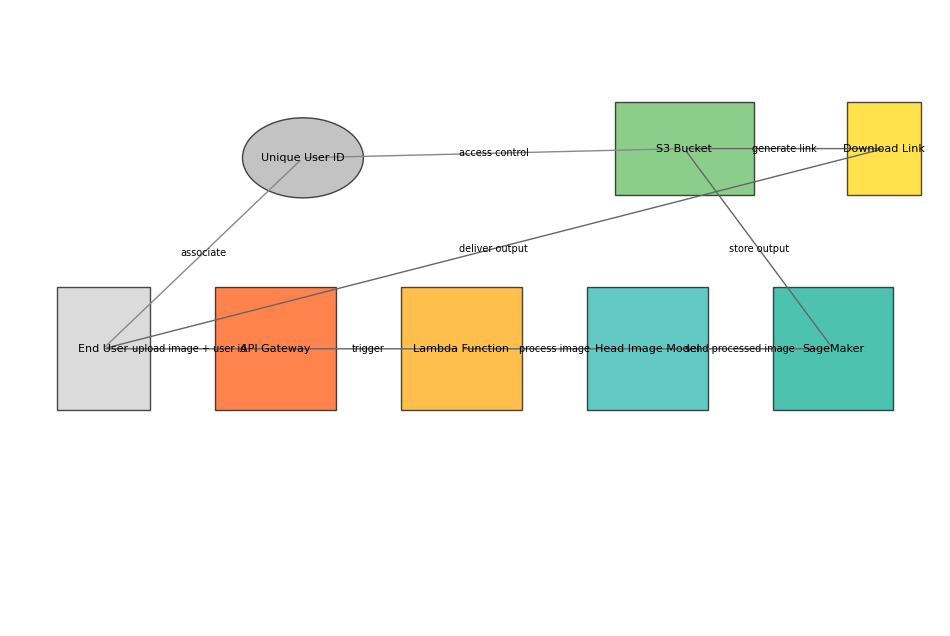

In [47]:
import json
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, FancyArrowPatch

def draw_architecture(json_file):
    with open(json_file, "r") as f:
        data = json.load(f)

    entities = {e["id"]: e for e in data["entities"]}
    relationships = data["relationships"]

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis("off")

    # --- Draw entities ---
    for eid, ent in entities.items():
        x1, y1, x2, y2 = ent["bbox"]
        width, height = x2 - x1, y2 - y1
        label = ent.get("label", eid)
        shape = ent["style"].get("shape", "rectangle")
        color = ent["style"].get("color", "#CCCCCC")

        if shape in ["rectangle", "rounded_rectangle"]:
            rect = Rectangle((x1, y1), width, height, linewidth=1,
                             edgecolor="black", facecolor=color, alpha=0.7)
            ax.add_patch(rect)
        elif shape == "circle":
            circ = Circle(((x1 + x2) / 2, (y1 + y2) / 2),
                          radius=width / 2, linewidth=1,
                          edgecolor="black", facecolor=color, alpha=0.7)
            ax.add_patch(circ)
        else:
            rect = Rectangle((x1, y1), width, height, linewidth=1,
                             edgecolor="black", facecolor=color, alpha=0.7)
            ax.add_patch(rect)

        # Label
        ax.text((x1 + x2) / 2, (y1 + y2) / 2, label,
                ha="center", va="center", fontsize=8, wrap=True)

    # --- Draw relationships ---
    for rel in relationships:
        src = entities[rel["source"]]["bbox"]
        tgt = entities[rel["target"]]["bbox"]

        # Midpoints
        src_center = ((src[0] + src[2]) / 2, (src[1] + src[3]) / 2)
        tgt_center = ((tgt[0] + tgt[2]) / 2, (tgt[1] + tgt[3]) / 2)

        arrow = FancyArrowPatch(src_center, tgt_center,
                                arrowstyle="->", color=rel["style"].get("color", "black"),
                                connectionstyle="arc3,rad=0.0")
        ax.add_patch(arrow)

        # Label
        mx = (src_center[0] + tgt_center[0]) / 2
        my = (src_center[1] + tgt_center[1]) / 2
        ax.text(mx, my, rel.get("label", ""),
                fontsize=7, ha="center", va="center", color="black")

    plt.show()


# ✅ How to use:
draw_architecture("prompt_0024.json")


⚠️ Logo not loaded for End User: [Errno 2] No such file or directory: '/content/sample_data/user.png'


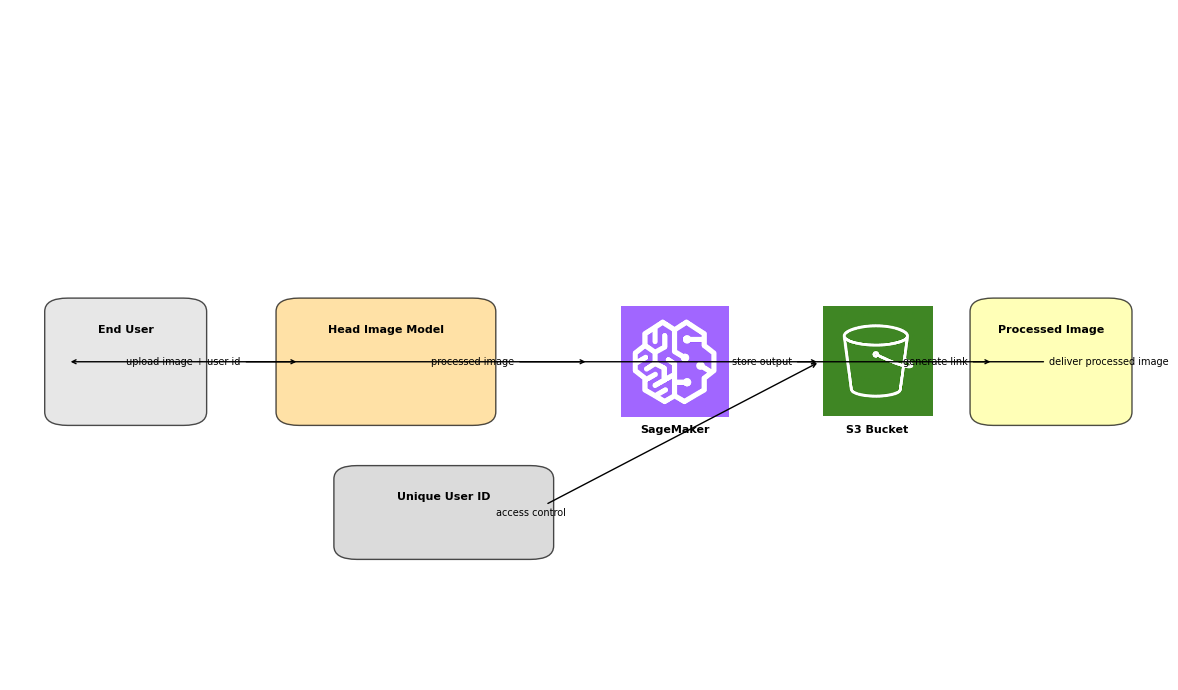

In [71]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Load JSON
with open("/content/prompt_0002.json") as f:
    diagram = json.load(f)

fig, ax = plt.subplots(figsize=(12, 7))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")

# def add_entity(ent):
#     x0, y0, x1, y1 = ent["bbox"]
#     w, h = x1 - x0, y1 - y0
#     rect = mpatches.FancyBboxPatch(
#         (x0, y0), w, h,
#         boxstyle="round,pad=0.02" if "rounded" in ent["style"]["shape"] else "square,pad=0.02",
#         linewidth=1, edgecolor="black", facecolor=ent["style"]["color"], alpha=0.7
#     )
#     ax.add_patch(rect)

#     # Draw label (top of box, not in center to leave space for logo)
#     ax.text((x0+x1)/2, y1-0.02, ent["label"],
#             ha="center", va="top", fontsize=8, weight="bold", color="black")

#     # If SageMaker → place logo INSIDE box
#     if ent.get("service") == "sagemaker" and "logo" in ent:
#         try:
#             img = plt.imread(ent["logo"])
#             imagebox = OffsetImage(img, zoom=0.25)  # increase zoom for larger logo
#             ab = AnnotationBbox(imagebox, ((x0+x1)/2, (y0+y1)/2), frameon=False)
#             ax.add_artist(ab)
#         except Exception as e:
#             print(f"⚠️ Logo not loaded for {ent['label']}: {e}")

def add_entity(ent):
    x0, y0, x1, y1 = ent["bbox"]
    w, h = x1 - x0, y1 - y0

    # ✅ Only draw box if "box" is not set to false
    if ent.get("box", True):
        rect = mpatches.FancyBboxPatch(
            (x0, y0), w, h,
            boxstyle="round,pad=0.02" if "rounded" in ent["style"].get("shape", "") else "square,pad=0.02",
            linewidth=1, edgecolor="black", facecolor=ent["style"].get("color", "#FFFFFF"), alpha=0.7
        )
        ax.add_patch(rect)

        # Draw label at top (inside box)
        ax.text((x0+x1)/2, y1-0.02, ent["label"],
                ha="center", va="top", fontsize=8, weight="bold", color="black")

    else:
        # ✅ If no box, just put label below the logo
        ax.text((x0+x1)/2, y0-0.02, ent["label"],
                ha="center", va="top", fontsize=8, weight="bold", color="black")

    # ✅ Always try to place logo if available
    if "logo" in ent:
        try:
            img = plt.imread(ent["logo"])
            imagebox = OffsetImage(img, zoom=0.35)  # enlarge logo
            ab = AnnotationBbox(imagebox, ((x0+x1)/2, (y0+y1)/2), frameon=False)
            ax.add_artist(ab)
        except Exception as e:
            print(f"⚠️ Logo not loaded for {ent['label']}: {e}")


# Draw entities
for ent in diagram["entities"]:
    add_entity(ent)

# Draw relationships
for rel in diagram["relationships"]:
    src = next(e for e in diagram["entities"] if e["id"] == rel["source"])
    tgt = next(e for e in diagram["entities"] if e["id"] == rel["target"])
    sx, sy = (src["bbox"][2], (src["bbox"][1]+src["bbox"][3])/2)
    tx, ty = (tgt["bbox"][0], (tgt["bbox"][1]+tgt["bbox"][3])/2)
    ax.annotate(rel["label"], xy=(tx, ty), xytext=(sx, sy),
                arrowprops=dict(arrowstyle="->", color=rel["style"]["color"], lw=1),
                fontsize=7, ha="center", va="center")

plt.tight_layout()
plt.show()
